<div style="font-family:monospace; font-size:15px; line-height:1.5; border-top: 1px solid black; border-bottom: 1px solid black; padding: 10px; text-align: center;">
    <strong>ADAM-SINDy OPTIMIZATION - DYNAMICAL SYSTEM IDENTIFICATION</strong><br>
    <strong></strong> SIVA VIKNESH & YOUNES TATARI <br>
    <strong></strong> siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com<br>
    <strong></strong> SCIENTIFIC COMPUTING & IMAGING INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA<br>
</div>

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]
import vtk
from vtk.util import numpy_support as VN
from itertools import combinations

Pharmacokinetics model
Paper:

AI-Aristotle: A physics-informed framework for systems biology gray-box identification

$$
k_g = k_0t^{-\lambda}
$$
$$
\dot{B} = k_gG-k_bB
$$

$$
\dot{G} = -k_gG
$$


$$
\dot{U} = k_bB
$$

$$
parameters : k_0, k_b, \lambda
$$


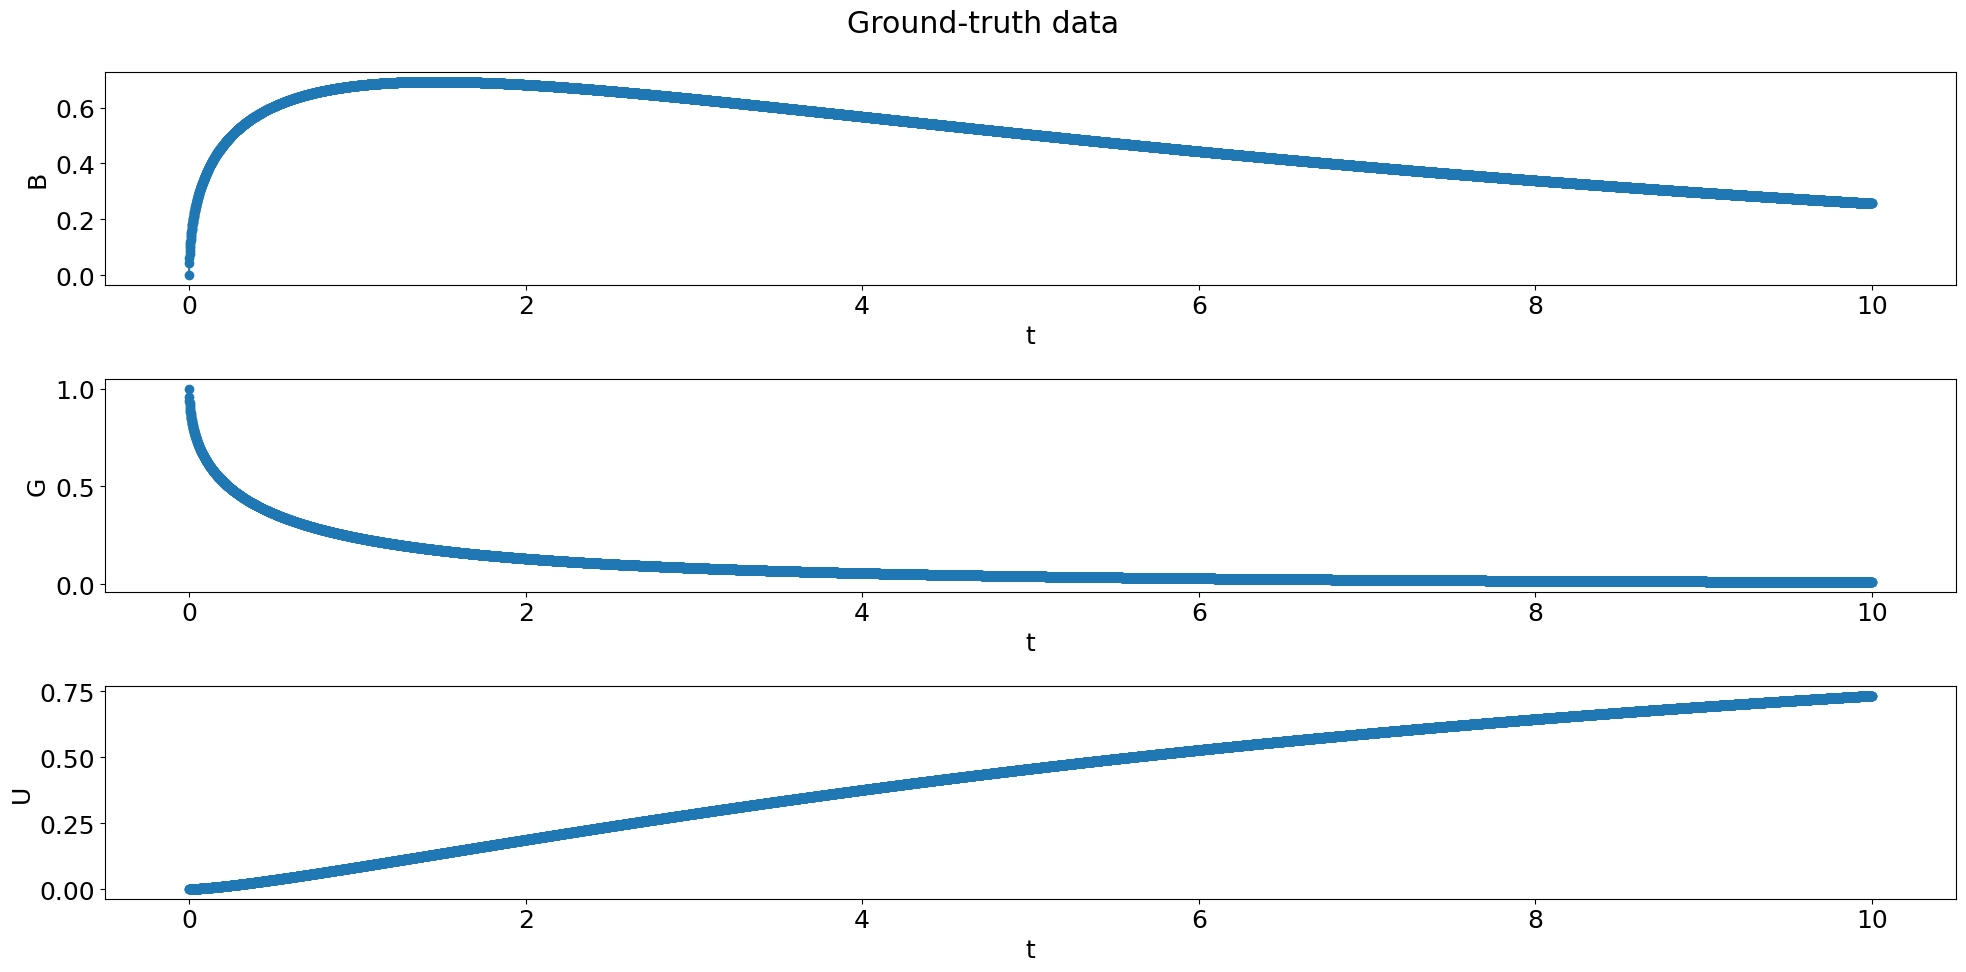

In [2]:
dt = 0.001
T  = 10
t  = np.arange(1e-6,T+dt,dt)

k0   = 0.72
kb   = 0.15
lam  = 0.5

def pharma_deriv(x_y_z, t0=t, k0 = k0, kb = kb, lam = lam):
    B, G , U = x_y_z
    kg = k0 * np.power(t0,-lam)
    dBdt =  kg*G - kb*B
    dGdt = -kg*G
    dUdt =  kb*B
    return [dBdt, dGdt, dUdt]

np.random.seed(123)
x0 = (0.0, 1.0, 0.0)
x_t = integrate.odeint(pharma_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
B,G,U = x_t.T

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, B, '-o')
ax[0].set(xlabel="t",ylabel="B")

ax[1].plot(t, G, '-o')
ax[1].set(xlabel="t",ylabel="G")

ax[2].plot(t, U, '-o')
ax[2].set(xlabel="t",ylabel="U")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(B, G, U, t, k0, kb, lam):
    tpower = torch.pow(t,-lam)
    dBdt = k0*torch.mul(G,tpower) - kb*B
    dGdt = -k0*torch.mul(G,tpower)
    dUdt = kb*B
    return torch.vstack((dBdt, dGdt, dUdt)).T


AVAILABLE PROCESSOR: cuda 



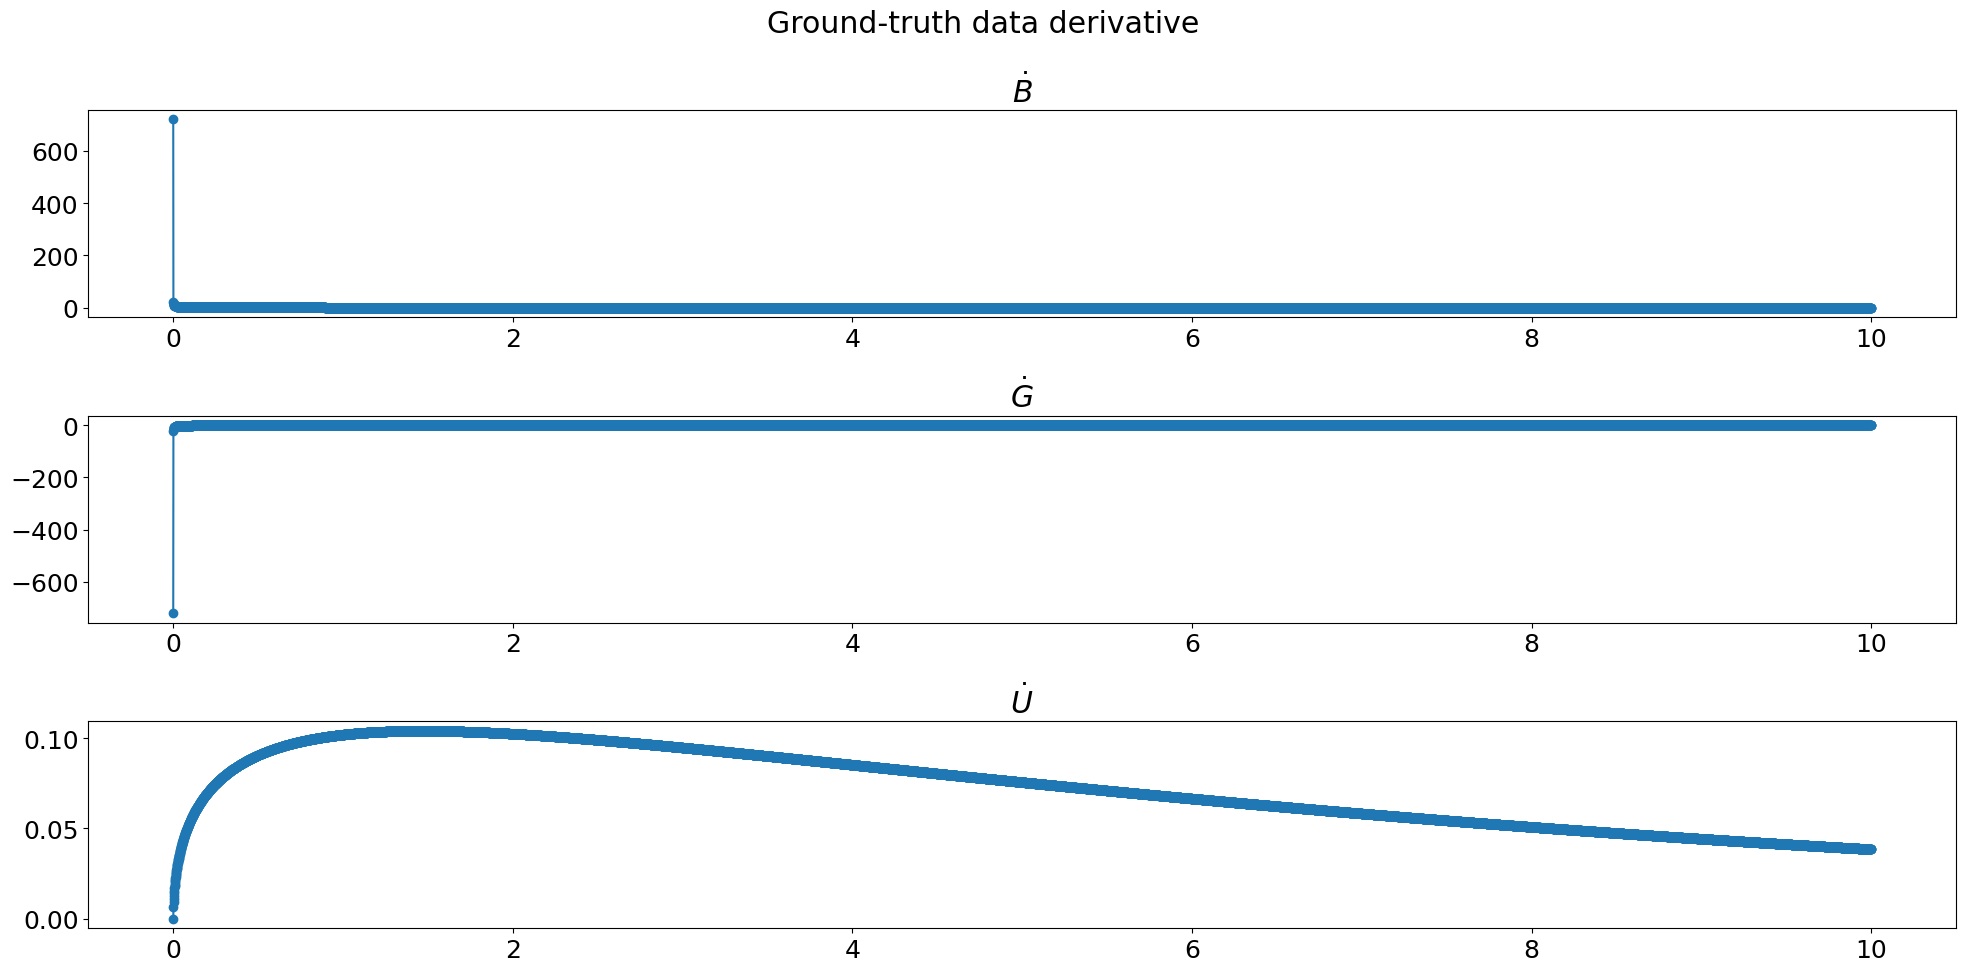

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 3
B        = torch.Tensor(B).to(processor)
G        = torch.Tensor(G).to(processor)
U        = torch.Tensor(U).to(processor)
t        = torch.Tensor(t).to(processor)
x_t      = torch.hstack((torch.Tensor(x_t).to(processor), t.reshape(-1, 1))).to(processor)

A_candidates = POOL_DATA (x_t, x_t.shape[1], 1).to(processor)
A1A2A3_time_deriv = DERIVATIVE (B, G, U, t, k0, kb, lam).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 40000
learning_rate = 1e-2
step_epoch    = 4500
decay_rate    = 0.50
tolerance     = 5e-3

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2A3_time_deriv[:, 0].detach().cpu().numpy(), '-o')
ax[0].set_title(r"$\dot{B}$")

ax[1].plot(t.detach().cpu().numpy(), A1A2A3_time_deriv[:, 1].detach().cpu().numpy(), '-o')
ax[1].set_title(r"$\dot{G}$")

ax[2].plot(t.detach().cpu().numpy(), A1A2A3_time_deriv[:, 2].detach().cpu().numpy(), '-o')
ax[2].set_title(r"$\dot{U}$")

fig.tight_layout()
plt.show()

In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        
    def forward(self, x):
        output = torch.sin(self.b*x)
        return output
    
class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b
        
    def forward(self, x):
        output = torch.cos(self.b*x)
        return output
    
class EXP_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.exp(self.b*x)
        return output
    
class POWER_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sign(x) * torch.pow(torch.abs(x), self.b)
        return output

In [6]:
class ADAM_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, aexp, axsine, axcosine, axexp, atpower):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.aexp     = aexp
        self.axsine   = axsine
        self.axcosine = axcosine
        self.axexp    = axexp
        self.atpower  = atpower
        
        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.exp      = EXP_TERM    (self.aexp)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        self.xexp     = EXP_TERM    (self.axexp)     
        self.tpower   = POWER_TERM  (self.atpower)
        
    def forward(self, x):
        x1             =  x [:,  1:4]
        t              = (x [:,  -1]).reshape(-1, 1)
        
        output_sine    = self.sine    (x1)
        output_cosine  = self.cosine  (x1)
        output_exp     = self.exp     (x1)
        output_xsine   = self.xsine   (x1)
        output_xcosine = self.xcosine (x1)
        output_xexp    = self.xexp    (x1)
        output_tpower  = self.tpower  (t)
 
        output_xsine   = (output_xsine  [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xexp    = (output_xexp   [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_power   = (x1 [:,None] * output_tpower[...,None]).reshape(x1.shape[0], -1)
        
        output = torch.hstack((x, output_sine, output_cosine, output_exp, output_xsine, output_xcosine, output_xexp, output_power)) @ self.a
        return output

In [7]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(44, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-2, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-2, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-2, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-2, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-2, N_modes), -1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-2, N_modes), -1.0, requires_grad= True, device= processor)

TPOWER_ADT  = torch.full((1, N_modes), -1.0, requires_grad= True, device= processor)


In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, SINE_ADT, COSINE_ADT, EXP_ADT, XSINE_ADT, XCOSINE_ADT, XEXP_ADT, TPOWER_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
torch.manual_seed(24)
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)


In [9]:
print(WEIGHTS.shape)

torch.Size([44, 3])


In [10]:
# TEMPORAL MODE 1
A1_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0], TPOWER_ADT[:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1], TPOWER_ADT[:, 1]).to(processor)

# TEMPORAL MODE 3
A3_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 2], SINE_ADT [:, 2], COSINE_ADT[:, 2], EXP_ADT[:, 2], XSINE_ADT [:, 2], XCOSINE_ADT[:, 2], XEXP_ADT [:, 2],  TPOWER_ADT[:, 2]).to(processor)


Loss_data     = torch.empty(size=(Epochs, 1))
Gamma_correct   = torch.empty(size=(Epochs, 1))
Gamma_incorrect = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out, A3_out  = A1_DT (A_candidates), A2_DT (A_candidates), A3_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out, A3_out), dim = 1)
    loss_epoch   = loss_function (A1A2A3_time_deriv, output_data) + torch.linalg.matrix_norm(torch.abs(WEIGHTS)*COEFF_ADT, ord =1)

    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        Gamma_incorrect [epoch] = WEIGHTS [0, 0].detach()
        Gamma_correct   [epoch] = WEIGHTS [-2, 0].detach()
        
        
        COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
        SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
        COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
        XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
        XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
        EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
        XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
        TPOWER_ADT  [torch.abs(TPOWER_ADT)  <= tolerance] = 0.0

    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)

    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

LOSS DATA, [EPOCH = 0 ]: 99993328.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 74343672.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 55550600.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 41838312.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 31833674.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 24508504.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 19111222.0
LEARNING RATE: 0.01
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 61 ]: 475003.3125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 62 ]: 469155.5625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 63 ]: 463491.4375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 64 ]: 457997.125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 65 ]: 452660.4375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 66 ]: 447469.46875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 67 ]: 442414.75
LEARNING RATE: 0.01
********************************************************************************

LOSS DATA, [EPOCH = 121 ]: 263041.90625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 122 ]: 260711.03125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 123 ]: 258405.375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 124 ]: 256124.640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 125 ]: 253868.5
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 126 ]: 251636.71875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 127 ]: 249429.03125
LEARNING RATE: 0.01
*********************************************************************

LOSS DATA, [EPOCH = 180 ]: 160284.640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 181 ]: 159024.125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 182 ]: 157775.90625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 183 ]: 156540.015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 184 ]: 155316.109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 185 ]: 154104.15625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 186 ]: 152904.109375
LEARNING RATE: 0.01
**************************************************************

LOSS DATA, [EPOCH = 240 ]: 102350.828125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 241 ]: 101628.421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 242 ]: 100912.1796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 243 ]: 100202.2421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 244 ]: 99498.3359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 245 ]: 98800.4765625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 246 ]: 98108.65625
LEARNING RATE: 0.01
*********************************************************

LOSS DATA, [EPOCH = 300 ]: 68130.9921875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 301 ]: 67689.1484375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 302 ]: 67250.6640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 303 ]: 66815.5703125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 304 ]: 66383.8125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 305 ]: 65955.3671875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 306 ]: 65530.21484375
LEARNING RATE: 0.01
***********************************************************

LOSS DATA, [EPOCH = 361 ]: 46411.34375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 362 ]: 46129.19140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 363 ]: 45849.015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 364 ]: 45570.7734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 365 ]: 45294.5078125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 366 ]: 45020.16796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 367 ]: 44747.71484375
LEARNING RATE: 0.01
*********************************************************

LOSS DATA, [EPOCH = 422 ]: 32286.734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 423 ]: 32099.591796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 424 ]: 31913.685546875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 425 ]: 31728.951171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 426 ]: 31545.431640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 427 ]: 31363.0859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 428 ]: 31181.890625
LEARNING RATE: 0.01
***************************************************

LOSS DATA, [EPOCH = 484 ]: 22663.482421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 485 ]: 22536.642578125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 486 ]: 22410.587890625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 487 ]: 22285.291015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 488 ]: 22160.744140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 489 ]: 22036.966796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 490 ]: 21913.935546875
LEARNING RATE: 0.01
*******************************************

LOSS DATA, [EPOCH = 546 ]: 16077.201171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 547 ]: 15989.490234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 548 ]: 15902.2998046875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 549 ]: 15815.615234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 550 ]: 15729.4423828125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 551 ]: 15643.75390625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 552 ]: 15558.5703125
LEARNING RATE: 0.01
********************************************

LOSS DATA, [EPOCH = 606 ]: 11613.9267578125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 607 ]: 11551.6796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 608 ]: 11489.787109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 609 ]: 11428.244140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 610 ]: 11367.0361328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 611 ]: 11306.166015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 612 ]: 11245.638671875
LEARNING RATE: 0.01
*******************************************

LOSS DATA, [EPOCH = 666 ]: 8430.541015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 667 ]: 8385.919921875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 668 ]: 8341.552734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 669 ]: 8297.4169921875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 670 ]: 8253.5400390625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 671 ]: 8209.8984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 672 ]: 8166.47705078125
LEARNING RATE: 0.01
************************************************

LOSS DATA, [EPOCH = 726 ]: 6140.48876953125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 727 ]: 6108.2734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 728 ]: 6076.23193359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 729 ]: 6044.38427734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 730 ]: 6012.66748046875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 731 ]: 5981.1455078125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 732 ]: 5949.76318359375
LEARNING RATE: 0.01
*****************************************

LOSS DATA, [EPOCH = 786 ]: 4482.65087890625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 787 ]: 4459.26904296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 788 ]: 4435.9931640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 789 ]: 4412.8603515625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 790 ]: 4389.88623046875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 791 ]: 4367.0068359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 792 ]: 4344.23046875
LEARNING RATE: 0.01
******************************************

LOSS DATA, [EPOCH = 846 ]: 3277.46533203125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 847 ]: 3260.425537109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 848 ]: 3243.489501953125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 849 ]: 3226.657958984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 850 ]: 3209.886962890625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 851 ]: 3193.24072265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 852 ]: 3176.658447265625
LEARNING RATE: 0.01
*******************************

LOSS DATA, [EPOCH = 906 ]: 2398.8232421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 907 ]: 2386.39208984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 908 ]: 2374.000244140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 909 ]: 2361.698974609375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 910 ]: 2349.44287109375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 911 ]: 2337.27587890625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 912 ]: 2325.207763671875
LEARNING RATE: 0.01
**********************************

LOSS DATA, [EPOCH = 966 ]: 1757.166259765625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 967 ]: 1748.073974609375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 968 ]: 1739.0111083984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 969 ]: 1729.9937744140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 970 ]: 1721.0950927734375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 971 ]: 1712.202880859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 972 ]: 1703.334716796875
LEARNING RATE: 0.01
**************************

LOSS DATA, [EPOCH = 1026 ]: 1287.905517578125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1027 ]: 1281.2476806640625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1028 ]: 1274.6357421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1029 ]: 1268.097900390625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1030 ]: 1261.5650634765625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1031 ]: 1255.0611572265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1032 ]: 1248.55859375
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 1086 ]: 944.5983276367188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1087 ]: 939.795654296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1088 ]: 934.9490966796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1089 ]: 930.085693359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1090 ]: 925.2767944335938
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1091 ]: 920.5057983398438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1092 ]: 915.7782592773438
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 1145 ]: 696.9855346679688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1146 ]: 693.4019165039062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1147 ]: 689.8926391601562
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1148 ]: 686.3250732421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1149 ]: 682.8045654296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1150 ]: 679.2709350585938
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1151 ]: 675.835205078125
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 1205 ]: 512.2741088867188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1206 ]: 509.6888732910156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1207 ]: 507.1117248535156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1208 ]: 504.4881591796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1209 ]: 501.901611328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1210 ]: 499.3802795410156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1211 ]: 496.8345031738281
LEARNING RATE: 0.01
***********************

LOSS DATA, [EPOCH = 1267 ]: 373.3376159667969
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1268 ]: 371.44500732421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1269 ]: 369.62835693359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1270 ]: 367.74114990234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1271 ]: 365.8960876464844
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1272 ]: 363.9867248535156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1273 ]: 362.15350341796875
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 1327 ]: 275.84307861328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1328 ]: 274.4346618652344
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1329 ]: 273.11822509765625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1330 ]: 271.7515869140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1331 ]: 270.4173583984375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1332 ]: 269.1235656738281
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1333 ]: 267.66424560546875
LEARNING RATE: 0.01
*******************

LOSS DATA, [EPOCH = 1387 ]: 204.6533966064453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1388 ]: 203.60107421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1389 ]: 202.54551696777344
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1390 ]: 201.57562255859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1391 ]: 200.4918975830078
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1392 ]: 199.5478057861328
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1393 ]: 198.61813354492188
LEARNING RATE: 0.01
*********************

LOSS DATA, [EPOCH = 1448 ]: 152.01425170898438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1449 ]: 151.26242065429688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1450 ]: 150.49977111816406
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1451 ]: 149.7908172607422
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1452 ]: 149.02345275878906
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1453 ]: 148.34056091308594
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1454 ]: 147.59275817871094
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1513 ]: 111.54000854492188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1514 ]: 110.95476531982422
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1515 ]: 110.47469329833984
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1516 ]: 110.00040435791016
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1517 ]: 109.5076904296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1518 ]: 109.07717895507812
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1519 ]: 108.60711669921875
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1575 ]: 84.16712188720703
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1576 ]: 83.8276596069336
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1577 ]: 83.48654174804688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1578 ]: 83.0769271850586
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1579 ]: 82.7098159790039
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1580 ]: 82.28919982910156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1581 ]: 81.88578033447266
LEARNING RATE: 0.01
*************************

LOSS DATA, [EPOCH = 1635 ]: 64.975830078125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1636 ]: 64.67564392089844
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1637 ]: 64.41326904296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1638 ]: 64.18377685546875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1639 ]: 63.903167724609375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1640 ]: 63.631378173828125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1641 ]: 63.35797882080078
LEARNING RATE: 0.01
**********************

LOSS DATA, [EPOCH = 1695 ]: 50.93827819824219
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1696 ]: 50.721675872802734
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1697 ]: 50.577842712402344
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1698 ]: 50.41006088256836
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1699 ]: 50.2325553894043
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1700 ]: 49.91532897949219
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1701 ]: 49.74639129638672
LEARNING RATE: 0.01
*********************

LOSS DATA, [EPOCH = 1755 ]: 40.736934661865234
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1756 ]: 40.59314727783203
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1757 ]: 40.52421188354492
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1758 ]: 40.40760040283203
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1759 ]: 40.162384033203125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1760 ]: 40.0071907043457
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1761 ]: 39.89628982543945
LEARNING RATE: 0.01
*********************

LOSS DATA, [EPOCH = 1815 ]: 33.09032440185547
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1816 ]: 32.87898254394531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1817 ]: 32.765960693359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1818 ]: 32.773597717285156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1819 ]: 32.59202194213867
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1820 ]: 32.520992279052734
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1821 ]: 32.46155548095703
LEARNING RATE: 0.01
*******************

LOSS DATA, [EPOCH = 1873 ]: 27.19407081604004
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1874 ]: 27.067462921142578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1875 ]: 26.938385009765625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1876 ]: 26.849462509155273
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1877 ]: 26.851032257080078
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1878 ]: 26.75907325744629
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1879 ]: 26.69747543334961
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 1933 ]: 22.92564582824707
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1934 ]: 22.9840030670166
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1935 ]: 22.847379684448242
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1936 ]: 22.685861587524414
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1937 ]: 22.6578426361084
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1938 ]: 22.77281951904297
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1939 ]: 22.695554733276367
LEARNING RATE: 0.01
*********************

LOSS DATA, [EPOCH = 1993 ]: 19.657968521118164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1994 ]: 19.58598518371582
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1995 ]: 19.621915817260742
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1996 ]: 19.654464721679688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1997 ]: 19.5211124420166
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1998 ]: 19.48749351501465
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1999 ]: 19.311702728271484
LEARNING RATE: 0.01
*******************

LOSS DATA, [EPOCH = 2053 ]: 16.94152069091797
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2054 ]: 16.876243591308594
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2055 ]: 16.838289260864258
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2056 ]: 16.764577865600586
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2057 ]: 16.771503448486328
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2058 ]: 16.6641788482666
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2059 ]: 16.758914947509766
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 2113 ]: 14.729601860046387
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2114 ]: 14.721207618713379
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2115 ]: 14.869750022888184
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2116 ]: 14.835274696350098
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2117 ]: 14.79865550994873
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2118 ]: 14.764848709106445
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2119 ]: 14.788440704345703
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 2173 ]: 14.47067928314209
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2174 ]: 14.464058876037598
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2175 ]: 14.423707962036133
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2176 ]: 14.397857666015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2177 ]: 14.357156753540039
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2178 ]: 14.29239559173584
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2179 ]: 14.264719009399414
LEARNING RATE: 0.01
*****************

LOSS DATA, [EPOCH = 2233 ]: 14.002711296081543
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2234 ]: 14.039003372192383
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2235 ]: 13.990559577941895
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2236 ]: 14.047676086425781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2237 ]: 14.092019081115723
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2238 ]: 14.211837768554688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2239 ]: 14.11075210571289
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 2293 ]: 13.764960289001465
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2294 ]: 13.778467178344727
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2295 ]: 13.791376113891602
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2296 ]: 13.844438552856445
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2297 ]: 13.79094123840332
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2298 ]: 13.806522369384766
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2299 ]: 13.761686325073242
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 2353 ]: 13.859622955322266
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2354 ]: 13.841756820678711
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2355 ]: 13.810291290283203
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2356 ]: 13.781005859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2357 ]: 13.858901977539062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2358 ]: 13.796103477478027
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2359 ]: 13.845314979553223
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 2413 ]: 13.415862083435059
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2414 ]: 13.436412811279297
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2415 ]: 13.451871871948242
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2416 ]: 13.31016731262207
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2417 ]: 13.06202507019043
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2418 ]: 12.896154403686523
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2419 ]: 12.63740062713623
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 2473 ]: 2.4653573036193848
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2474 ]: 2.194075584411621
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2475 ]: 2.065176010131836
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2476 ]: 1.9416707754135132
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2477 ]: 2.028306722640991
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2478 ]: 1.9488494396209717
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2479 ]: 1.7563436031341553
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 2532 ]: 0.8822325468063354
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2533 ]: 0.9247897267341614
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2534 ]: 0.831403374671936
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2535 ]: 0.7720102071762085
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2536 ]: 0.7643240690231323
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2537 ]: 0.7582199573516846
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2538 ]: 0.8719370365142822
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 2592 ]: 0.6414621472358704
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2593 ]: 0.7586297988891602
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2594 ]: 0.7436158657073975
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2595 ]: 0.6975191235542297
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2596 ]: 0.5550763607025146
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2597 ]: 0.6001651287078857
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2598 ]: 0.5392605066299438
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 2665 ]: 0.6888450980186462
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2666 ]: 0.6046574115753174
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2667 ]: 0.6083917021751404
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2668 ]: 0.6814775466918945
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2669 ]: 0.6806437969207764
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2670 ]: 0.688454270362854
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2671 ]: 0.6278910636901855
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 2731 ]: 0.5450625419616699
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2732 ]: 0.6214337348937988
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2733 ]: 0.5896802544593811
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2734 ]: 0.5641728043556213
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2735 ]: 0.47827377915382385
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2736 ]: 0.4521215856075287
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2737 ]: 0.42439067363739014
LEARNING RATE: 0.01
*************

LOSS DATA, [EPOCH = 2791 ]: 0.4581908583641052
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2792 ]: 0.4681316018104553
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2793 ]: 0.3793904781341553
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2794 ]: 0.37185025215148926
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2795 ]: 0.46101704239845276
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2796 ]: 0.48628634214401245
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2797 ]: 0.4661734700202942
LEARNING RATE: 0.01
************

LOSS DATA, [EPOCH = 2851 ]: 0.5152177810668945
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2852 ]: 0.504501223564148
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2853 ]: 0.4856906831264496
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2854 ]: 0.4232579469680786
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2855 ]: 0.3723762631416321
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2856 ]: 0.4241752624511719
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2857 ]: 0.4443826675415039
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 2911 ]: 0.3455123007297516
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2912 ]: 0.40213000774383545
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2913 ]: 0.4139752984046936
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2914 ]: 0.40383249521255493
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2915 ]: 0.37180039286613464
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2916 ]: 0.3896835446357727
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2917 ]: 0.43176764249801636
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 2971 ]: 0.3323918879032135
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2972 ]: 0.3657763600349426
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2973 ]: 0.4111018180847168
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2974 ]: 0.3893580436706543
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2975 ]: 0.47241050004959106
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2976 ]: 0.4747017025947571
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2977 ]: 0.4922022819519043
LEARNING RATE: 0.01
**************

LOSS DATA, [EPOCH = 3031 ]: 0.41708579659461975
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3032 ]: 0.43465280532836914
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3033 ]: 0.39173024892807007
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3034 ]: 0.42848655581474304
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3035 ]: 0.35578426718711853
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3036 ]: 0.4260076582431793
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3037 ]: 0.42060479521751404
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 3100 ]: 0.31629419326782227
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3101 ]: 0.31744879484176636
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3102 ]: 0.33664819598197937
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3103 ]: 0.2956738770008087
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3104 ]: 0.3825051784515381
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3105 ]: 0.3565743565559387
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3106 ]: 0.34371107816696167
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 3169 ]: 0.3203791379928589
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3170 ]: 0.3459285795688629
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3171 ]: 0.31474483013153076
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3172 ]: 0.3172665238380432
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3173 ]: 0.32988816499710083
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3174 ]: 0.24934005737304688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3175 ]: 0.27871251106262207
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 3228 ]: 0.2644316256046295
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3229 ]: 0.27696824073791504
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3230 ]: 0.2552730143070221
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3231 ]: 0.36643296480178833
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3232 ]: 0.4146609604358673
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3233 ]: 0.33230260014533997
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3234 ]: 0.25977611541748047
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 3288 ]: 0.3077447712421417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3289 ]: 0.32388919591903687
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3290 ]: 0.26787954568862915
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3291 ]: 0.32830238342285156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3292 ]: 0.333729088306427
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3293 ]: 0.30210912227630615
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3294 ]: 0.3378179669380188
LEARNING RATE: 0.01
************

LOSS DATA, [EPOCH = 3348 ]: 0.28799477219581604
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3349 ]: 0.28314414620399475
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3350 ]: 0.3091001510620117
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3351 ]: 0.2761780023574829
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3352 ]: 0.2423606514930725
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3353 ]: 0.216645747423172
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3354 ]: 0.19101813435554504
LEARNING RATE: 0.01
*************

LOSS DATA, [EPOCH = 3408 ]: 0.2546328902244568
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3409 ]: 0.22197522222995758
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3410 ]: 0.23018629848957062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3411 ]: 0.2588633596897125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3412 ]: 0.25833579897880554
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3413 ]: 0.25419703125953674
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3414 ]: 0.2508227825164795
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 3468 ]: 0.2183450311422348
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3469 ]: 0.19494029879570007
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3470 ]: 0.20560716092586517
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3471 ]: 0.20594561100006104
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3472 ]: 0.19605635106563568
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3473 ]: 0.20331698656082153
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3474 ]: 0.16410084068775177
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 3528 ]: 0.23334118723869324
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3529 ]: 0.2185535728931427
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3530 ]: 0.2621723711490631
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3531 ]: 0.24042582511901855
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3532 ]: 0.26808828115463257
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3533 ]: 0.27162158489227295
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3534 ]: 0.22647309303283691
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 3588 ]: 0.21048538386821747
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3589 ]: 0.1556648313999176
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3590 ]: 0.2014872133731842
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3591 ]: 0.19819945096969604
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3592 ]: 0.20147791504859924
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3593 ]: 0.16129207611083984
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3594 ]: 0.1711861789226532
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 3651 ]: 0.24835065007209778
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3652 ]: 0.1874014139175415
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3653 ]: 0.13455218076705933
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3654 ]: 0.18659169971942902
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3655 ]: 0.18011750280857086
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3656 ]: 0.16573050618171692
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3657 ]: 0.18264612555503845
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 3711 ]: 0.4889698028564453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3712 ]: 0.30868831276893616
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3713 ]: 0.2911788821220398
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3714 ]: 0.30323147773742676
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3715 ]: 0.2714965045452118
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3716 ]: 0.25734439492225647
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3717 ]: 0.27596399188041687
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 3771 ]: 0.17350757122039795
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3772 ]: 0.19198858737945557
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3773 ]: 0.1628808081150055
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3774 ]: 0.1594458818435669
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3775 ]: 0.16922713816165924
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3776 ]: 0.15556052327156067
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3777 ]: 0.12976466119289398
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 3831 ]: 0.14526192843914032
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3832 ]: 0.1316019743680954
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3833 ]: 0.14746268093585968
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3834 ]: 0.12389497458934784
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3835 ]: 0.12426239997148514
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3836 ]: 0.09417016059160233
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3837 ]: 0.13111832737922668
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 3892 ]: 0.14485326409339905
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3893 ]: 0.15865831077098846
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3894 ]: 0.15644510090351105
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3895 ]: 0.1274964064359665
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3896 ]: 0.10639248788356781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3897 ]: 0.10923121124505997
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3898 ]: 0.12500379979610443
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 3952 ]: 0.13262297213077545
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3953 ]: 0.12000444531440735
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3954 ]: 0.12404808402061462
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3955 ]: 0.13426129519939423
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3956 ]: 0.13149906694889069
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3957 ]: 0.1425262838602066
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3958 ]: 0.1036398708820343
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 4012 ]: 0.13454313576221466
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4013 ]: 0.11684539169073105
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4014 ]: 0.10483047366142273
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4015 ]: 0.11720509827136993
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4016 ]: 0.093894362449646
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4017 ]: 0.11522864550352097
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4018 ]: 0.13952268660068512
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 4072 ]: 0.09175674617290497
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4073 ]: 0.09969066828489304
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4074 ]: 0.14017826318740845
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4075 ]: 0.147305428981781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4076 ]: 0.12194275110960007
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4077 ]: 0.10316145420074463
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4078 ]: 0.13302387297153473
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 4132 ]: 0.13290053606033325
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4133 ]: 0.096445731818676
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4134 ]: 0.10281125456094742
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4135 ]: 0.08305536210536957
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4136 ]: 0.11146590858697891
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4137 ]: 0.0930834487080574
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4138 ]: 0.06398097425699234
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 4194 ]: 0.06564382463693619
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4195 ]: 0.08018069714307785
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4196 ]: 0.09327015280723572
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4197 ]: 0.08268716186285019
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4198 ]: 0.06429281085729599
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4199 ]: 0.0638989731669426
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4200 ]: 0.06186901405453682
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 4254 ]: 0.05385429039597511
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4255 ]: 0.06381046772003174
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4256 ]: 0.060821667313575745
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4257 ]: 0.062240637838840485
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4258 ]: 0.07686718553304672
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4259 ]: 0.07016513496637344
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4260 ]: 0.07694994658231735
LEARNING RATE: 0.01
******

LOSS DATA, [EPOCH = 4313 ]: 0.0725330039858818
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4314 ]: 0.06298358738422394
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4315 ]: 0.06655757874250412
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4316 ]: 0.06715594232082367
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4317 ]: 0.08452705293893814
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4318 ]: 0.08248697966337204
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4319 ]: 0.06413904577493668
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 4373 ]: 0.05656884238123894
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4374 ]: 0.062298085540533066
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4375 ]: 0.057839591056108475
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4376 ]: 0.06618072092533112
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4377 ]: 0.0646142065525055
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4378 ]: 0.05583357438445091
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4379 ]: 0.04745633900165558
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 4433 ]: 0.039411213248968124
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4434 ]: 0.03821604326367378
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4435 ]: 0.04825248941779137
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4436 ]: 0.050094544887542725
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4437 ]: 0.04177042096853256
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4438 ]: 0.049913160502910614
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4439 ]: 0.04439035430550575
LEARNING RATE: 0.01
*****

LOSS DATA, [EPOCH = 4493 ]: 0.04456113278865814
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4494 ]: 0.04542765021324158
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4495 ]: 0.04921000450849533
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4496 ]: 0.03718898445367813
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4497 ]: 0.04612737149000168
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4498 ]: 0.05270377919077873
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4499 ]: 0.04576794430613518
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 4553 ]: 0.03636106476187706
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4554 ]: 0.02837219461798668
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4555 ]: 0.019104255363345146
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4556 ]: 0.02787092700600624
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4557 ]: 0.0344264879822731
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4558 ]: 0.045382145792245865
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4559 ]: 0.05866318196058273
LEARNING RATE: 0.005


LOSS DATA, [EPOCH = 4611 ]: 0.03850042074918747
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4612 ]: 0.06486611068248749
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4613 ]: 0.05987983196973801
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4614 ]: 0.04018720984458923
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4615 ]: 0.0293719545006752
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4616 ]: 0.043534815311431885
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4617 ]: 0.03778822347521782
LEARNING RATE: 0.005
*

LOSS DATA, [EPOCH = 4671 ]: 0.032778821885585785
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4672 ]: 0.022111661732196808
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4673 ]: 0.04751467704772949
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4674 ]: 0.04101133346557617
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4675 ]: 0.04583084210753441
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4676 ]: 0.046651843935251236
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4677 ]: 0.05672987177968025
LEARNING RATE: 0.00

LOSS DATA, [EPOCH = 4731 ]: 0.03295565024018288
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4732 ]: 0.02347314916551113
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4733 ]: 0.01735875755548477
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4734 ]: 0.02324668876826763
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4735 ]: 0.0281350277364254
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4736 ]: 0.022779881954193115
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4737 ]: 0.01904115080833435
LEARNING RATE: 0.005
*

LOSS DATA, [EPOCH = 4791 ]: 0.041930947452783585
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4792 ]: 0.045720577239990234
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4793 ]: 0.03889506310224533
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4794 ]: 0.03841574862599373
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4795 ]: 0.04789586365222931
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4796 ]: 0.04216397553682327
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4797 ]: 0.03610675036907196
LEARNING RATE: 0.005

LOSS DATA, [EPOCH = 4851 ]: 0.03046083077788353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4852 ]: 0.028961898759007454
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4853 ]: 0.027759747579693794
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4854 ]: 0.03315316140651703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4855 ]: 0.031531620770692825
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4856 ]: 0.02578694559633732
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4857 ]: 0.027730602771043777
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 4912 ]: 0.018311314284801483
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4913 ]: 0.01351289264857769
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4914 ]: 0.016252242028713226
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4915 ]: 0.013005875051021576
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4916 ]: 0.0202775988727808
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4917 ]: 0.021240228787064552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4918 ]: 0.027331601828336716
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 4972 ]: 0.02466631308197975
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4973 ]: 0.02470260113477707
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4974 ]: 0.024649638682603836
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4975 ]: 0.021076355129480362
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4976 ]: 0.017603933811187744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4977 ]: 0.012813683599233627
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4978 ]: 0.025284860283136368
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 5033 ]: 0.0504881888628006
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5034 ]: 0.022534040734171867
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5035 ]: 0.02641383558511734
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5036 ]: 0.030563659965991974
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5037 ]: 0.028788870200514793
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5038 ]: 0.024175936356186867
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5039 ]: 0.019114399328827858
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 5099 ]: 0.0394405797123909
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5100 ]: 0.03633234277367592
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5101 ]: 0.019916165620088577
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5102 ]: 0.02667430229485035
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5103 ]: 0.02328108437359333
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5104 ]: 0.02323117107152939
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5105 ]: 0.03989280387759209
LEARNING RATE: 0.005
*

LOSS DATA, [EPOCH = 5160 ]: 0.014126419089734554
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5161 ]: 0.018006665632128716
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5162 ]: 0.017579153180122375
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5163 ]: 0.016123579815030098
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5164 ]: 0.01330593228340149
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5165 ]: 0.013986547477543354
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5166 ]: 0.012296424247324467
LEARNING RATE: 0

LOSS DATA, [EPOCH = 5220 ]: 0.01592004857957363
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5221 ]: 0.01373488549143076
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5222 ]: 0.012292088009417057
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5223 ]: 0.01280769519507885
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5224 ]: 0.018881216645240784
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5225 ]: 0.01779165118932724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5226 ]: 0.018520459532737732
LEARNING RATE: 0.00

LOSS DATA, [EPOCH = 5278 ]: 0.010739007033407688
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5279 ]: 0.013293900527060032
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5280 ]: 0.018044717609882355
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5281 ]: 0.017522944137454033
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5282 ]: 0.01437744777649641
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5283 ]: 0.016838809475302696
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5284 ]: 0.016709592193365097
LEARNING RATE: 0

LOSS DATA, [EPOCH = 5338 ]: 0.03141644969582558
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5339 ]: 0.023555763065814972
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5340 ]: 0.020411673933267593
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5341 ]: 0.03836897388100624
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5342 ]: 0.03380422294139862
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5343 ]: 0.01393194030970335
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5344 ]: 0.019691986963152885
LEARNING RATE: 0.00

LOSS DATA, [EPOCH = 5400 ]: 0.03199503943324089
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5401 ]: 0.02873779460787773
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5402 ]: 0.016039008274674416
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5403 ]: 0.01656389608979225
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5404 ]: 0.03345673903822899
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5405 ]: 0.02974916808307171
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5406 ]: 0.016009414568543434
LEARNING RATE: 0.005

LOSS DATA, [EPOCH = 5460 ]: 0.019250530749559402
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5461 ]: 0.030156191438436508
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5462 ]: 0.02762646973133087
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5463 ]: 0.01858198642730713
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5464 ]: 0.020825276151299477
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5465 ]: 0.029813656583428383
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5466 ]: 0.026855148375034332
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 5520 ]: 0.014949530363082886
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5521 ]: 0.011058125644922256
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5522 ]: 0.020453430712223053
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5523 ]: 0.018003422766923904
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5524 ]: 0.013075675815343857
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5525 ]: 0.02035633660852909
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5526 ]: 0.019115254282951355
LEARNING RATE: 0

LOSS DATA, [EPOCH = 5580 ]: 0.02435905858874321
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5581 ]: 0.02696722000837326
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5582 ]: 0.02430647425353527
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5583 ]: 0.023502178490161896
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5584 ]: 0.022428954020142555
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5585 ]: 0.02687656134366989
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5586 ]: 0.02453966625034809
LEARNING RATE: 0.005

LOSS DATA, [EPOCH = 5641 ]: 0.012954041361808777
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5642 ]: 0.01377627532929182
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5643 ]: 0.020454250276088715
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5644 ]: 0.019115528091788292
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5645 ]: 0.011711278930306435
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5646 ]: 0.013632738962769508
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5647 ]: 0.011819220148026943
LEARNING RATE: 0

LOSS DATA, [EPOCH = 5701 ]: 0.01692815311253071
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5702 ]: 0.017330577597022057
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5703 ]: 0.01668931357562542
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5704 ]: 0.01678287610411644
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5705 ]: 0.014085657894611359
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5706 ]: 0.011314106173813343
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5707 ]: 0.011479237116873264
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 5766 ]: 0.011680297553539276
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5767 ]: 0.00921265035867691
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5768 ]: 0.010029974393546581
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5769 ]: 0.010275168344378471
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5770 ]: 0.008231712505221367
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5771 ]: 0.008664360269904137
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5772 ]: 0.011087409220635891
LEARNING RATE: 0

LOSS DATA, [EPOCH = 5835 ]: 0.008273416198790073
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5836 ]: 0.006048859562724829
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5837 ]: 0.006276133470237255
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5838 ]: 0.006105415523052216
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5839 ]: 0.006684390362352133
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5840 ]: 0.006108571775257587
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5841 ]: 0.011550907045602798
LEARNING RATE: 

LOSS DATA, [EPOCH = 5895 ]: 0.01599295437335968
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5896 ]: 0.010549673810601234
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5897 ]: 0.01295398361980915
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5898 ]: 0.011515680700540543
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5899 ]: 0.008573963306844234
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5900 ]: 0.01713705062866211
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5901 ]: 0.015707165002822876
LEARNING RATE: 0.0

LOSS DATA, [EPOCH = 5955 ]: 0.0041123549453914165
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5956 ]: 0.004887464456260204
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5957 ]: 0.0036487840116024017
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5958 ]: 0.011464704759418964
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5959 ]: 0.010032424703240395
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5960 ]: 0.0075229075737297535
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5961 ]: 0.019396914169192314
LEARNING RAT

LOSS DATA, [EPOCH = 6016 ]: 0.010689680464565754
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6017 ]: 0.0073485239408910275
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6018 ]: 0.004996890667825937
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6019 ]: 0.0032113497145473957
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6020 ]: 0.006318972446024418
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6021 ]: 0.006924732588231564
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6022 ]: 0.009397146292030811
LEARNING RATE

LOSS DATA, [EPOCH = 6076 ]: 0.008499998599290848
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6077 ]: 0.008843302726745605
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6078 ]: 0.007443128619343042
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6079 ]: 0.0056630149483680725
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6080 ]: 0.006270912941545248
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6081 ]: 0.006711672991514206
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6082 ]: 0.008529018610715866
LEARNING RATE:

LOSS DATA, [EPOCH = 6136 ]: 0.009395301342010498
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6137 ]: 0.018158748745918274
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6138 ]: 0.016092481091618538
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6139 ]: 0.010324045084416866
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6140 ]: 0.010384958237409592
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6141 ]: 0.012820403091609478
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6142 ]: 0.008670703507959843
LEARNING RATE: 

LOSS DATA, [EPOCH = 6196 ]: 0.008805676363408566
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6197 ]: 0.009483305737376213
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6198 ]: 0.01124416384845972
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6199 ]: 0.012595700100064278
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6200 ]: 0.012476327829062939
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6201 ]: 0.01040405873209238
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6202 ]: 0.009930131956934929
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 6251 ]: 0.0034740904811769724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6252 ]: 0.003220477607101202
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6253 ]: 0.005992126185446978
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6254 ]: 0.006540474481880665
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6255 ]: 0.005155711434781551
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6256 ]: 0.005480114836245775
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6257 ]: 0.004794599022716284
LEARNING RATE:

LOSS DATA, [EPOCH = 6323 ]: 0.007144880946725607
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6324 ]: 0.01073307916522026
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6325 ]: 0.009968580678105354
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6326 ]: 0.0038611209020018578
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6327 ]: 0.009719772264361382
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6328 ]: 0.013943864032626152
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6329 ]: 0.012400769628584385
LEARNING RATE: 

LOSS DATA, [EPOCH = 6383 ]: 0.008605452254414558
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6384 ]: 0.007445993833243847
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6385 ]: 0.007908938452601433
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6386 ]: 0.007951035164296627
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6387 ]: 0.013200093060731888
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6388 ]: 0.012197775766253471
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6389 ]: 0.0077706435695290565
LEARNING RATE:

LOSS DATA, [EPOCH = 6455 ]: 0.006354146171361208
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6456 ]: 0.006052968092262745
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6457 ]: 0.002793368883430958
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6458 ]: 0.006212550215423107
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6459 ]: 0.005409122910350561
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6460 ]: 0.004117157310247421
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6461 ]: 0.007588942069560289
LEARNING RATE: 

LOSS DATA, [EPOCH = 6515 ]: 0.00427650474011898
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6516 ]: 0.004447135142982006
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6517 ]: 0.004446284845471382
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6518 ]: 0.003994817845523357
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6519 ]: 0.0027972902171313763
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6520 ]: 0.002830539597198367
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6521 ]: 0.0026474357582628727
LEARNING RATE:

LOSS DATA, [EPOCH = 6575 ]: 0.0058469329960644245
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6576 ]: 0.00623792689293623
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6577 ]: 0.0066626290790736675
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6578 ]: 0.005775808356702328
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6579 ]: 0.004469539970159531
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6580 ]: 0.005688711069524288
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6581 ]: 0.005769193638116121
LEARNING RATE:

LOSS DATA, [EPOCH = 6633 ]: 0.004096703603863716
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6634 ]: 0.0034727950114756823
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6635 ]: 0.004069775342941284
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6636 ]: 0.0041185831651091576
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6637 ]: 0.003990132827311754
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6638 ]: 0.004110987763851881
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6639 ]: 0.007644719909876585
LEARNING RATE

LOSS DATA, [EPOCH = 6693 ]: 0.005248687695711851
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6694 ]: 0.005004569888114929
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6695 ]: 0.0034404403995722532
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6696 ]: 0.004533639643341303
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6697 ]: 0.003936311230063438
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6698 ]: 0.003721999004483223
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6699 ]: 0.006228332873433828
LEARNING RATE:

LOSS DATA, [EPOCH = 6753 ]: 0.00571808498352766
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6754 ]: 0.005423247814178467
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6755 ]: 0.00477883405983448
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6756 ]: 0.0038779473397880793
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6757 ]: 0.004201451316475868
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6758 ]: 0.00340844364836812
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6759 ]: 0.003630267921835184
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 6812 ]: 0.004843018017709255
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6813 ]: 0.003989905584603548
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6814 ]: 0.004012787248939276
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6815 ]: 0.00596171710640192
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6816 ]: 0.005636075045913458
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6817 ]: 0.003769797505810857
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6818 ]: 0.0032390919514000416
LEARNING RATE: 

LOSS DATA, [EPOCH = 6873 ]: 0.005813729949295521
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6874 ]: 0.005815709009766579
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6875 ]: 0.00618683360517025
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6876 ]: 0.005558444187045097
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6877 ]: 0.005431857891380787
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6878 ]: 0.004448414780199528
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6879 ]: 0.0047690244391560555
LEARNING RATE: 

LOSS DATA, [EPOCH = 6934 ]: 0.002219808753579855
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6935 ]: 0.0018868931801989675
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6936 ]: 0.0018160926410928369
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6937 ]: 0.0019506134558469057
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6938 ]: 0.0017807965632528067
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6939 ]: 0.0023833694867789745
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6940 ]: 0.00263045821338892
LEARNING RA

LOSS DATA, [EPOCH = 6994 ]: 0.0043702940456569195
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6995 ]: 0.004005190450698137
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6996 ]: 0.0023300673346966505
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6997 ]: 0.00306492205709219
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6998 ]: 0.004505882039666176
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 6999 ]: 0.004169318825006485
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7000 ]: 0.003257797798141837
LEARNING RATE:

LOSS DATA, [EPOCH = 7054 ]: 0.002856483682990074
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7055 ]: 0.00306076742708683
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7056 ]: 0.0026956084184348583
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7057 ]: 0.002753108274191618
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7058 ]: 0.003358454443514347
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7059 ]: 0.003176784375682473
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7060 ]: 0.0021671545691788197
LEARNING RATE:

LOSS DATA, [EPOCH = 7118 ]: 0.0017097967211157084
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7119 ]: 0.002435087226331234
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7120 ]: 0.0025807665660977364
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7121 ]: 0.002739314455538988
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7122 ]: 0.002405171748250723
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7123 ]: 0.0023485820274800062
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7124 ]: 0.001350147882476449
LEARNING RAT

LOSS DATA, [EPOCH = 7179 ]: 0.001969111617654562
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7180 ]: 0.002400761004537344
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7181 ]: 0.003226569388061762
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7182 ]: 0.002838658168911934
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7183 ]: 0.001814556890167296
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7184 ]: 0.0020742984488606453
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7185 ]: 0.002011233940720558
LEARNING RATE:

LOSS DATA, [EPOCH = 7240 ]: 0.002503420226275921
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7241 ]: 0.0023319320753216743
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7242 ]: 0.0011143330484628677
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7243 ]: 0.0015849783085286617
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7244 ]: 0.001840965123847127
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7245 ]: 0.0017134688096120954
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7246 ]: 0.0012479352299124002
LEARNING R

LOSS DATA, [EPOCH = 7300 ]: 0.0024059293791651726
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7301 ]: 0.0015796900261193514
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7302 ]: 0.0019467284437268972
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7303 ]: 0.002474710578098893
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7304 ]: 0.002300041262060404
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7305 ]: 0.0017908882582560182
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7306 ]: 0.0016814128030091524
LEARNING R

LOSS DATA, [EPOCH = 7359 ]: 0.0019812574610114098
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7360 ]: 0.002759501338005066
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7361 ]: 0.002619575709104538
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7362 ]: 0.001363552175462246
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7363 ]: 0.0019681446719914675
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7364 ]: 0.0028937230817973614
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7365 ]: 0.00269352737814188
LEARNING RATE

LOSS DATA, [EPOCH = 7419 ]: 0.0016009511891752481
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7420 ]: 0.0025773742236196995
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7421 ]: 0.002449739258736372
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7422 ]: 0.0019524809904396534
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7423 ]: 0.002024551620706916
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7424 ]: 0.0023962983395904303
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7425 ]: 0.002335724886506796
LEARNING RA

LOSS DATA, [EPOCH = 7479 ]: 0.0020747464150190353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7480 ]: 0.0018063777824863791
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7481 ]: 0.0016270939959213138
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7482 ]: 0.002367365872487426
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7483 ]: 0.002118813106790185
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7484 ]: 0.0017556375823915005
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7485 ]: 0.0016284494195133448
LEARNING R

LOSS DATA, [EPOCH = 7539 ]: 0.002209453145042062
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7540 ]: 0.001817950396798551
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7541 ]: 0.0017294480931013823
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7542 ]: 0.0009811128256842494
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7543 ]: 0.0012243206147104502
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7544 ]: 0.0010918420739471912
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7545 ]: 0.001005738042294979
LEARNING RA

LOSS DATA, [EPOCH = 7599 ]: 0.0023056904319673777
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7600 ]: 0.0016822675243020058
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7601 ]: 0.0016064324881881475
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7602 ]: 0.0009281642269343138
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7603 ]: 0.0012221898650750518
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7604 ]: 0.0011713099665939808
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7605 ]: 0.001111854799091816
LEARNING 

LOSS DATA, [EPOCH = 7660 ]: 0.0016817679861560464
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7661 ]: 0.001675536623224616
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7662 ]: 0.0009447591728530824
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7663 ]: 0.0011893244227394462
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7664 ]: 0.0010491259163245559
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7665 ]: 0.0009210374555550516
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7666 ]: 0.0017356992466375232
LEARNING 

LOSS DATA, [EPOCH = 7720 ]: 0.0010484992526471615
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7721 ]: 0.0022068731486797333
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7722 ]: 0.0028201465029269457
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7723 ]: 0.0024381368421018124
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7724 ]: 0.0024891227949410677
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7725 ]: 0.002358698286116123
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7726 ]: 0.0017662628088146448
LEARNING 

LOSS DATA, [EPOCH = 7780 ]: 0.0009667241247370839
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7781 ]: 0.0016394283156841993
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7782 ]: 0.0014756819000467658
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7783 ]: 0.0009932907996699214
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7784 ]: 0.0011989074992015958
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7785 ]: 0.0011411921586841345
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7786 ]: 0.0012521658791229129
LEARNING

LOSS DATA, [EPOCH = 7840 ]: 0.0021434698719531298
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7841 ]: 0.0019692396745085716
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7842 ]: 0.001325512072071433
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7843 ]: 0.0012832701904699206
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7844 ]: 0.0015234173042699695
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7845 ]: 0.0013784043258056045
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7846 ]: 0.0008958280086517334
LEARNING 

LOSS DATA, [EPOCH = 7900 ]: 0.000773599196691066
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7901 ]: 0.0007858593016862869
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7902 ]: 0.0011371334549039602
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7903 ]: 0.001045019133016467
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7904 ]: 0.0008765315287746489
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7905 ]: 0.000966706546023488
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7906 ]: 0.0008757167379371822
LEARNING RA

LOSS DATA, [EPOCH = 7960 ]: 0.0015712460735812783
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7961 ]: 0.0007648319005966187
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7962 ]: 0.0007064373348839581
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7963 ]: 0.0009725195122882724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7964 ]: 0.0009208702831529081
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7965 ]: 0.0009946853388100863
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 7966 ]: 0.0006410025525838137
LEARNING

LOSS DATA, [EPOCH = 8018 ]: 0.0006053377874195576
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8019 ]: 0.0008689888054504991
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8020 ]: 0.0010647266171872616
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8021 ]: 0.0013285322347655892
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8022 ]: 0.0013981787487864494
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8023 ]: 0.0015801143599674106
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8024 ]: 0.0013223071582615376
LEARNING

LOSS DATA, [EPOCH = 8078 ]: 0.0014839326031506062
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8079 ]: 0.001056202338077128
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8080 ]: 0.0007304360624402761
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8081 ]: 0.0013201602268964052
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8082 ]: 0.0012531718239188194
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8083 ]: 0.0011249699164181948
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8084 ]: 0.001021228265017271
LEARNING R

LOSS DATA, [EPOCH = 8138 ]: 0.0007324031321331859
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8139 ]: 0.0007278451812453568
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8140 ]: 0.0007125521078705788
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8141 ]: 0.0007525202236138284
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8142 ]: 0.0008694791467860341
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8143 ]: 0.0008771410211920738
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8144 ]: 0.0007324902690015733
LEARNING

LOSS DATA, [EPOCH = 8198 ]: 0.0004802198673132807
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8199 ]: 0.0005934095825068653
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8200 ]: 0.0005196506972424686
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8201 ]: 0.0005075099179521203
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8202 ]: 0.0006142082856968045
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8203 ]: 0.0005878119263797998
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8204 ]: 0.0005493978969752789
LEARNING

LOSS DATA, [EPOCH = 8258 ]: 0.0004398641176521778
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8259 ]: 0.0007543634274043143
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8260 ]: 0.0006659976788796484
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8261 ]: 0.000431867316365242
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8262 ]: 0.0010732071241363883
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8263 ]: 0.0010452434653416276
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8264 ]: 0.0004925801185891032
LEARNING 

LOSS DATA, [EPOCH = 8318 ]: 0.0014330624835565686
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8319 ]: 0.0016369358636438847
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8320 ]: 0.0013617790536955
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8321 ]: 0.0010257159592583776
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8322 ]: 0.0005758411134593189
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8323 ]: 0.0006013737292960286
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8324 ]: 0.0009983917698264122
LEARNING RA

LOSS DATA, [EPOCH = 8378 ]: 0.0002129356871591881
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8379 ]: 0.0003235822659917176
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8380 ]: 0.0003926870122086257
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8381 ]: 0.00042553781531751156
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8382 ]: 0.0005587504128925502
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8383 ]: 0.0005395509651862085
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8384 ]: 0.0004920480423606932
LEARNIN

LOSS DATA, [EPOCH = 8438 ]: 0.000697434414178133
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8439 ]: 0.0006812035571783781
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8440 ]: 0.0010703136213123798
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8441 ]: 0.0008848101133480668
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8442 ]: 0.001312153646722436
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8443 ]: 0.001184001681394875
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8444 ]: 0.0013118998613208532
LEARNING RA

LOSS DATA, [EPOCH = 8498 ]: 0.000803678238298744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8499 ]: 0.001130696153268218
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8500 ]: 0.0010852748528122902
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8501 ]: 0.0005395400803536177
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8502 ]: 0.00030629930552095175
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8503 ]: 0.0007736527477391064
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8504 ]: 0.0006501791649498045
LEARNING 

LOSS DATA, [EPOCH = 8558 ]: 0.0009008893393911421
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8559 ]: 0.00135429494548589
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8560 ]: 0.0005812786403112113
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8561 ]: 0.0005440611857920885
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8562 ]: 0.000839248183183372
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8563 ]: 0.000987753737717867
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8564 ]: 0.0008892827318049967
LEARNING RAT

LOSS DATA, [EPOCH = 8618 ]: 0.0008403753163293004
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8619 ]: 0.0007461318746209145
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8620 ]: 0.0005822139792144299
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8621 ]: 0.0003863582678604871
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8622 ]: 0.0004282565205357969
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8623 ]: 0.0005472713382914662
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8624 ]: 0.0005039183306507766
LEARNING

LOSS DATA, [EPOCH = 8676 ]: 0.0006905384361743927
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8677 ]: 0.0004528852878138423
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8678 ]: 0.0003075619461014867
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8679 ]: 0.0005891965702176094
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8680 ]: 0.0005748404655605555
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8681 ]: 0.00026118537061847746
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8682 ]: 0.0008812256273813546
LEARNIN

LOSS DATA, [EPOCH = 8736 ]: 0.0007609229651279747
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8737 ]: 0.0013992449967190623
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8738 ]: 0.001681783003732562
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8739 ]: 0.0006537481094710529
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8740 ]: 0.0007584095001220703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8741 ]: 0.0016142798122018576
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8742 ]: 0.0011061897967010736
LEARNING 

LOSS DATA, [EPOCH = 8796 ]: 0.0012126956135034561
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8797 ]: 0.0006713120965287089
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8798 ]: 0.000665236497297883
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8799 ]: 0.0003407587646506727
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8800 ]: 0.0005508677568286657
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8801 ]: 0.0009433967061340809
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8802 ]: 0.0007896340684965253
LEARNING 

LOSS DATA, [EPOCH = 8856 ]: 0.0007953487220220268
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8857 ]: 0.0013413616688922048
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8858 ]: 0.0013869010144844651
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8859 ]: 0.0011286984663456678
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8860 ]: 0.001039787894114852
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8861 ]: 0.0008635667618364096
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8862 ]: 0.0004839357570745051
LEARNING 

LOSS DATA, [EPOCH = 8916 ]: 0.00212868582457304
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8917 ]: 0.0013390984386205673
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8918 ]: 0.0013899692567065358
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8919 ]: 0.0019145996775478125
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8920 ]: 0.0016508465632796288
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8921 ]: 0.0010332444217056036
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8922 ]: 0.0014420852530747652
LEARNING R

LOSS DATA, [EPOCH = 8976 ]: 0.0011058095842599869
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8977 ]: 0.0008198105497285724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8978 ]: 0.0004938211641274393
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8979 ]: 0.0008141465950757265
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8980 ]: 0.0007487442926503718
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8981 ]: 0.0004391357651911676
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 8982 ]: 0.0010117035126313567
LEARNING

LOSS DATA, [EPOCH = 9036 ]: 0.0003996998129878193
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9037 ]: 0.00029002956580370665
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9038 ]: 0.00022955214080866426
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9039 ]: 0.00016721393330954015
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9040 ]: 0.000226082353037782
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9041 ]: 0.00024390002363361418
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9042 ]: 0.0002501940762158483

LOSS DATA, [EPOCH = 9096 ]: 0.00043655125773511827
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9097 ]: 0.00046515604481101036
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9098 ]: 0.00034824461909011006
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9099 ]: 0.00023697683354839683
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9100 ]: 0.00039795736665837467
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9101 ]: 0.00042852750630117953
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9102 ]: 0.0001769927621353

LOSS DATA, [EPOCH = 9156 ]: 0.00030156041611917317
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9157 ]: 0.00022316022659651935
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9158 ]: 0.0002916796656791121
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9159 ]: 0.0004477842594496906
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9160 ]: 0.0006002267473377287
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9161 ]: 0.0005396261694841087
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9162 ]: 0.0005470351898111403


LOSS DATA, [EPOCH = 9216 ]: 0.0004944459651596844
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9217 ]: 0.0004044222296215594
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9218 ]: 0.00017879156803246588
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9219 ]: 0.00040175594040192664
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9220 ]: 0.00040463439654558897
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9221 ]: 0.0004748090577777475
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9222 ]: 0.0003974230785388499

LOSS DATA, [EPOCH = 9276 ]: 0.0005011571920476854
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9277 ]: 0.0005045306752435863
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9278 ]: 0.00039007209124974906
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9279 ]: 0.000717919145245105
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9280 ]: 0.0005474323988892138
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9281 ]: 0.0003978651948273182
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9282 ]: 0.0005094556836411357
LE

LOSS DATA, [EPOCH = 9336 ]: 0.000566798378713429
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9337 ]: 0.00021068379282951355
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9338 ]: 0.0002786551776807755
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9339 ]: 0.0002959000994451344
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9340 ]: 0.0004867957904934883
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9341 ]: 0.0003654512984212488
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9342 ]: 0.000587468734011054
LEA

LOSS DATA, [EPOCH = 9396 ]: 0.00037114782026037574
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9397 ]: 0.0005290416302159429
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9398 ]: 0.0004053214215673506
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9399 ]: 0.0002703211212065071
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9400 ]: 0.0004469528794288635
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9401 ]: 0.0004716954717878252
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9402 ]: 0.000205256583285518
LE

LOSS DATA, [EPOCH = 9456 ]: 0.0006949881790205836
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9457 ]: 0.0004312772653065622
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9458 ]: 0.00015172798885032535
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9459 ]: 0.0003383124712854624
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9460 ]: 0.00022095786698628217
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9461 ]: 0.00018814558279700577
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9462 ]: 0.0004790192469954490

LOSS DATA, [EPOCH = 9516 ]: 0.0003406057658139616
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9517 ]: 0.0004665603628382087
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9518 ]: 0.00032340706093236804
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9519 ]: 0.0003054960980080068
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9520 ]: 0.0004434431029949337
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9521 ]: 0.0004854503204114735
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9522 ]: 0.0005334747838787735
L

LOSS DATA, [EPOCH = 9586 ]: 5.319637057255022e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9587 ]: 0.00011692120460793376
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9588 ]: 0.00016727234469726682
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9589 ]: 0.00017210016085300595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9590 ]: 0.00017155343084596097
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9591 ]: 0.00021335836208891124
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9592 ]: 0.00015517805877607

LOSS DATA, [EPOCH = 9647 ]: 7.896211900515482e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9648 ]: 0.00012438891280908138
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9649 ]: 0.00014987275062594563
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9650 ]: 0.0001124551345128566
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9651 ]: 0.0002934855583589524
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9652 ]: 0.0002394455368630588
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9653 ]: 0.00026947743026539683

LOSS DATA, [EPOCH = 9708 ]: 0.00027893311926163733
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9709 ]: 0.00026620973949320614
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9710 ]: 0.00010631972691044211
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9711 ]: 0.0002867690345738083
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9712 ]: 0.0002417071082163602
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9713 ]: 0.00040804751915857196
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9714 ]: 0.000460025650681927

LOSS DATA, [EPOCH = 9768 ]: 0.00035318825393915176
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9769 ]: 0.0003560176119208336
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9770 ]: 0.00044010760029777884
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9771 ]: 0.0004010784614365548
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9772 ]: 0.0004970074514858425
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9773 ]: 0.0004312454257160425
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9774 ]: 0.0004249582125339657


LOSS DATA, [EPOCH = 9828 ]: 0.0004910140996798873
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9829 ]: 0.0005170818185433745
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9830 ]: 0.0004614835779648274
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9831 ]: 0.0003471593663562089
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9832 ]: 0.0004950823495164514
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9833 ]: 0.0004370749811641872
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9834 ]: 0.0004577950167004019
LE

LOSS DATA, [EPOCH = 9888 ]: 0.00031656937790103257
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9889 ]: 0.00024134466366376728
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9890 ]: 0.0004719724238384515
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9891 ]: 0.0003421971632633358
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9892 ]: 0.00022378159337677062
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9893 ]: 0.00046649633441120386
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9894 ]: 0.000294768949970603

LOSS DATA, [EPOCH = 9948 ]: 0.0004092089948244393
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9949 ]: 0.00017269748786929995
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9950 ]: 0.0003642653173301369
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9951 ]: 0.0005331608117558062
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9952 ]: 0.0004511298902798444
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9953 ]: 0.0001723581226542592
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 9954 ]: 0.00022787434863857925


LOSS DATA, [EPOCH = 10008 ]: 0.0006504651391878724
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10009 ]: 0.000471028994070366
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10010 ]: 0.00018837641982827336
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10011 ]: 0.00039947975892573595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10012 ]: 0.000333900039549917
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10013 ]: 0.00012131891708122566
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10014 ]: 0.00022365388576

LOSS DATA, [EPOCH = 10067 ]: 0.000130393891595304
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10068 ]: 0.00028442955226637423
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10069 ]: 0.00044321600580587983
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10070 ]: 0.0003952271945308894
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10071 ]: 0.00022663202253170311
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10072 ]: 0.00039947027107700706
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10073 ]: 0.000513948209

LOSS DATA, [EPOCH = 10127 ]: 0.00017878338985610753
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10128 ]: 0.00023389732814393938
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10129 ]: 0.00029989058384671807
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10130 ]: 0.0004471959255170077
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10131 ]: 0.0005515179364010692
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10132 ]: 0.0005389159196056426
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10133 ]: 0.000225317489

LOSS DATA, [EPOCH = 10187 ]: 0.00023635983234271407
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10188 ]: 0.0003566709638107568
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10189 ]: 0.0005292512360028923
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10190 ]: 0.0005065252771601081
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10191 ]: 0.0003680802183225751
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10192 ]: 0.00041695282561704516
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10193 ]: 0.0003894104738

LOSS DATA, [EPOCH = 10246 ]: 0.00012843649892602116
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10247 ]: 0.00019364563922863454
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10248 ]: 0.0004378388694021851
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10249 ]: 0.0004077123594470322
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10250 ]: 0.0006012428202666342
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10251 ]: 0.0005726169911213219
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10252 ]: 0.0006150952540

LOSS DATA, [EPOCH = 10306 ]: 0.0003481328603811562
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10307 ]: 0.0003600099589675665
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10308 ]: 0.0005002306425012648
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10309 ]: 0.00035806791856884956
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10310 ]: 0.0004786984354723245
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10311 ]: 0.0004530537116806954
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10312 ]: 0.00050202436977

LOSS DATA, [EPOCH = 10366 ]: 0.00036920857382938266
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10367 ]: 0.0004422122146934271
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10368 ]: 0.0004744746256619692
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10369 ]: 0.00030411509214900434
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10370 ]: 0.0003242857346776873
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10371 ]: 0.00027230329578742385
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10372 ]: 0.000302438915

LOSS DATA, [EPOCH = 10432 ]: 0.000454948574770242
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10433 ]: 0.0005855864146724343
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10434 ]: 0.0005618443829007447
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10435 ]: 0.0003038297581952065
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10436 ]: 0.0001650511403568089
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10437 ]: 0.0003425233589950949
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10438 ]: 0.0003882910241372

LOSS DATA, [EPOCH = 10492 ]: 0.000511682010255754
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10493 ]: 0.0004998616059310734
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10494 ]: 0.0007218209211714566
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10495 ]: 0.0006700668018311262
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10496 ]: 0.0008966077002696693
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10497 ]: 0.0006546768709085882
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10498 ]: 0.0006213348824530

LOSS DATA, [EPOCH = 10552 ]: 0.0002152070082956925
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10553 ]: 0.00012222534860484302
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10554 ]: 0.00027511524967849255
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10555 ]: 0.0003212884475942701
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10556 ]: 0.0002877091465052217
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10557 ]: 0.0002643696789164096
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10558 ]: 0.0003624832315

LOSS DATA, [EPOCH = 10613 ]: 0.00019913504365831614
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10614 ]: 0.00010391543037258089
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10615 ]: 0.0001201963095809333
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10616 ]: 0.00030162243638187647
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10617 ]: 0.00029377860482782125
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10618 ]: 0.00018417922547087073
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10619 ]: 0.0001846627

LOSS DATA, [EPOCH = 10673 ]: 0.0006829504272900522
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10674 ]: 0.0005765599780716002
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10675 ]: 0.0003458870342001319
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10676 ]: 0.00017677723371889442
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10677 ]: 0.0001937242050189525
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10678 ]: 0.0003916843270417303
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10679 ]: 0.00034757965477

LOSS DATA, [EPOCH = 10733 ]: 0.000525854411534965
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10734 ]: 0.0004109290021006018
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10735 ]: 0.0003690571174956858
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10736 ]: 0.00029212702065706253
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10737 ]: 0.00029461103258654475
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10738 ]: 9.884790051728487e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10739 ]: 0.00038617497193

LOSS DATA, [EPOCH = 10793 ]: 0.00028396767447702587
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10794 ]: 0.0003274444316048175
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10795 ]: 0.00022110795543994755
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10796 ]: 0.00019411528774071485
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10797 ]: 0.00038024320383556187
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10798 ]: 0.0003178790211677551
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10799 ]: 0.00013284468

LOSS DATA, [EPOCH = 10853 ]: 0.0005115065141580999
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10854 ]: 0.0005469863535836339
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10855 ]: 0.00051398592768237
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10856 ]: 0.0007021314231678843
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10857 ]: 0.000674367300234735
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10858 ]: 0.0003115255676675588
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10859 ]: 0.000390401197364553

LOSS DATA, [EPOCH = 10913 ]: 0.000442624936113134
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10914 ]: 0.0004815630672965199
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10915 ]: 0.0004764583136420697
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10916 ]: 0.00038427472463808954
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10917 ]: 0.0003003258316311985
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10918 ]: 0.00041381086339242756
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10919 ]: 0.00040321651613

LOSS DATA, [EPOCH = 10973 ]: 0.00026610304485075176
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10974 ]: 0.0002883099077735096
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10975 ]: 0.00020925115677528083
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10976 ]: 0.00024476624093949795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10977 ]: 0.0002574899699538946
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10978 ]: 0.0002397819043835625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 10979 ]: 0.000316194462

LOSS DATA, [EPOCH = 11033 ]: 0.0003990554832853377
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11034 ]: 0.00024828934692777693
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11035 ]: 0.00021759732044301927
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11036 ]: 0.00038112205220386386
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11037 ]: 0.0006998138851486146
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11038 ]: 0.0006690139416605234
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11039 ]: 0.000290298339

LOSS DATA, [EPOCH = 11099 ]: 0.00043607328552752733
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11100 ]: 0.0005188743816688657
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11101 ]: 0.0003342825802974403
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11102 ]: 0.00022324026213027537
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11103 ]: 0.0004645308945327997
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11104 ]: 0.0006104708299972117
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11105 ]: 0.0006331531913

LOSS DATA, [EPOCH = 11163 ]: 0.0003907873760908842
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11164 ]: 0.0006156863528303802
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11165 ]: 0.0006687595159746706
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11166 ]: 0.0005200144369155169
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11167 ]: 0.00034640543162822723
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11168 ]: 0.00028566239052452147
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11169 ]: 0.0003519403107

LOSS DATA, [EPOCH = 11240 ]: 0.0006561328773386776
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11241 ]: 0.00036461700801737607
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11242 ]: 0.00028149530407972634
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11243 ]: 0.0005431242752820253
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11244 ]: 0.0006571576814167202
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11245 ]: 0.0006342249107547104
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11246 ]: 0.0006166662205

LOSS DATA, [EPOCH = 11302 ]: 0.0002748237457126379
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11303 ]: 0.00038958812365308404
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11304 ]: 0.00033040388370864093
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11305 ]: 0.00033484463347122073
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11306 ]: 0.0003439675783738494
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11307 ]: 0.000192990482901223
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11308 ]: 0.0002233975828

LOSS DATA, [EPOCH = 11384 ]: 0.0003205809334758669
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11385 ]: 0.0005062783020548522
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11386 ]: 0.00047659798292443156
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11387 ]: 0.00038465840043500066
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11388 ]: 0.0006358338869176805
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11389 ]: 0.0005758823244832456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11390 ]: 0.0002222463517

LOSS DATA, [EPOCH = 11449 ]: 0.00016075724852271378
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11450 ]: 0.0001736694248393178
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11451 ]: 0.00015669449931010604
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11452 ]: 0.0003525888896547258
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11453 ]: 0.0002411907771602273
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11454 ]: 0.00020269560627639294
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11455 ]: 0.000260755681

LOSS DATA, [EPOCH = 11513 ]: 0.0007466180832125247
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11514 ]: 0.0007286262698471546
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11515 ]: 0.00042526968172751367
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11516 ]: 0.00028260747785679996
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11517 ]: 0.00046695390483364463
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11518 ]: 0.00032429618295282125
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11519 ]: 0.00010683877

LOSS DATA, [EPOCH = 11566 ]: 0.0006837554974481463
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11567 ]: 0.00018432785873301327
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11568 ]: 0.00027041681460104883
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11569 ]: 0.0003680835652630776
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11570 ]: 0.00040622008964419365
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11571 ]: 0.00018022407311946154
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11572 ]: 0.00037422165

LOSS DATA, [EPOCH = 11623 ]: 0.001068892190232873
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11624 ]: 0.0007189178140833974
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11625 ]: 0.000852157361805439
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11626 ]: 0.0010018335888162255
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11627 ]: 0.0011070320615544915
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11628 ]: 0.0009524805936962366
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11629 ]: 0.00074910343391820

LOSS DATA, [EPOCH = 11675 ]: 0.0008723922073841095
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11676 ]: 0.000504937197547406
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11677 ]: 0.00038699741708114743
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11678 ]: 0.000307512644212693
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11679 ]: 0.00037303075077943504
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11680 ]: 0.0004012133285868913
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11681 ]: 0.000306695204926

LOSS DATA, [EPOCH = 11739 ]: 0.0002715038135647774
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11740 ]: 0.00011313885624986142
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11741 ]: 0.0002611337404232472
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11742 ]: 0.0004192574415355921
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11743 ]: 0.00030542275635525584
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11744 ]: 0.00027104857144877315
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11745 ]: 0.000418097770

LOSS DATA, [EPOCH = 11799 ]: 0.00013398072042036802
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11800 ]: 0.00024639625917188823
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11801 ]: 0.000555354927200824
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11802 ]: 0.0005593475652858615
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11803 ]: 0.00029625085880979896
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11804 ]: 0.00019827777578029782
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11805 ]: 0.000380481476

LOSS DATA, [EPOCH = 11859 ]: 0.0005051028565503657
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11860 ]: 0.0004992809845134616
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11861 ]: 0.0005033612251281738
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11862 ]: 0.0004247303877491504
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11863 ]: 0.0006110079702921212
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11864 ]: 0.0004987099673599005
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11865 ]: 0.000327428599121

LOSS DATA, [EPOCH = 11919 ]: 0.00063760468037799
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11920 ]: 0.0004893837030977011
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11921 ]: 0.0004514791944529861
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11922 ]: 0.0004970750887878239
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11923 ]: 0.0004411711124703288
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11924 ]: 0.0005064752767793834
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11925 ]: 0.00047227693721652

LOSS DATA, [EPOCH = 11979 ]: 0.00035064510302618146
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11980 ]: 0.00032820962951518595
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11981 ]: 0.0004611719341482967
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11982 ]: 0.00044861374772153795
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11983 ]: 0.0004299177962820977
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11984 ]: 0.00024089906946755946
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 11985 ]: 0.00019325350

LOSS DATA, [EPOCH = 12039 ]: 0.00024777569342404604
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12040 ]: 0.00046839332208037376
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12041 ]: 0.0007995939813554287
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12042 ]: 0.0007504592649638653
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12043 ]: 0.0004176254733465612
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12044 ]: 0.0001877642353065312
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12045 ]: 0.0005029132007

LOSS DATA, [EPOCH = 12099 ]: 0.0002485864970367402
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12100 ]: 0.0002894611097872257
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12101 ]: 0.0002647068176884204
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12102 ]: 0.00019038918253500015
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12103 ]: 0.0003251852176617831
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12104 ]: 0.0003659758367575705
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12105 ]: 0.00020460214000

LOSS DATA, [EPOCH = 12159 ]: 0.00045205510105006397
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12160 ]: 0.0004390873364172876
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12161 ]: 0.00018886897305492312
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12162 ]: 0.00033329532016068697
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12163 ]: 0.000535542902071029
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12164 ]: 0.00046630369615741074
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12165 ]: 0.000209917299

LOSS DATA, [EPOCH = 12220 ]: 0.00033429183531552553
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12221 ]: 0.0003478926373645663
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12222 ]: 0.020232196897268295
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12223 ]: 0.00022381309827324003
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12224 ]: 0.00011749868281185627
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12225 ]: 0.0003993526624981314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12226 ]: 0.0003391944046

LOSS DATA, [EPOCH = 12282 ]: 0.00025020286557264626
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12283 ]: 0.00012550599058158696
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12284 ]: 0.00026060163509100676
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12285 ]: 0.0004445450322236866
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12286 ]: 0.00033351752790622413
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12287 ]: 9.91801789496094e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12288 ]: 0.000151075015

LOSS DATA, [EPOCH = 12342 ]: 0.000268853094894439
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12343 ]: 0.00030327626154758036
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12344 ]: 0.00031149189453572035
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12345 ]: 0.00010769692016765475
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12346 ]: 0.0003215168253518641
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12347 ]: 0.0002629454538691789
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12348 ]: 0.0002370148722

LOSS DATA, [EPOCH = 12402 ]: 0.00018762786930892617
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12403 ]: 0.00011984439333900809
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12404 ]: 0.00012125833018217236
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12405 ]: 0.00011456196807557717
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12406 ]: 9.27541041164659e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12407 ]: 4.842311318498105e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12408 ]: 0.000262139481

LOSS DATA, [EPOCH = 12462 ]: 0.00024341867538169026
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12463 ]: 0.00011314379662508145
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12464 ]: 0.00017485834541730583
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12465 ]: 0.00019854205311276019
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12466 ]: 0.00016259215772151947
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12467 ]: 5.239511301624589e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12468 ]: 0.0001825278

LOSS DATA, [EPOCH = 12522 ]: 0.0008040665998123586
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12523 ]: 0.0006810097838751972
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12524 ]: 0.00033093831734731793
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12525 ]: 0.00032172712963074446
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12526 ]: 0.0004459163174033165
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12527 ]: 0.0004364265769254416
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12528 ]: 0.0004529630823

LOSS DATA, [EPOCH = 12583 ]: 0.00029700505547225475
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12584 ]: 0.00022653142514172941
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12585 ]: 0.00016575917834416032
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12586 ]: 0.00019867694936692715
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12587 ]: 0.00020471167226787657
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12588 ]: 0.0002371533919358626
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12589 ]: 0.0003144793

LOSS DATA, [EPOCH = 12643 ]: 0.00027683371445164084
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12644 ]: 0.00017706600192468613
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12645 ]: 0.00018890894716605544
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12646 ]: 0.0002149993961211294
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12647 ]: 0.000132857370772399
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12648 ]: 0.00021196171292103827
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12649 ]: 0.000190817969

LOSS DATA, [EPOCH = 12703 ]: 0.0002526046591810882
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12704 ]: 0.00027526894700713456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12705 ]: 0.00015343597624450922
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12706 ]: 0.00018471227667760104
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12707 ]: 0.0001683923474047333
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12708 ]: 0.0001695003011263907
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12709 ]: 0.000440751726

LOSS DATA, [EPOCH = 12763 ]: 0.0006739149685017765
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12764 ]: 0.0008395282784476876
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12765 ]: 0.0007760666194371879
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12766 ]: 0.0004556664207484573
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12767 ]: 0.0005522265564650297
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12768 ]: 0.0007124711410142481
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12769 ]: 0.000902494997717

LOSS DATA, [EPOCH = 12821 ]: 0.0007394544081762433
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12822 ]: 0.0008545747259631753
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12823 ]: 0.0007392937550321221
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12824 ]: 0.0005813303869217634
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12825 ]: 0.0004386142536532134
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12826 ]: 0.00036007518065162003
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12827 ]: 0.00036863828427

LOSS DATA, [EPOCH = 12881 ]: 0.00017444617697037756
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12882 ]: 0.00010923467198153958
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12883 ]: 0.00023656694975215942
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12884 ]: 0.00017999764531850815
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12885 ]: 0.00015934523253235966
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12886 ]: 0.00042439979733899236
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12887 ]: 0.000413721

LOSS DATA, [EPOCH = 12942 ]: 0.00038747204234823585
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12943 ]: 0.0002038298116531223
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12944 ]: 0.00026726938085630536
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12945 ]: 0.0004914468736387789
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12946 ]: 0.0004164915008004755
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12947 ]: 0.00035664488677866757
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 12948 ]: 0.000306496542

LOSS DATA, [EPOCH = 13004 ]: 9.503932960797101e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13005 ]: 0.00021517014829441905
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13006 ]: 0.0002348150737816468
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13007 ]: 0.00024899671552702785
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13008 ]: 0.0002864178386516869
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13009 ]: 0.00026683640317060053
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13010 ]: 0.000249222444

LOSS DATA, [EPOCH = 13064 ]: 0.0004006122180726379
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13065 ]: 0.0008272524573840201
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13066 ]: 0.0010031352285295725
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13067 ]: 0.0008704131469130516
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13068 ]: 0.0006154074799269438
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13069 ]: 0.0005036269431002438
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13070 ]: 0.000259035528870

LOSS DATA, [EPOCH = 13124 ]: 0.00040316497324965894
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13125 ]: 0.0004274451348464936
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13126 ]: 0.00024198295432142913
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13127 ]: 0.00024307638523168862
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13128 ]: 0.00035775345168076456
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13129 ]: 0.00025974554591812193
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13130 ]: 0.0002073294

LOSS DATA, [EPOCH = 13185 ]: 0.0004265787429176271
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13186 ]: 0.00025418444420211017
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13187 ]: 0.0002614057157188654
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13188 ]: 0.0003065415075980127
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13189 ]: 0.0002819916408043355
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13190 ]: 0.0002300144697073847
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13191 ]: 0.00013624179700

LOSS DATA, [EPOCH = 13237 ]: 0.00029377322061918676
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13238 ]: 0.00020442018285393715
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13239 ]: 0.00020424688409548253
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13240 ]: 0.00024392586783505976
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13241 ]: 2.2463818822870962e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13242 ]: 0.00030241854256018996
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13243 ]: 0.000427626

LOSS DATA, [EPOCH = 13290 ]: 0.0003596950846258551
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13291 ]: 0.0005540000274777412
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13292 ]: 0.00044231946230866015
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13293 ]: 0.0004053023876622319
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13294 ]: 0.0002915450604632497
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13295 ]: 0.00031839899020269513
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13296 ]: 0.0003101045149

LOSS DATA, [EPOCH = 13356 ]: 0.0005346848629415035
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13357 ]: 0.0007179737440310419
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13358 ]: 0.0005759597988799214
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13359 ]: 0.0002772214647848159
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13360 ]: 0.00019623280968517065
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13361 ]: 0.00023333534772973508
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13362 ]: 0.0001836685405

LOSS DATA, [EPOCH = 13418 ]: 0.00023672888346482068
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13419 ]: 0.00014731136616319418
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13420 ]: 0.00024742307141423225
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13421 ]: 0.00013839277380611748
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13422 ]: 8.616702689323574e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13423 ]: 0.00022400512534659356
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13424 ]: 0.0002018520

LOSS DATA, [EPOCH = 13477 ]: 0.00037990472628735006
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13478 ]: 0.0004398321907501668
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13479 ]: 0.00041094067273661494
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13480 ]: 0.00041161137050949037
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13481 ]: 0.00022487930255010724
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13482 ]: 0.00047590298345312476
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 13483 ]: 0.0005848562

LOSS DATA, [EPOCH = 13531 ]: 7.32144108042121e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13532 ]: 0.00017080146062653512
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13533 ]: 0.00019101003999821842
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13534 ]: 0.00018469787028152496
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13535 ]: 0.00012766497093252838
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13536 ]: 6.070371819077991e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13537 ]: 0.000201

LOSS DATA, [EPOCH = 13599 ]: 7.527093112003058e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13600 ]: 0.00015782451373524964
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13601 ]: 0.0001532031164970249
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13602 ]: 0.00011338043987052515
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13603 ]: 7.686430762987584e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13604 ]: 0.0002134797687176615
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13605 ]: 0.0002399

LOSS DATA, [EPOCH = 13659 ]: 6.52339294902049e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13660 ]: 0.00014378917694557458
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13661 ]: 0.0002249652025057003
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13662 ]: 0.00022769445786252618
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13663 ]: 0.0001753589604049921
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13664 ]: 0.000311924668494612
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13665 ]: 0.000298173

LOSS DATA, [EPOCH = 13719 ]: 0.00023977152886800468
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13720 ]: 0.0003400084387976676
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13721 ]: 0.00032566930167376995
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13722 ]: 0.0002678085584193468
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13723 ]: 0.0002115675015375018
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13724 ]: 0.0001067382181645371
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13725 ]: 0.0001206

LOSS DATA, [EPOCH = 13779 ]: 0.00016032446001190692
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13780 ]: 0.00011948034807574004
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13781 ]: 7.194266800070181e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13782 ]: 0.0002303512446815148
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13783 ]: 0.00030262116342782974
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13784 ]: 0.0003133781719952822
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13785 ]: 0.000280

LOSS DATA, [EPOCH = 13839 ]: 2.9508790248655714e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13840 ]: 0.0002768236445263028
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13841 ]: 0.0003988406388089061
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13842 ]: 0.0003731700708158314
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13843 ]: 0.0002256807201774791
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13844 ]: 6.924798071850091e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13845 ]: 0.00026737

LOSS DATA, [EPOCH = 13900 ]: 0.00024183130881283432
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13901 ]: 0.00010203800047747791
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13902 ]: 0.0002169722574763
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13903 ]: 0.000316842197207734
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13904 ]: 0.00028450138051994145
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13905 ]: 0.0001303182216361165
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13906 ]: 8.7104468548

LOSS DATA, [EPOCH = 13960 ]: 0.00031514771399088204
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13961 ]: 0.0001765819324646145
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13962 ]: 0.00021949315851088613
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13963 ]: 0.00030880264239385724
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13964 ]: 0.0002786202821880579
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13965 ]: 0.00016345335461664945
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 13966 ]: 0.00015

LOSS DATA, [EPOCH = 14020 ]: 0.0001505524414824322
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14021 ]: 0.00028219661908224225
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14022 ]: 0.000286961963865906
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14023 ]: 0.00015043823805171996
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14024 ]: 0.00013636048242915422
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14025 ]: 0.00022659770911559463
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14026 ]: 0.000181

LOSS DATA, [EPOCH = 14080 ]: 0.00016605830751359463
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14081 ]: 0.00012804492143914104
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14082 ]: 0.00010255436063744128
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14083 ]: 0.00017553550424054265
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14084 ]: 0.00012925702321808785
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14085 ]: 5.76494712731801e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14086 ]: 8.07140

LOSS DATA, [EPOCH = 14141 ]: 0.00023531148326583207
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14142 ]: 0.00019695094670169055
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14143 ]: 0.00018701807130128145
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14144 ]: 0.00015620759222656488
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14145 ]: 0.00015947173233143985
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14146 ]: 0.00018409588665235788
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14147 ]: 0.000

LOSS DATA, [EPOCH = 14202 ]: 0.0002832123718690127
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14203 ]: 0.0003229148278478533
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14204 ]: 0.00028756464598700404
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14205 ]: 0.00021581037435680628
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14206 ]: 0.0001903797237901017
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14207 ]: 0.00018043251475319266
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14208 ]: 0.000292

LOSS DATA, [EPOCH = 14262 ]: 0.00020565216254908592
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14263 ]: 0.00012304996198508888
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14264 ]: 0.0001344633783446625
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14265 ]: 0.0001402694033458829
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14266 ]: 0.00013989301805850118
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14267 ]: 6.78412543493323e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14268 ]: 0.0001365

LOSS DATA, [EPOCH = 14323 ]: 0.00018656306201592088
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14324 ]: 0.00017059038509614766
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14325 ]: 0.00013413274427875876
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14326 ]: 9.09903465071693e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14327 ]: 0.0001793135452317074
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14328 ]: 0.00017220988229382783
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14329 ]: 3.056494

LOSS DATA, [EPOCH = 14383 ]: 0.000309381284750998
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14384 ]: 0.00032261814340017736
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14385 ]: 0.0002100894635077566
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14386 ]: 0.00017185378237627447
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14387 ]: 0.0003508975787553936
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14388 ]: 0.00040457744034938514
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14389 ]: 0.0003404

LOSS DATA, [EPOCH = 14443 ]: 0.00011266193905612454
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14444 ]: 0.00028233154444023967
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14445 ]: 0.00036725023528560996
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14446 ]: 0.000342178886057809
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14447 ]: 0.00019637489458546042
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14448 ]: 0.0002288994292030111
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14449 ]: 0.000310

LOSS DATA, [EPOCH = 14507 ]: 0.00014890798775013536
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14508 ]: 0.00024293818569276482
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14509 ]: 0.00033420129329897463
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14510 ]: 0.0003542165213730186
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14511 ]: 0.0002343257365282625
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14512 ]: 0.00016235720249824226
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14513 ]: 0.00036

LOSS DATA, [EPOCH = 14569 ]: 0.0002404900296824053
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14570 ]: 0.00017856783233582973
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14571 ]: 0.0001809339883038774
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14572 ]: 0.00018546877254266292
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14573 ]: 0.00018775246280711144
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14574 ]: 0.00021493533859029412
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14575 ]: 0.00017

LOSS DATA, [EPOCH = 14628 ]: 8.817858906695619e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14629 ]: 0.00014676275895908475
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14630 ]: 0.00010987521091010422
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14631 ]: 0.00011354962043697014
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14632 ]: 0.00022059310867916793
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14633 ]: 0.00022625403653364629
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14634 ]: 0.0002

LOSS DATA, [EPOCH = 14689 ]: 0.00022775732213631272
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14690 ]: 0.00018813382484950125
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14691 ]: 0.00016493639850523323
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14692 ]: 0.00015832536155357957
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14693 ]: 0.0001596971706021577
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14694 ]: 0.00018716539489105344
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14695 ]: 0.0001

LOSS DATA, [EPOCH = 14749 ]: 0.0001560498058097437
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14750 ]: 0.00014864697004668415
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14751 ]: 0.00011158704000990838
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14752 ]: 0.00014495151117444038
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14753 ]: 0.00013076933100819588
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14754 ]: 0.00010221810225630179
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14755 ]: 7.2396

LOSS DATA, [EPOCH = 14810 ]: 0.0001359350571874529
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14811 ]: 0.0002293578872922808
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14812 ]: 0.0002032945485552773
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14813 ]: 0.00010212053166469559
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14814 ]: 0.0001253469818038866
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14815 ]: 0.00015795712533872575
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14816 ]: 0.0001148

LOSS DATA, [EPOCH = 14870 ]: 0.0003359807888045907
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14871 ]: 0.00032441329676657915
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14872 ]: 0.00026404939126223326
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14873 ]: 0.0002469233004376292
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14874 ]: 0.00011441821698099375
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14875 ]: 0.0001913494779728353
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14876 ]: 0.000364

LOSS DATA, [EPOCH = 14931 ]: 3.64130137313623e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14932 ]: 0.00015326202264986932
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14933 ]: 0.00023172746296040714
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14934 ]: 0.00019575035548768938
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14935 ]: 0.0001813970011426136
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14936 ]: 0.00017567093891557306
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14937 ]: 0.000180

LOSS DATA, [EPOCH = 14991 ]: 0.0001224156585521996
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14992 ]: 0.00010724644380388781
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14993 ]: 0.00011630581138888374
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14994 ]: 0.00012021033035125583
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14995 ]: 5.015973874833435e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14996 ]: 0.00014771989663131535
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 14997 ]: 0.00027

LOSS DATA, [EPOCH = 15051 ]: 0.00013709455379284918
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15052 ]: 0.0002356042678002268
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15053 ]: 0.0001957166095962748
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15054 ]: 0.00033266976242884994
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15055 ]: 0.0003260479716118425
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15056 ]: 0.0003109063836745918
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15057 ]: 0.0003084

LOSS DATA, [EPOCH = 15109 ]: 0.00019193485786672682
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15110 ]: 0.00012190704728709534
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15111 ]: 0.000219701265450567
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15112 ]: 0.0002520294801797718
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15113 ]: 0.00014195551921147853
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15114 ]: 0.00019424459605943412
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15115 ]: 0.000251

LOSS DATA, [EPOCH = 15169 ]: 0.00028789890347979963
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15170 ]: 0.000234111153986305
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15171 ]: 8.713488205103204e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15172 ]: 0.00014082824054639786
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15173 ]: 0.0001836971496231854
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15174 ]: 0.0001868487015599385
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15175 ]: 0.00016582

LOSS DATA, [EPOCH = 15230 ]: 0.0002261053305119276
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15231 ]: 0.0002201766037615016
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15232 ]: 0.0002688360109459609
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15233 ]: 0.00021891605865675956
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15234 ]: 0.0001857481838669628
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15235 ]: 0.00015068388893269002
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15236 ]: 0.0002982

LOSS DATA, [EPOCH = 15290 ]: 0.00023130630142986774
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15291 ]: 9.876515832729638e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15292 ]: 0.0001919489004649222
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15293 ]: 0.0002882624394260347
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15294 ]: 0.00023683617473579943
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15295 ]: 9.209713607560843e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15296 ]: 0.0001324

LOSS DATA, [EPOCH = 15350 ]: 0.00017390833818353713
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15351 ]: 0.00023320304171647877
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15352 ]: 0.0002265125949634239
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15353 ]: 0.00011061802069889382
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15354 ]: 0.00026966514997184277
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15355 ]: 0.0003466856142040342
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15356 ]: 0.00030

LOSS DATA, [EPOCH = 15411 ]: 0.00035888212732970715
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15412 ]: 0.00031700771069154143
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15413 ]: 0.00016167831199709326
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15414 ]: 4.672963041230105e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15415 ]: 0.0001611611369298771
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15416 ]: 0.00015296845231205225
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15417 ]: 0.00010

LOSS DATA, [EPOCH = 15472 ]: 0.00018478288257028908
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15473 ]: 0.00019377851276658475
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15474 ]: 0.00017893333279062063
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15475 ]: 0.000126681785332039
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15476 ]: 9.012310329126194e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15477 ]: 0.00020290682732593268
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15478 ]: 0.000180

LOSS DATA, [EPOCH = 15553 ]: 0.00030625518411397934
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15554 ]: 0.00029540498508140445
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15555 ]: 0.00015476052067242563
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15556 ]: 3.9279544580494985e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15557 ]: 0.00021603440109174699
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15558 ]: 0.0003173731383867562
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15559 ]: 0.0003

LOSS DATA, [EPOCH = 15613 ]: 0.00010638586536515504
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15614 ]: 9.80719123617746e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15615 ]: 0.00014830994768999517
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15616 ]: 0.00011625414481386542
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15617 ]: 5.419379158411175e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15618 ]: 6.53164170216769e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15619 ]: 8.09240445

LOSS DATA, [EPOCH = 15673 ]: 0.00010701662540668622
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15674 ]: 0.00025495802401565015
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15675 ]: 0.00024195727019105107
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15676 ]: 0.0002991833898704499
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15677 ]: 0.00026942900149151683
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15678 ]: 0.00015880644787102938
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15679 ]: 0.0001

LOSS DATA, [EPOCH = 15733 ]: 0.00023920621606521308
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15734 ]: 0.00015318059013225138
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15735 ]: 0.00013942929217591882
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15736 ]: 0.00017096912779379636
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15737 ]: 5.774327291874215e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15738 ]: 0.0002564424939919263
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15739 ]: 0.00031

LOSS DATA, [EPOCH = 15793 ]: 0.0003154813894070685
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15794 ]: 0.000289906223770231
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15795 ]: 0.00023059177328832448
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15796 ]: 7.81547132646665e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15797 ]: 0.0002130839420715347
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15798 ]: 0.0003195360186509788
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15799 ]: 0.0003532326

LOSS DATA, [EPOCH = 15854 ]: 0.00010609490709612146
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15855 ]: 0.00017829178250394762
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15856 ]: 0.00014137855032458901
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15857 ]: 3.356701199663803e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15858 ]: 5.024407073506154e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15859 ]: 0.00010583439870970324
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15860 ]: 0.00010

LOSS DATA, [EPOCH = 15912 ]: 0.00016612942272331566
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15913 ]: 0.00014926270523574203
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15914 ]: 0.00012448625057004392
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15915 ]: 7.784389890730381e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15916 ]: 0.0001800067984731868
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15917 ]: 0.0002552539808675647
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15918 ]: 0.000252

LOSS DATA, [EPOCH = 15972 ]: 0.0002830398443620652
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15973 ]: 0.00016904575750231743
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15974 ]: 8.604250615462661e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15975 ]: 0.00014765729429200292
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15976 ]: 0.00013912198483012617
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15977 ]: 0.0001241701393155381
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 15978 ]: 0.000146

LOSS DATA, [EPOCH = 16032 ]: 4.17465744249057e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16033 ]: 0.00012546626385301352
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16034 ]: 0.0001325854827882722
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16035 ]: 7.959999493323267e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16036 ]: 0.00012560767936520278
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16037 ]: 0.00016968083218671381
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16038 ]: 0.0001301

LOSS DATA, [EPOCH = 16094 ]: 0.00020761437190230936
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16095 ]: 0.0001963878603419289
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16096 ]: 0.00017253740224987268
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16097 ]: 0.0002647853398229927
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16098 ]: 0.00019251029880251735
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16099 ]: 0.00016213122580666095
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16100 ]: 0.00017

LOSS DATA, [EPOCH = 16154 ]: 0.00013582478277385235
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16155 ]: 9.367910388391465e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16156 ]: 0.0001516395714133978
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16157 ]: 0.00017903723346535116
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16158 ]: 0.00015071302186697721
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16159 ]: 0.0001317824935540557
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16160 ]: 0.000128

LOSS DATA, [EPOCH = 16214 ]: 6.824372394476086e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16215 ]: 0.00016741376020945609
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16216 ]: 0.00015975721180438995
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16217 ]: 5.332382352207787e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16218 ]: 0.0002308561815880239
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16219 ]: 0.0002919479738920927
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16220 ]: 0.0002604

LOSS DATA, [EPOCH = 16274 ]: 0.00020567892352119088
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16275 ]: 0.0001716204424155876
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16276 ]: 0.00011770355922635645
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16277 ]: 8.876043284544721e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16278 ]: 0.00012030607467750087
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16279 ]: 0.0002403338730800897
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16280 ]: 0.000233

LOSS DATA, [EPOCH = 16335 ]: 0.0003043488541152328
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16336 ]: 0.0003365255251992494
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16337 ]: 0.00024307625426445156
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16338 ]: 0.00018385278235655278
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16339 ]: 0.00025417801225557923
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16340 ]: 0.0001755855919327587
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16341 ]: 0.000155

LOSS DATA, [EPOCH = 16396 ]: 0.0001764250046107918
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16397 ]: 0.0001320898300036788
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16398 ]: 0.00010605664283502847
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16399 ]: 0.00023336756567005068
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16400 ]: 0.0002464774006512016
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16401 ]: 0.00015568305389024317
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16402 ]: 0.000234

LOSS DATA, [EPOCH = 16456 ]: 0.0004079459758941084
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16457 ]: 0.00020400351786520332
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16458 ]: 0.00014955661026760936
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16459 ]: 0.00029234407702460885
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16460 ]: 0.00028216990176588297
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16461 ]: 0.0001365894713671878
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16462 ]: 0.00015

LOSS DATA, [EPOCH = 16517 ]: 0.00013520238280761987
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16518 ]: 0.00029612111393362284
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16519 ]: 0.0004042584332637489
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16520 ]: 0.00037605565739795566
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16521 ]: 0.00021121346799191087
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16522 ]: 0.00012083755427738652
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16523 ]: 0.0003

LOSS DATA, [EPOCH = 16579 ]: 0.00016980031796265393
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16580 ]: 0.0002942862920463085
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16581 ]: 0.00028521401691250503
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16582 ]: 0.0003231758892070502
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16583 ]: 0.0003018256393261254
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16584 ]: 0.0001426300295861438
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16585 ]: 0.0002444

LOSS DATA, [EPOCH = 16639 ]: 0.0002962967555504292
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16640 ]: 0.00031663296977058053
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16641 ]: 0.0002126879116985947
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16642 ]: 0.00016231421614065766
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16643 ]: 0.00022483272186946124
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16644 ]: 0.00015871257346589118
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16645 ]: 0.00011

LOSS DATA, [EPOCH = 16698 ]: 0.0001374143030261621
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16699 ]: 7.277146505657583e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16700 ]: 9.54860370256938e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16701 ]: 8.297630120068789e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16702 ]: 0.00011609055218286812
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16703 ]: 0.00018862377328332514
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16704 ]: 0.00016358

LOSS DATA, [EPOCH = 16758 ]: 0.00010859756002901122
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16759 ]: 0.00015809833712410182
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16760 ]: 0.0001314337132498622
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16761 ]: 7.613831257913262e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16762 ]: 9.015371324494481e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16763 ]: 7.066522812237963e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16764 ]: 3.7997910

LOSS DATA, [EPOCH = 16818 ]: 5.6167045840993524e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16819 ]: 0.0001278403215110302
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16820 ]: 0.00010380493040429428
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16821 ]: 0.00010645123984431848
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16822 ]: 0.0001081750524463132
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16823 ]: 6.770468462491408e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16824 ]: 0.000164

LOSS DATA, [EPOCH = 16878 ]: 0.000174934568349272
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16879 ]: 0.00020229992514941841
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16880 ]: 0.00017821346409618855
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16881 ]: 7.436935266014189e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16882 ]: 0.0001970292505575344
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16883 ]: 0.00024600414326414466
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16884 ]: 0.0002431

LOSS DATA, [EPOCH = 16939 ]: 0.00021795445354655385
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16940 ]: 0.00021920572908129543
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16941 ]: 0.0003141554188914597
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16942 ]: 0.0003100054746028036
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16943 ]: 0.00023195549147203565
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16944 ]: 0.0001340447779512033
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 16945 ]: 0.000133

LOSS DATA, [EPOCH = 16999 ]: 8.856879867380485e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17000 ]: 0.00012783028068952262
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17001 ]: 0.00020309342653490603
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17002 ]: 0.00016097356274258345
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17003 ]: 0.0001173091513919644
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17004 ]: 0.00020638968271669
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17005 ]: 0.00020940

LOSS DATA, [EPOCH = 17059 ]: 0.00010329742508474737
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17060 ]: 0.00012969628733117133
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17061 ]: 0.0001696440886007622
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17062 ]: 0.0001459472841816023
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17063 ]: 0.00013094056339468807
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17064 ]: 0.00018174605793319643
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17065 ]: 0.00028

LOSS DATA, [EPOCH = 17119 ]: 0.0003106957010459155
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17120 ]: 0.0003809639310929924
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17121 ]: 0.0003529424429871142
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17122 ]: 0.00017080872203223407
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17123 ]: 0.0002172259846702218
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17124 ]: 0.0004044261295348406
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17125 ]: 0.00050330

LOSS DATA, [EPOCH = 17180 ]: 0.00042630493408069015
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17181 ]: 0.0005192856187932193
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17182 ]: 0.0004464674857445061
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17183 ]: 0.0002284893998876214
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17184 ]: 0.00012307016004342586
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17185 ]: 0.00027464935556054115
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17186 ]: 0.000267

LOSS DATA, [EPOCH = 17245 ]: 0.00031285855220630765
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17246 ]: 0.0002519002591725439
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17247 ]: 6.488434155471623e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17248 ]: 0.00013724651944357902
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17249 ]: 0.00018589799583423883
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17250 ]: 0.00014043379633221775
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17251 ]: 0.00014

LOSS DATA, [EPOCH = 17305 ]: 0.0001832953712437302
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17306 ]: 0.00015900094876997173
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17307 ]: 0.00015617156168445945
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17308 ]: 0.0001740599691402167
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17309 ]: 0.0001691124780336395
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17310 ]: 0.00025694031501188874
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17311 ]: 0.000218

LOSS DATA, [EPOCH = 17365 ]: 0.00033737815101630986
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17366 ]: 0.00015314506890717894
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17367 ]: 0.00015115457063075155
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17368 ]: 0.00022550238645635545
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17369 ]: 0.0002260518231196329
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17370 ]: 0.0002035711077041924
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17371 ]: 0.00016

LOSS DATA, [EPOCH = 17425 ]: 0.0002024379064096138
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17426 ]: 0.00021898683917243034
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17427 ]: 0.00018114350677933544
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17428 ]: 0.00022155116312205791
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17429 ]: 0.000178698159288615
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17430 ]: 0.00025927621754817665
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17431 ]: 0.000250

LOSS DATA, [EPOCH = 17485 ]: 0.00021320725500117987
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17486 ]: 0.000237233005464077
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17487 ]: 0.00020335997396614403
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17488 ]: 0.00020608666818588972
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17489 ]: 0.00018019472190644592
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17490 ]: 0.0001719830761430785
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17491 ]: 8.575375

LOSS DATA, [EPOCH = 17543 ]: 0.00021180057956371456
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17544 ]: 0.00018692665616981685
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17545 ]: 0.0001523319660918787
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17546 ]: 0.000299990875646472
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17547 ]: 0.000291162432404235
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17548 ]: 0.00031192979076877236
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17549 ]: 0.00029702

LOSS DATA, [EPOCH = 17603 ]: 0.0003076962602790445
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17604 ]: 0.0003527547523844987
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17605 ]: 0.0003462421882431954
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17606 ]: 0.00020064432465005666
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17607 ]: 0.00014824980462435633
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17608 ]: 0.00011068161256844178
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17609 ]: 0.000240

LOSS DATA, [EPOCH = 17665 ]: 0.00032398870098404586
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17666 ]: 0.00015981949400156736
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17667 ]: 0.00020996750390622765
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17668 ]: 0.0004064656386617571
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17669 ]: 0.0004971010494045913
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17670 ]: 0.0004295040271244943
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17671 ]: 0.000221

LOSS DATA, [EPOCH = 17726 ]: 0.00044450326822698116
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17727 ]: 0.0002325845998711884
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17728 ]: 0.00011139649723190814
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17729 ]: 0.0002665146894287318
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17730 ]: 0.0002584347384981811
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17731 ]: 0.0001037666734191589
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17732 ]: 0.0001856

LOSS DATA, [EPOCH = 17786 ]: 0.00023593562946189195
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17787 ]: 5.7074608776019886e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17788 ]: 0.00023700378369539976
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17789 ]: 0.00036677788011729717
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17790 ]: 0.000348128960467875
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17791 ]: 0.00019753220840357244
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17792 ]: 9.42410

LOSS DATA, [EPOCH = 17848 ]: 0.00014978184481151402
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17849 ]: 0.00024259515339508653
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17850 ]: 0.00020168775517959148
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17851 ]: 6.0843423852929845e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17852 ]: 0.0001155293284682557
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17853 ]: 0.00021786404249724
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17854 ]: 0.0001762

LOSS DATA, [EPOCH = 17919 ]: 0.00019334904209244996
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17920 ]: 0.00017525862494949251
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17921 ]: 0.00014826674305368215
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17922 ]: 0.00015154444554354995
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17923 ]: 8.179494761861861e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17924 ]: 0.00012659675849135965
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17925 ]: 0.0002

LOSS DATA, [EPOCH = 17979 ]: 0.0002727948303800076
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17980 ]: 0.00031396126723848283
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17981 ]: 0.0003028183418791741
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17982 ]: 0.00016177464567590505
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17983 ]: 0.00013598288933280855
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17984 ]: 0.00012117932783439755
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 17985 ]: 0.00024

LOSS DATA, [EPOCH = 18039 ]: 0.000106679683085531
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18040 ]: 9.523880726192147e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18041 ]: 7.816903234925121e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18042 ]: 0.0001256670366274193
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18043 ]: 0.00011516467202454805
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18044 ]: 0.00014606643526349217
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18045 ]: 0.00

LOSS DATA, [EPOCH = 18099 ]: 0.00011053154594264925
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18100 ]: 9.10984817892313e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18101 ]: 5.897915252717212e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18102 ]: 7.979420479387045e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18103 ]: 8.171094668796286e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18104 ]: 9.410836355527863e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18105 ]: 8.056

LOSS DATA, [EPOCH = 18159 ]: 0.0001240493729710579
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18160 ]: 0.0001319024886470288
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18161 ]: 0.00011702312622219324
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18162 ]: 8.127317414619029e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18163 ]: 6.948645750526339e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18164 ]: 0.00010604535054881126
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18165 ]: 9.5

LOSS DATA, [EPOCH = 18219 ]: 8.449769666185603e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18220 ]: 0.00014359118358697742
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18221 ]: 0.00012649127165786922
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18222 ]: 0.0001509956200607121
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18223 ]: 0.00014371117867995054
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18224 ]: 0.00010659520194167271
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18225 ]: 9

LOSS DATA, [EPOCH = 18279 ]: 7.53754866309464e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18280 ]: 6.031274824636057e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18281 ]: 1.9065395463258028e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18282 ]: 2.4779170416877605e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18283 ]: 3.56073651346378e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18284 ]: 2.4767279683146626e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18285 ]: 5.03

LOSS DATA, [EPOCH = 18339 ]: 5.48227944818791e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18340 ]: 4.733772948384285e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18341 ]: 3.9581751480000094e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18342 ]: 4.2429288441780955e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18343 ]: 3.594810550566763e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18344 ]: 7.422953058267012e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18345 ]: 0.00

LOSS DATA, [EPOCH = 18399 ]: 8.453363261651248e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18400 ]: 7.44251228752546e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18401 ]: 5.1366787374718115e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18402 ]: 9.14849151740782e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18403 ]: 9.559339378029108e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18404 ]: 9.381827840115875e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18405 ]: 7.3285

LOSS DATA, [EPOCH = 18459 ]: 0.00012436964607331902
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18460 ]: 0.00011509327305248007
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18461 ]: 6.280540401348844e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18462 ]: 4.137098221690394e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18463 ]: 6.493084947578609e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18464 ]: 5.111352220410481e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18465 ]: 3.0

LOSS DATA, [EPOCH = 18520 ]: 8.062949200393632e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18521 ]: 0.00010194133938057348
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18522 ]: 0.00010030685371020809
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18523 ]: 6.582180503755808e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18524 ]: 3.415199898881838e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18525 ]: 8.250162500189617e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18526 ]: 7.2

LOSS DATA, [EPOCH = 18581 ]: 0.00014641799498349428
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18582 ]: 0.00013939062773715705
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18583 ]: 6.204149394761771e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18584 ]: 7.773985271342099e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18585 ]: 0.0001327602076344192
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18586 ]: 0.00011176475527463481
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18587 ]: 2.

LOSS DATA, [EPOCH = 18641 ]: 0.00013364796177484095
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18642 ]: 0.00012161001359345391
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18643 ]: 7.500722131226212e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18644 ]: 6.0788148402934894e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18645 ]: 5.6845696235541254e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18646 ]: 0.00010796337301144376
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18647 ]: 

LOSS DATA, [EPOCH = 18701 ]: 5.770106872660108e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18702 ]: 7.809758244547993e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18703 ]: 0.00013102088996674865
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18704 ]: 0.00011046236613765359
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18705 ]: 2.468374077579938e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18706 ]: 0.00012032155063934624
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18707 ]: 0.

LOSS DATA, [EPOCH = 18761 ]: 0.00011081415868829936
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18762 ]: 0.00010724084859248251
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18763 ]: 6.66292617097497e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18764 ]: 2.5439096134505235e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18765 ]: 9.131597471423447e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18766 ]: 8.478689414914697e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18767 ]: 9.8

LOSS DATA, [EPOCH = 18822 ]: 2.5171972083626315e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18823 ]: 3.892712265951559e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18824 ]: 2.7673497243085876e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18825 ]: 5.138651613378897e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18826 ]: 5.3580217354465276e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18827 ]: 2.2939449991099536e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18828 ]: 6

LOSS DATA, [EPOCH = 18882 ]: 2.4611505068605766e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18883 ]: 8.081593114184216e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18884 ]: 6.77172138239257e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18885 ]: 1.5264435205608606e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18886 ]: 2.1766420104540884e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18887 ]: 4.1474286263110116e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18888 ]: 2.

LOSS DATA, [EPOCH = 18942 ]: 9.847757610259578e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18943 ]: 7.740854925941676e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18944 ]: 7.752032979624346e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18945 ]: 7.183082198025659e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18946 ]: 9.874478564597666e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18947 ]: 8.471623004879802e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 18948 ]: 7.348

LOSS DATA, [EPOCH = 19002 ]: 7.808193913660944e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19003 ]: 0.00013085920363664627
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19004 ]: 0.00011018288932973519
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19005 ]: 2.3436414267052896e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19006 ]: 0.00012164039071649313
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19007 ]: 0.00018435291713103652
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19008 ]: 

LOSS DATA, [EPOCH = 19062 ]: 0.00011752182035706937
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19063 ]: 8.317652100231498e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19064 ]: 4.3926665966864675e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19065 ]: 0.00010321936861146241
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19066 ]: 8.4461469668895e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19067 ]: 1.341766255791299e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19068 ]: 0.00

LOSS DATA, [EPOCH = 19122 ]: 7.783534965710714e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19123 ]: 0.000131322187371552
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19124 ]: 0.00011016030475730076
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19125 ]: 2.3486045392928645e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19126 ]: 5.700032124877907e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19127 ]: 0.0001240123965544626
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19128 ]: 0.00

LOSS DATA, [EPOCH = 19182 ]: 9.851700451690704e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19183 ]: 8.626440103398636e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19184 ]: 7.547266432084143e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19185 ]: 7.702891161898151e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19186 ]: 7.169019227148965e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19187 ]: 3.437370469328016e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19188 ]: 7.753

LOSS DATA, [EPOCH = 19242 ]: 5.2900668379152194e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19243 ]: 9.098655573325232e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19244 ]: 7.278905104612932e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19245 ]: 4.4104857806814834e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19246 ]: 0.00010020044283010066
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19247 ]: 9.939596930053085e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19248 ]: 0.

LOSS DATA, [EPOCH = 19303 ]: 3.0391380278160796e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19304 ]: 3.2247240596916527e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19305 ]: 3.824071245617233e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19306 ]: 2.6810625058715232e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19307 ]: 5.850479283253662e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19308 ]: 6.173810106702149e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19309 ]: 2.

LOSS DATA, [EPOCH = 19363 ]: 5.7259392633568496e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19364 ]: 2.3089782189344987e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19365 ]: 7.911540888017043e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19366 ]: 6.41737860860303e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19367 ]: 1.7879361621453427e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19368 ]: 2.3497206711908802e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19369 ]: 3.

LOSS DATA, [EPOCH = 19423 ]: 4.373444971861318e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19424 ]: 5.673154373653233e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19425 ]: 0.00012218524352647364
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19426 ]: 0.00011261497274972498
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19427 ]: 6.131026748334989e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19428 ]: 5.579280332312919e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19429 ]: 5.6

LOSS DATA, [EPOCH = 19484 ]: 0.00010326423216611147
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19485 ]: 0.00014774604642298073
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19486 ]: 0.00013126639532856643
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19487 ]: 6.171326094772667e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19488 ]: 8.497326052747667e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19489 ]: 0.0001345797354588285
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19490 ]: 0.

LOSS DATA, [EPOCH = 19544 ]: 0.00011464400449767709
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19545 ]: 9.720671368995681e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19546 ]: 5.130311183165759e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19547 ]: 4.5116161345504224e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19548 ]: 9.600625344319269e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19549 ]: 0.00012065671035088599
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19550 ]: 0.

LOSS DATA, [EPOCH = 19604 ]: 0.00012991923722438514
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19605 ]: 5.7846202253131196e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19606 ]: 8.553097723051906e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19607 ]: 0.00013862812193110585
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19608 ]: 0.00012661056825891137
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19609 ]: 5.9269852499710396e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19610 ]: 

LOSS DATA, [EPOCH = 19665 ]: 6.410878268070519e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19666 ]: 5.248210072750226e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19667 ]: 4.486003308556974e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19668 ]: 0.0001109345757868141
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19669 ]: 0.00010233417560812086
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19670 ]: 0.00014010292943567038
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19671 ]: 0.0

LOSS DATA, [EPOCH = 19728 ]: 3.487890353426337e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19729 ]: 2.894056888180785e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19730 ]: 1.9651475668069907e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19731 ]: 6.089625821914524e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19732 ]: 6.585240771528333e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19733 ]: 1.936995431606192e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19734 ]: 7.79

LOSS DATA, [EPOCH = 19788 ]: 6.493910768767819e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19789 ]: 3.007462146342732e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19790 ]: 8.671989053254947e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19791 ]: 0.00011300906771793962
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19792 ]: 9.928389044944197e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19793 ]: 8.351123688044026e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19794 ]: 6.62

LOSS DATA, [EPOCH = 19848 ]: 0.00015593795978929847
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19849 ]: 0.00015020286082290113
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19850 ]: 0.00011890142923220992
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19851 ]: 0.00010321937588742003
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19852 ]: 6.550721445819363e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19853 ]: 5.5114211136242375e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19854 ]: 

LOSS DATA, [EPOCH = 19908 ]: 6.221391231520101e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19909 ]: 0.0001246031024493277
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19910 ]: 0.00011911341425729915
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19911 ]: 4.9686463171383366e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19912 ]: 2.7315538318362087e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19913 ]: 8.086206071311608e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19914 ]: 6.

LOSS DATA, [EPOCH = 19968 ]: 0.00010561231465544552
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19969 ]: 0.00010813100379891694
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19970 ]: 0.00010471263522049412
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19971 ]: 7.050832209642977e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19972 ]: 2.449704879836645e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19973 ]: 9.306056017521769e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 19974 ]: 8.

LOSS DATA, [EPOCH = 20028 ]: 0.00011496198567328975
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20029 ]: 0.00010607905278448015
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20030 ]: 6.865548493806273e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20031 ]: 5.46114424651023e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20032 ]: 0.00012145148502895609
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20033 ]: 0.00010688068869058043
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20034 ]: 0.

LOSS DATA, [EPOCH = 20088 ]: 3.6292029108153656e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20089 ]: 3.748908420675434e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20090 ]: 3.144969014101662e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20091 ]: 4.682243525166996e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20092 ]: 4.448071194929071e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20093 ]: 2.9020464353379793e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20094 ]: 2.8

LOSS DATA, [EPOCH = 20148 ]: 6.352373020490631e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20149 ]: 2.7503763703862205e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20150 ]: 2.6628224077285267e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20151 ]: 5.490156399901025e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20152 ]: 4.582498877425678e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20153 ]: 3.888459468726069e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20154 ]: 4.3

LOSS DATA, [EPOCH = 20221 ]: 1.913577943923883e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20222 ]: 4.238902693032287e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20223 ]: 8.252837142208591e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20224 ]: 7.438319153152406e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20225 ]: 4.718445416074246e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20226 ]: 3.834127710433677e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20227 ]: 5.722

LOSS DATA, [EPOCH = 20290 ]: 0.0001063688614522107
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20291 ]: 6.897514685988426e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20292 ]: 6.219570059329271e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20293 ]: 7.117408677004278e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20294 ]: 5.635028355754912e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20295 ]: 3.601935532060452e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20296 ]: 0.000

LOSS DATA, [EPOCH = 20358 ]: 0.0001350851234747097
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20359 ]: 0.00012568538659252226
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20360 ]: 0.00013387466606218368
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20361 ]: 0.0001293016830459237
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20362 ]: 0.00010892979480559006
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20363 ]: 9.314579074271023e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20364 ]: 7.

LOSS DATA, [EPOCH = 20418 ]: 8.034072379814461e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20419 ]: 8.482857811031863e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20420 ]: 9.0685163741e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20421 ]: 7.954863394843414e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20422 ]: 9.743659029481933e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20423 ]: 9.066516940947622e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20424 ]: 0.00011869

LOSS DATA, [EPOCH = 20484 ]: 4.473129956750199e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20485 ]: 3.928354999516159e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20486 ]: 8.442418038612232e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20487 ]: 9.945316560333595e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20488 ]: 8.727142994757742e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20489 ]: 4.0682505641598254e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20490 ]: 7.13

LOSS DATA, [EPOCH = 20544 ]: 0.00010696669050958008
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20545 ]: 7.114217441994697e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20546 ]: 6.978742021601647e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20547 ]: 7.63264688430354e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20548 ]: 6.306784052867442e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20549 ]: 4.585478745866567e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20550 ]: 7.666

LOSS DATA, [EPOCH = 20604 ]: 8.344956586370245e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20605 ]: 0.00013757740089204162
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20606 ]: 0.00013205029245000333
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20607 ]: 5.456935105030425e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20608 ]: 2.3573453290737234e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20609 ]: 8.476877701468766e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20610 ]: 6.

LOSS DATA, [EPOCH = 20664 ]: 5.9799735026899725e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20665 ]: 1.5655765309929848e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20666 ]: 8.14401573734358e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20667 ]: 0.00010392870171926916
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20668 ]: 8.56603728607297e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20669 ]: 5.135326136951335e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20670 ]: 7.87

LOSS DATA, [EPOCH = 20725 ]: 0.00011864621774293482
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20726 ]: 0.00010966465197270736
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20727 ]: 6.501885945908725e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20728 ]: 5.108246114104986e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20729 ]: 5.533218791242689e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20730 ]: 4.2786545236594975e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20731 ]: 3.

LOSS DATA, [EPOCH = 20785 ]: 3.0059341952437535e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20786 ]: 3.334779103170149e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20787 ]: 2.3644328393856995e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20788 ]: 1.4840727089904249e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20789 ]: 5.311861968948506e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20790 ]: 5.444633643492125e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20791 ]: 2.

LOSS DATA, [EPOCH = 20861 ]: 4.6746285079279914e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20862 ]: 4.7720397560624406e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20863 ]: 1.9638584490166977e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20864 ]: 6.72950191074051e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20865 ]: 0.00010223182471236214
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20866 ]: 8.611782686784863e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20867 ]: 3.

LOSS DATA, [EPOCH = 20924 ]: 0.00010824547644006088
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20925 ]: 6.795507215429097e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20926 ]: 4.305065522203222e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20927 ]: 7.015551091171801e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20928 ]: 5.189816147321835e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20929 ]: 1.9264614820713177e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20930 ]: 2.5

LOSS DATA, [EPOCH = 20984 ]: 9.45136634982191e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20985 ]: 7.615767390234396e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20986 ]: 9.169259283225983e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20987 ]: 8.76465710462071e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20988 ]: 9.311723260907456e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20989 ]: 8.202814206015319e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 20990 ]: 7.09253

LOSS DATA, [EPOCH = 21044 ]: 8.953217911766842e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21045 ]: 2.9681305022677407e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21046 ]: 6.855918763903901e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21047 ]: 0.00012520502787083387
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21048 ]: 0.00011460693349363282
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21049 ]: 5.9424000937724486e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21050 ]: 3

LOSS DATA, [EPOCH = 21104 ]: 0.00012284341210033745
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21105 ]: 0.0001041162249748595
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21106 ]: 0.00017254073463845998
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21107 ]: 0.0001604475692147389
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21108 ]: 0.00010851591650862247
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21109 ]: 0.00010519484203541651
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21110 ]: 9

LOSS DATA, [EPOCH = 21164 ]: 9.549469541525468e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21165 ]: 9.588410466676578e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21166 ]: 8.866660937201232e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21167 ]: 7.535862096119672e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21168 ]: 4.5015236537437886e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21169 ]: 9.43264240049757e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21170 ]: 8.667

LOSS DATA, [EPOCH = 21224 ]: 8.369579882128164e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21225 ]: 8.264213101938367e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21226 ]: 0.00011842405365314335
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21227 ]: 9.511602547718212e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21228 ]: 0.00014966037997510284
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21229 ]: 0.00013293740630615503
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21230 ]: 0.

LOSS DATA, [EPOCH = 21284 ]: 7.148032455006614e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21285 ]: 5.042989141657017e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21286 ]: 0.00010623742127791047
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21287 ]: 0.00010182606638409197
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21288 ]: 0.00015072734095156193
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21289 ]: 0.00014221412129700184
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21290 ]: 0

LOSS DATA, [EPOCH = 21344 ]: 7.614619244122878e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21345 ]: 7.462703069904819e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21346 ]: 9.733247134136036e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21347 ]: 8.665226050652564e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21348 ]: 7.122399983927608e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21349 ]: 5.055722431279719e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21350 ]: 0.000

LOSS DATA, [EPOCH = 21404 ]: 7.027223182376474e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21405 ]: 0.00012839956616517156
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21406 ]: 0.00011927496234420687
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21407 ]: 5.9985206462442875e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21408 ]: 2.41073048528051e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21409 ]: 6.640507490374148e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21410 ]: 5.5

LOSS DATA, [EPOCH = 21464 ]: 7.277515396708623e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21465 ]: 3.148622272419743e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21466 ]: 7.190669566625729e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21467 ]: 0.00013337611744645983
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21468 ]: 0.00012035831605317071
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21469 ]: 8.167995838448405e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21470 ]: 8.7

LOSS DATA, [EPOCH = 21524 ]: 7.82279166742228e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21525 ]: 1.8434606317896396e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21526 ]: 7.842898048693314e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21527 ]: 8.86615744093433e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21528 ]: 7.255128730321303e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21529 ]: 4.2860072426265106e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21530 ]: 7.209

LOSS DATA, [EPOCH = 21584 ]: 9.583078644936904e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21585 ]: 0.00011947777238674462
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21586 ]: 0.00010801862663356587
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21587 ]: 7.59374670451507e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21588 ]: 1.88296107808128e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21589 ]: 9.711891470942646e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21590 ]: 7.912

LOSS DATA, [EPOCH = 21645 ]: 7.523364183725789e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21646 ]: 7.366996578639373e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21647 ]: 1.2083401088602841e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21648 ]: 8.614710532128811e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21649 ]: 0.00012235924077685922
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21650 ]: 0.00011731318954844028
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21651 ]: 5.

LOSS DATA, [EPOCH = 21705 ]: 1.95835527847521e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21706 ]: 6.0394890169845894e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21707 ]: 9.71085682976991e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21708 ]: 7.999590161489323e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21709 ]: 2.813293394865468e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21710 ]: 6.301787652773783e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21711 ]: 0.0001

LOSS DATA, [EPOCH = 21765 ]: 8.431518654106185e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21766 ]: 9.414897067472339e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21767 ]: 8.032022014958784e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21768 ]: 6.664205284323543e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21769 ]: 4.9569069233257324e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21770 ]: 0.00011585053289309144
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21771 ]: 0.0

LOSS DATA, [EPOCH = 21830 ]: 6.194260640768334e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21831 ]: 3.243247920181602e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21832 ]: 7.454106525983661e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21833 ]: 0.000127080173115246
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21834 ]: 0.00010842463234439492
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21835 ]: 7.475935126421973e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21836 ]: 8.901

LOSS DATA, [EPOCH = 21890 ]: 3.768313763430342e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21891 ]: 3.339285831316374e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21892 ]: 3.748978633666411e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21893 ]: 2.5308105250587687e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21894 ]: 6.770816980861127e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21895 ]: 0.00012777981464751065
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21896 ]: 0.0

LOSS DATA, [EPOCH = 21950 ]: 6.409131310647354e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21951 ]: 4.250163328833878e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21952 ]: 0.00011477480438770726
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21953 ]: 0.0001084528339561075
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21954 ]: 0.00015502497262787074
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21955 ]: 0.00014748380635865033
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 21956 ]: 0.

LOSS DATA, [EPOCH = 22010 ]: 0.00016492846771143377
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22011 ]: 9.948177466867492e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22012 ]: 4.2299681808799505e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22013 ]: 9.457402484258637e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22014 ]: 7.362238829955459e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22015 ]: 3.4035929274978116e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22016 ]: 7.

LOSS DATA, [EPOCH = 22070 ]: 6.230769940884784e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22071 ]: 9.827093890635297e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22072 ]: 9.38417506404221e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22073 ]: 2.274506368848961e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22074 ]: 5.919140676269308e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22075 ]: 0.00011998235277133062
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22076 ]: 0.000

LOSS DATA, [EPOCH = 22129 ]: 5.2057836001040414e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22130 ]: 4.27219201810658e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22131 ]: 4.8070200136862695e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22132 ]: 4.765417907037772e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22133 ]: 4.7455330786760896e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22134 ]: 9.934492118190974e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22135 ]: 8.5

LOSS DATA, [EPOCH = 22197 ]: 7.041529170237482e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22198 ]: 6.1702863604296e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22199 ]: 9.958541340893134e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22200 ]: 9.412770305061713e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22201 ]: 2.0380350179038942e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22202 ]: 5.966137541690841e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22203 ]: 0.0001

LOSS DATA, [EPOCH = 22257 ]: 0.00012519709707703441
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22258 ]: 0.00012192221765872091
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22259 ]: 5.595595939666964e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22260 ]: 7.384727359749377e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22261 ]: 0.0001255154493264854
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22262 ]: 0.00011048724263673648
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22263 ]: 3.

LOSS DATA, [EPOCH = 22317 ]: 1.4514795111608692e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22318 ]: 0.000121142111311201
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22319 ]: 0.00017978018149733543
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22320 ]: 0.00017058454977814108
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22321 ]: 0.00010090128489537165
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22322 ]: 2.285623486386612e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22323 ]: 7.

LOSS DATA, [EPOCH = 22377 ]: 7.137622014852241e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22378 ]: 5.543684892472811e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22379 ]: 2.554028105805628e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22380 ]: 8.746002276893705e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22381 ]: 0.00012445839820429683
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22382 ]: 0.00010732155351433903
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22383 ]: 8.8

LOSS DATA, [EPOCH = 22437 ]: 9.614552982384339e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22438 ]: 7.768145587760955e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22439 ]: 7.520706276409328e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22440 ]: 8.051467011682689e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22441 ]: 8.786156104179099e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22442 ]: 7.384925993392244e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22443 ]: 3.438

LOSS DATA, [EPOCH = 22497 ]: 0.00012400493142195046
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22498 ]: 0.0001144726702477783
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22499 ]: 8.789714047452435e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 22500 ]: 4.934418757329695e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22501 ]: 3.7161356885917485e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22502 ]: 4.2709965782705694e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22503 ]:

LOSS DATA, [EPOCH = 22557 ]: 5.506851084646769e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22558 ]: 4.998419535695575e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22559 ]: 1.510706169938203e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22560 ]: 3.1257153750630096e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22561 ]: 5.948585021542385e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22562 ]: 5.920833791606128e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22563 ]

LOSS DATA, [EPOCH = 22617 ]: 2.6540685212239623e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22618 ]: 3.259482400608249e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22619 ]: 5.468305243994109e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22620 ]: 4.375979187898338e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22621 ]: 1.0050475793832447e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22622 ]: 3.317001755931415e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22623 

LOSS DATA, [EPOCH = 22677 ]: 6.792258500354365e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22678 ]: 6.344134453684092e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22679 ]: 4.4777803850593045e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22680 ]: 2.7131547540193424e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22681 ]: 2.4375662178499624e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22682 ]: 4.046202593599446e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22683

LOSS DATA, [EPOCH = 22736 ]: 3.712508987518959e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22737 ]: 6.031542216078378e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22738 ]: 5.536145545192994e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22739 ]: 1.21369876069366e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22740 ]: 2.880518150050193e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22741 ]: 5.9263147704768926e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22742 ]:

LOSS DATA, [EPOCH = 22796 ]: 2.9204617021605372e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22797 ]: 1.563170735607855e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22798 ]: 2.6261672246619128e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22799 ]: 4.6764445869484916e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22800 ]: 3.6948466004105285e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22801 ]: 1.636337947275024e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2280

LOSS DATA, [EPOCH = 22858 ]: 1.9787868950515985e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22859 ]: 1.6612450053798966e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22860 ]: 3.910250234184787e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22861 ]: 6.449841748690233e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22862 ]: 5.9350899391574785e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22863 ]: 1.546340536151547e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22864

LOSS DATA, [EPOCH = 22918 ]: 1.8343487681704573e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22919 ]: 1.4730997463630047e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22920 ]: 3.853098678519018e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22921 ]: 5.7374614698346704e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22922 ]: 5.050218169344589e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22923 ]: 1.1643939615169074e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2292

LOSS DATA, [EPOCH = 22978 ]: 1.7719537936500274e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22979 ]: 2.6810235794982873e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22980 ]: 2.4402901544817723e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22981 ]: 9.493302059127018e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22982 ]: 1.5983743651304394e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 22983 ]: 2.621857674967032e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2298

LOSS DATA, [EPOCH = 23038 ]: 3.3777323551476e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23039 ]: 2.936647433671169e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23040 ]: 4.498103226069361e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23041 ]: 5.3574152843793854e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23042 ]: 4.96008105983492e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23043 ]: 1.604562385182362e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23044 ]: 3

LOSS DATA, [EPOCH = 23097 ]: 2.1110230591148138e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23098 ]: 2.5473411369603127e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23099 ]: 6.745928658347111e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23100 ]: 7.008343345660251e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23101 ]: 3.4125383535865694e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23102 ]: 2.9093074772390537e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2310

LOSS DATA, [EPOCH = 23160 ]: 2.5629929950810038e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23161 ]: 6.016167390043847e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23162 ]: 5.311282438924536e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23163 ]: 3.564389771781862e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23164 ]: 3.359768743393943e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23165 ]: 3.183310036547482e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23166 ]

LOSS DATA, [EPOCH = 23225 ]: 5.615218105958775e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23226 ]: 5.185043846722692e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23227 ]: 4.6816836402285844e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23228 ]: 2.590956682979595e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23229 ]: 2.2236088625504635e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23230 ]: 4.276997788110748e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23231 

LOSS DATA, [EPOCH = 23285 ]: 7.602619007229805e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23286 ]: 6.977854354772717e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23287 ]: 3.373392974026501e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23288 ]: 1.1041685866075568e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23289 ]: 3.008021303685382e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23290 ]: 2.065860098809935e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23291 ]

LOSS DATA, [EPOCH = 23345 ]: 2.6729605451691896e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23346 ]: 2.477095949871e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23347 ]: 1.3652610505232587e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23348 ]: 1.620849798200652e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23349 ]: 1.6137631973833777e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23350 ]: 8.113001058518421e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23351 ]:

LOSS DATA, [EPOCH = 23412 ]: 3.1167979614110664e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23413 ]: 5.420812522061169e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23414 ]: 4.25214457209222e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23415 ]: 8.032293408177793e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23416 ]: 3.701862078742124e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23417 ]: 7.032830762909725e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23418 ]:

LOSS DATA, [EPOCH = 23474 ]: 3.651370934676379e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23475 ]: 6.838079571025446e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23476 ]: 6.681705417577177e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23477 ]: 3.2505267881788313e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23478 ]: 3.0580828024540097e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23479 ]: 5.485469228005968e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23480 

LOSS DATA, [EPOCH = 23534 ]: 4.3254269257886335e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23535 ]: 6.388415931724012e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23536 ]: 5.997959669912234e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23537 ]: 7.977267523529008e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23538 ]: 6.972932897042483e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23539 ]: 4.2597421270329505e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23540 

LOSS DATA, [EPOCH = 23600 ]: 5.91474054090213e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23601 ]: 5.989271812723018e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23602 ]: 2.4445746021228842e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23603 ]: 4.3112831917824224e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23604 ]: 6.784655852243304e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23605 ]: 5.4639433074044064e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23606 

LOSS DATA, [EPOCH = 23664 ]: 3.3200805773958564e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23665 ]: 2.914604192483239e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23666 ]: 4.074777461937629e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23667 ]: 5.843755934620276e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23668 ]: 5.406224590842612e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23669 ]: 1.2945943126396742e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23670 

LOSS DATA, [EPOCH = 23728 ]: 1.915907887450885e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23729 ]: 1.6684994989191182e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23730 ]: 1.348409477941459e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23731 ]: 3.034795736311935e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23732 ]: 2.8336755349300802e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23733 ]: 1.273077850783011e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23734 

LOSS DATA, [EPOCH = 23797 ]: 2.7250471248407848e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23798 ]: 2.2423175323638134e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23799 ]: 2.2260639525484294e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23800 ]: 2.318431143066846e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23801 ]: 2.078734542010352e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23802 ]: 1.697574225545395e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23803

LOSS DATA, [EPOCH = 23861 ]: 7.27761653251946e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23862 ]: 6.17431869613938e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23863 ]: 5.671225881087594e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23864 ]: 2.2704582079313695e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23865 ]: 2.1697787815355696e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23866 ]: 1.8537844880484045e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23867 ]

LOSS DATA, [EPOCH = 23921 ]: 6.197702168719843e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23922 ]: 6.214934546733275e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23923 ]: 3.3674608857836574e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23924 ]: 5.697001142834779e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23925 ]: 2.896897422033362e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23926 ]: 1.9895405785064213e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23927 

LOSS DATA, [EPOCH = 23981 ]: 3.799424666794948e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23982 ]: 3.1324114388553426e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23983 ]: 2.9670840376638807e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23984 ]: 4.65434422949329e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23985 ]: 4.4977285142522305e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23986 ]: 3.956895670853555e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 23987 

LOSS DATA, [EPOCH = 24041 ]: 2.290642987645697e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24042 ]: 4.1641156713012606e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24043 ]: 6.0301696066744626e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24044 ]: 5.649229569826275e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24045 ]: 1.3856924852007069e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24046 ]: 2.8706381272058934e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2404

LOSS DATA, [EPOCH = 24102 ]: 4.128916043555364e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24103 ]: 1.966863783309236e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24104 ]: 4.0252209146274254e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24105 ]: 5.817442070110701e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24106 ]: 5.378655987442471e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24107 ]: 4.6380871935980394e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24108 

LOSS DATA, [EPOCH = 24162 ]: 5.7805295909929555e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24163 ]: 2.7425103326095268e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24164 ]: 1.825334402383305e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24165 ]: 2.2919328330317512e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24166 ]: 2.691365807550028e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24167 ]: 5.495437108038459e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24168

LOSS DATA, [EPOCH = 24222 ]: 6.918997678440064e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24223 ]: 3.1838058930588886e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24224 ]: 1.0139984624402132e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24225 ]: 2.725635022216011e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24226 ]: 1.826751758926548e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24227 ]: 2.470829349476844e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24228 

LOSS DATA, [EPOCH = 24282 ]: 3.102463961113244e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24283 ]: 2.914895048888866e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24284 ]: 4.5821507228538394e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24285 ]: 4.3484673369675875e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24286 ]: 3.788409594562836e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24287 ]: 1.637310197111219e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24288 

LOSS DATA, [EPOCH = 24342 ]: 3.872307206620462e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24343 ]: 5.6267803302034736e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24344 ]: 5.203072214499116e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24345 ]: 1.1446781172708143e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24346 ]: 6.209606362972409e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24347 ]: 9.103203774429858e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24348 

LOSS DATA, [EPOCH = 24403 ]: 2.0416302504600026e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24404 ]: 3.951492908527143e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24405 ]: 5.57072416995652e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24406 ]: 5.1628427172545344e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24407 ]: 1.1925207218155265e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24408 ]: 2.9648837880813517e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24409

LOSS DATA, [EPOCH = 24463 ]: 5.291827255859971e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24464 ]: 4.1302428144263104e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24465 ]: 1.8747694412013516e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24466 ]: 4.12585141020827e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24467 ]: 5.854814298800193e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24468 ]: 5.388516728999093e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24469 ]

LOSS DATA, [EPOCH = 24525 ]: 5.444340058602393e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24526 ]: 4.257900582160801e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24527 ]: 1.8501908925827593e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24528 ]: 4.1443548980169e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24529 ]: 5.7987293985206634e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24530 ]: 5.355886241886765e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24531 ]:

LOSS DATA, [EPOCH = 24585 ]: 3.3589371014386415e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24586 ]: 5.481265816342784e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24587 ]: 2.783726085908711e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24588 ]: 1.8531136447563767e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24589 ]: 2.3067399524734356e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24590 ]: 2.714952643145807e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24591

LOSS DATA, [EPOCH = 24645 ]: 6.430145731428638e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24646 ]: 6.532264524139464e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24647 ]: 3.440725777181797e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24648 ]: 6.185540769365616e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24649 ]: 2.912006493716035e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24650 ]: 1.929759673657827e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24651 ]:

LOSS DATA, [EPOCH = 24705 ]: 3.8988688174868e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24706 ]: 3.1472423870582134e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24707 ]: 2.9562968848040327e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24708 ]: 4.5899185352027416e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24709 ]: 4.341609383118339e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24710 ]: 3.775677032535896e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24711 ]

LOSS DATA, [EPOCH = 24764 ]: 2.9962626285851002e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24765 ]: 5.799472637590952e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24766 ]: 5.0774484407156706e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24767 ]: 3.894582187058404e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24768 ]: 3.0302227969514206e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24769 ]: 2.864800626412034e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24770

LOSS DATA, [EPOCH = 24826 ]: 3.0325916668516584e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24827 ]: 6.102572297095321e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24828 ]: 5.3548232244793326e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24829 ]: 3.578641917556524e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24830 ]: 2.5602930691093206e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24831 ]: 2.6440295187057927e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2483

LOSS DATA, [EPOCH = 24886 ]: 9.958385635400191e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24887 ]: 8.822269592201337e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24888 ]: 4.4909225834999233e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24889 ]: 4.67962927359622e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24890 ]: 3.734384154086001e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24891 ]: 3.499463855405338e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24892 ]:

LOSS DATA, [EPOCH = 24946 ]: 2.5923409339156933e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24947 ]: 2.5588524295017123e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24948 ]: 2.375619806116447e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24949 ]: 1.3363337529881392e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24950 ]: 1.0773541362141259e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 24951 ]: 2.7524469260242768e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 249

LOSS DATA, [EPOCH = 25009 ]: 4.798568625119515e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25010 ]: 5.0103913963539526e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25011 ]: 3.51221788150724e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25012 ]: 1.6052028513513505e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25013 ]: 4.3919098970945925e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25014 ]: 4.15634349337779e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25015 ]

LOSS DATA, [EPOCH = 25069 ]: 6.862575537525117e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25070 ]: 6.384122389135882e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25071 ]: 3.5675311664817855e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25072 ]: 1.4568953702109866e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25073 ]: 2.7426009182818234e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25074 ]: 1.8514725525164977e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2507

LOSS DATA, [EPOCH = 25129 ]: 5.351813888410106e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25130 ]: 1.894928573165089e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25131 ]: 2.6608426196617074e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25132 ]: 2.8944152290932834e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25133 ]: 2.489380131009966e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25134 ]: 3.232488234061748e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25135 

LOSS DATA, [EPOCH = 25189 ]: 2.955155105155427e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25190 ]: 1.993803925870452e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25191 ]: 2.3835935280658305e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25192 ]: 2.8256161385797895e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25193 ]: 7.4581330409273505e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25194 ]: 3.076837310800329e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25195

LOSS DATA, [EPOCH = 25249 ]: 3.433356323512271e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25250 ]: 3.2436300898552872e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25251 ]: 5.836489435750991e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25252 ]: 8.101324056042358e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25253 ]: 8.065191650530323e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25254 ]: 6.560386100318283e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25255 ]

LOSS DATA, [EPOCH = 25310 ]: 5.1610950322356075e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25311 ]: 5.2937244618078694e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25312 ]: 2.5347055270685814e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25313 ]: 2.1278501662891358e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25314 ]: 3.5607627069111913e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25315 ]: 5.5051092203939334e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25

LOSS DATA, [EPOCH = 25371 ]: 4.389867535792291e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25372 ]: 5.251813126960769e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25373 ]: 4.604226705851033e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25374 ]: 4.825033829547465e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25375 ]: 3.4292454074602574e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25376 ]: 1.5655416063964367e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25377 

LOSS DATA, [EPOCH = 25431 ]: 1.9546496332623065e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25432 ]: 4.055176395922899e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25433 ]: 5.492239142768085e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25434 ]: 5.0874230510089546e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25435 ]: 1.1683831871778239e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25436 ]: 5.8164143410976976e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2543

LOSS DATA, [EPOCH = 25491 ]: 4.601458567776717e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25492 ]: 1.7523923816042952e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25493 ]: 1.9010720279766247e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25494 ]: 1.2531864740594756e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25495 ]: 2.9024246032349765e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25496 ]: 2.6797451937454753e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 254

LOSS DATA, [EPOCH = 25552 ]: 2.089953159156721e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25553 ]: 3.78295335394796e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25554 ]: 3.266456042183563e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25555 ]: 2.5888197342283092e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25556 ]: 4.739519863505848e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25557 ]: 5.487864837050438e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25558 ]:

LOSS DATA, [EPOCH = 25612 ]: 4.049014387419447e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25613 ]: 3.06150468531996e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25614 ]: 5.923020580667071e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25615 ]: 5.52969504497014e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25616 ]: 8.347586845047772e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25617 ]: 8.146531763486564e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25618 ]: 5

LOSS DATA, [EPOCH = 25672 ]: 5.857209998794133e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25673 ]: 2.9625500246766023e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25674 ]: 2.514249899832066e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25675 ]: 1.850699663918931e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25676 ]: 5.264280116534792e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25677 ]: 5.024068377679214e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25678 ]

LOSS DATA, [EPOCH = 25729 ]: 7.026166258583544e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25730 ]: 3.1968280381988734e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25731 ]: 5.0849026592914015e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25732 ]: 3.98477386625018e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25733 ]: 1.9429033272899687e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25734 ]: 3.904135155607946e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25735 

LOSS DATA, [EPOCH = 25790 ]: 2.4073084205156192e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25791 ]: 1.3041200872976333e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25792 ]: 1.6629041056148708e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25793 ]: 1.321848321822472e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25794 ]: 5.71028795093298e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25795 ]: 3.466498674242757e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25796 

LOSS DATA, [EPOCH = 25850 ]: 6.610622949665412e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25851 ]: 2.974058224936016e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25852 ]: 3.826510510407388e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25853 ]: 6.456726259784773e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25854 ]: 5.659539965563454e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25855 ]: 3.956475484301336e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25856 ]:

LOSS DATA, [EPOCH = 25911 ]: 2.1700669094570912e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25912 ]: 2.318065526196733e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25913 ]: 1.4679792002425529e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25914 ]: 3.481403473415412e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25915 ]: 5.947988756815903e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25916 ]: 5.5100677855079994e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25917

LOSS DATA, [EPOCH = 25971 ]: 3.510235183057375e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25972 ]: 2.1247904442134313e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25973 ]: 2.7149824745720252e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25974 ]: 3.52268798451405e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25975 ]: 5.410899029811844e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25976 ]: 5.0386319344397634e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 25977 

LOSS DATA, [EPOCH = 26031 ]: 3.940815440728329e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26032 ]: 3.894114706781693e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26033 ]: 1.55929501488572e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26034 ]: 4.183712007943541e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26035 ]: 4.6867022319929674e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26036 ]: 3.5497272619977593e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26037 ]

LOSS DATA, [EPOCH = 26091 ]: 2.5471215849393047e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26092 ]: 2.387776657997165e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26093 ]: 2.6590409106574953e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26094 ]: 2.107555883412715e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26095 ]: 2.6122661438421346e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26096 ]: 2.495464650564827e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26097

LOSS DATA, [EPOCH = 26151 ]: 7.250521593960002e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26152 ]: 6.320398824755102e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26153 ]: 2.429877349641174e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26154 ]: 4.2135125113418326e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26155 ]: 7.044552330626175e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26156 ]: 6.496103742392734e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26157 ]

LOSS DATA, [EPOCH = 26211 ]: 0.00010026554809883237
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26212 ]: 9.66573425102979e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26213 ]: 6.027419658494182e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26214 ]: 8.421569873462431e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26215 ]: 3.433766687521711e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26216 ]: 2.468143793521449e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26217 ]:

LOSS DATA, [EPOCH = 26271 ]: 3.5439916246104985e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26272 ]: 5.525643427972682e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26273 ]: 4.4468506530392915e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26274 ]: 4.180995892966166e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26275 ]: 2.2941534552956e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26276 ]: 3.1452971597900614e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26277 ]

LOSS DATA, [EPOCH = 26332 ]: 3.500491948216222e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26333 ]: 6.583901995327324e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26334 ]: 7.843877392588183e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26335 ]: 7.231068593682721e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26336 ]: 7.148536678869277e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26337 ]: 6.495299021480605e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26338 ]:

LOSS DATA, [EPOCH = 26392 ]: 9.517232683720067e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26393 ]: 8.394231554120779e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26394 ]: 9.300415695179254e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26395 ]: 7.744148751953617e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26396 ]: 5.308806066750549e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26397 ]: 4.948656351189129e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26398 ]:

LOSS DATA, [EPOCH = 26452 ]: 6.043806206434965e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26453 ]: 8.988757326733321e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26454 ]: 7.955686305649579e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26455 ]: 3.374298830749467e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26456 ]: 4.560931120067835e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26457 ]: 7.909447595011443e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26458 ]:

LOSS DATA, [EPOCH = 26512 ]: 7.759562140563503e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26513 ]: 7.617491792188957e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26514 ]: 6.469066283898428e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26515 ]: 6.02446889388375e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26516 ]: 2.5294828446931206e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26517 ]: 1.7790694982977584e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26518 ]

LOSS DATA, [EPOCH = 26575 ]: 2.6614356102072634e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26576 ]: 2.2768352209823206e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26577 ]: 2.5326080503873527e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26578 ]: 2.8872889743070118e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26579 ]: 1.643110954319127e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26580 ]: 2.8560543796629645e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 265

LOSS DATA, [EPOCH = 26639 ]: 4.911479845759459e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26640 ]: 7.781165913911536e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26641 ]: 9.257938654627651e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26642 ]: 7.605999417137355e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26643 ]: 5.053877612226643e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26644 ]: 1.8313283362658694e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26645 ]

LOSS DATA, [EPOCH = 26700 ]: 5.857238647877239e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26701 ]: 5.5731266911607236e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26702 ]: 2.7881298592546955e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26703 ]: 5.3547144489130005e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26704 ]: 0.00010236942034680396
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26705 ]: 0.00011778948828577995
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 267

LOSS DATA, [EPOCH = 26761 ]: 5.736399907618761e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26762 ]: 5.330457497620955e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26763 ]: 2.25509957090253e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26764 ]: 4.415981675265357e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26765 ]: 6.614229641854763e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26766 ]: 5.772538133896887e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26767 ]: 

LOSS DATA, [EPOCH = 26822 ]: 5.388688077800907e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26823 ]: 8.856968634063378e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26824 ]: 3.468460272415541e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26825 ]: 6.441277218982577e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26826 ]: 5.973692168481648e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26827 ]: 4.255918975104578e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26828 ]:

LOSS DATA, [EPOCH = 26882 ]: 4.3705254938686267e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26883 ]: 6.787617894588038e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26884 ]: 5.480265463120304e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26885 ]: 8.722720849618781e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26886 ]: 6.66851774440147e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26887 ]: 9.995462460210547e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26888 ]:

LOSS DATA, [EPOCH = 26944 ]: 1.6562842574785464e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26945 ]: 4.503233139985241e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26946 ]: 4.2346953705418855e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26947 ]: 1.0750304682005662e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26948 ]: 1.487936606281437e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 26949 ]: 1.9854820493492298e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 2695

LOSS DATA, [EPOCH = 27004 ]: 3.812640716205351e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27005 ]: 2.9960248866700567e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27006 ]: 2.1732234017690644e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27007 ]: 1.9682447600644082e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27008 ]: 3.608950646594167e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27009 ]: 3.4985103411599994e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 27064 ]: 1.9682136553456075e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27065 ]: 2.7638018309517065e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27066 ]: 2.163309727620799e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27067 ]: 4.163445919402875e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27068 ]: 3.845440369332209e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27069 ]: 2.255499202874489e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 27123 ]: 6.130425754236057e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27124 ]: 5.371257066144608e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27125 ]: 2.8597345590242185e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27126 ]: 1.2171733033028431e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27127 ]: 3.053391628782265e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27128 ]: 2.890506038966123e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 27183 ]: 2.8679456590907648e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27184 ]: 3.696558269439265e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27185 ]: 2.8411277526174672e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27186 ]: 2.6937683287542313e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27187 ]: 2.3493950720876455e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27188 ]: 4.0180704672820866e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 27243 ]: 1.43198631121777e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27244 ]: 1.9503328076098114e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27245 ]: 1.7179443602799438e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27246 ]: 1.2918949323648121e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27247 ]: 8.467771294817794e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27248 ]: 9.08393212739611e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 27303 ]: 1.5346811778726988e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27304 ]: 1.7499347450211644e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27305 ]: 1.619877730263397e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27306 ]: 1.3694247172679752e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27307 ]: 8.646677088108845e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27308 ]: 1.2402328138705343e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 27366 ]: 8.657456419314258e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27367 ]: 2.518674409657251e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27368 ]: 3.229712092434056e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27369 ]: 2.747409962466918e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27370 ]: 2.7178382879355922e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27371 ]: 2.264367140014656e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 27434 ]: 1.4262609511206392e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27435 ]: 2.491486338840332e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27436 ]: 2.3798558686394244e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27437 ]: 3.3711959986248985e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27438 ]: 2.6921872631646693e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27439 ]: 3.0346782295964658e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 27494 ]: 3.979898610850796e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27495 ]: 1.971616620721761e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27496 ]: 3.1319041227106936e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27497 ]: 1.4081662811804563e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27498 ]: 1.2703824722848367e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27499 ]: 2.934550866484642e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 27554 ]: 3.271782406955026e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27555 ]: 1.4148004993330687e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27556 ]: 2.1659876438206993e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27557 ]: 3.4491560654714704e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27558 ]: 2.776236397039611e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27559 ]: 3.7904244436504086e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 27614 ]: 1.4848598766548093e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27615 ]: 2.5604673282941803e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27616 ]: 2.003475856326986e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27617 ]: 7.2177540459961165e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27618 ]: 2.2405656636692584e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27619 ]: 3.405163806746714e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 27675 ]: 3.365065640537068e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27676 ]: 3.026331432920415e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27677 ]: 2.733449036895763e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27678 ]: 2.7738533390220255e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27679 ]: 2.6267838620697148e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27680 ]: 2.2970496502239257e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 27735 ]: 4.145678030909039e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27736 ]: 5.184908150113188e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27737 ]: 4.3590760469669476e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27738 ]: 2.4281602236442268e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27739 ]: 2.3151833374868147e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27740 ]: 2.499601396266371e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 27794 ]: 2.8288464818615466e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27795 ]: 4.230077684042044e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27796 ]: 3.631440267781727e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27797 ]: 1.3096660950395744e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27798 ]: 2.736829628702253e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27799 ]: 4.4113501644460484e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 27854 ]: 3.4468353987904266e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27855 ]: 2.964215491374489e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27856 ]: 1.803614759410266e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27857 ]: 1.3148869584256317e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27858 ]: 2.923763713624794e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27859 ]: 3.0342267564265057e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 27914 ]: 1.0139178812096361e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27915 ]: 9.035451512318105e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27916 ]: 2.0377792679937556e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27917 ]: 1.531220732431393e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27918 ]: 9.166609743260778e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27919 ]: 2.7588996090344153e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 27975 ]: 1.683209848124534e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27976 ]: 1.7797667169361375e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27977 ]: 1.0018350621976424e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27978 ]: 1.1127296602353454e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27979 ]: 2.923765168816317e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 27980 ]: 2.491007762728259e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 28055 ]: 8.140636964526493e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28056 ]: 2.6405832613818347e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28057 ]: 3.349106555106118e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28058 ]: 3.3227763196919113e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28059 ]: 2.2792184608988464e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28060 ]: 3.661071559690754e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 28117 ]: 1.6371539459214546e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28118 ]: 2.872076402127277e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28119 ]: 2.491753730282653e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28120 ]: 2.3659538783249445e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28121 ]: 1.2818680261261761e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28122 ]: 1.3716943612962496e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 28180 ]: 1.6339779904228635e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28181 ]: 9.454990504309535e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28182 ]: 2.8609738365048543e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28183 ]: 2.860383210645523e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28184 ]: 2.8547396141220815e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28185 ]: 2.4573477276135236e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 28242 ]: 2.0889294319204055e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28243 ]: 1.7469061276642606e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28244 ]: 2.5045428628800437e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28245 ]: 2.531829522922635e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28246 ]: 2.412053436273709e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28247 ]: 1.7956705050892197e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 28300 ]: 3.518795710988343e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28301 ]: 2.528629011067096e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28302 ]: 9.114869499171618e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28303 ]: 2.6933559638564475e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28304 ]: 5.090885315439664e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28305 ]: 5.9811092796735466e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 28360 ]: 4.54076289315708e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28361 ]: 4.2558105633361265e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28362 ]: 3.2386367820436135e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28363 ]: 2.6501213142182678e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28364 ]: 2.7178604796063155e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28365 ]: 2.2801879822509363e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 28420 ]: 1.1583365449041594e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28421 ]: 3.964707502746023e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28422 ]: 4.674534920923179e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28423 ]: 1.445826273993589e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28424 ]: 1.1842547792184632e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28425 ]: 1.0359616680943873e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 28480 ]: 9.91781780612655e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28481 ]: 1.1473072845546994e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28482 ]: 2.5336081307614222e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28483 ]: 2.1673840819858015e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28484 ]: 3.123096394119784e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28485 ]: 2.5257584638893604e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 28540 ]: 1.9179566152160987e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28541 ]: 3.2995882065733895e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28542 ]: 3.259054210502654e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28543 ]: 1.687093208602164e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28544 ]: 2.5900872060447e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28545 ]: 1.4794243725191336e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 28601 ]: 3.261171514168382e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28602 ]: 3.22238338412717e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28603 ]: 1.6359002984245308e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28604 ]: 3.3418621114833513e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28605 ]: 1.3739103451371193e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28606 ]: 9.507471077085938e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 28652 ]: 1.0649058822309598e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28653 ]: 9.437767403142061e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28654 ]: 1.1204129805264529e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28655 ]: 7.355427442234941e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28656 ]: 1.6058093024184927e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28657 ]: 2.909212707891129e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 28714 ]: 2.4818433303153142e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28715 ]: 8.730126864975318e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28716 ]: 5.988599696138408e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28717 ]: 5.507212335942313e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28718 ]: 1.590108331583906e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28719 ]: 1.5686980987084098e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 28781 ]: 1.625493860046845e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28782 ]: 2.865597343770787e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28783 ]: 2.279987711517606e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28784 ]: 1.7462691175751388e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28785 ]: 1.877918839454651e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28786 ]: 1.9913315554731525e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 28841 ]: 9.437722837901674e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28842 ]: 2.9731852919212542e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28843 ]: 3.173859295202419e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28844 ]: 3.154441947117448e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28845 ]: 2.378157114435453e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28846 ]: 1.5848884231672855e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 28919 ]: 1.979248372663278e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28920 ]: 9.686808880360331e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28921 ]: 1.0839917194971349e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28922 ]: 1.3810900782118551e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28923 ]: 1.795156094885897e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28924 ]: 1.6201209291466512e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 28981 ]: 9.964836863218807e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28982 ]: 6.268119250307791e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28983 ]: 1.5371828339993954e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28984 ]: 1.681975118117407e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28985 ]: 3.7827448977623135e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 28986 ]: 2.0498058802331798e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 29041 ]: 1.0469480912433937e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29042 ]: 8.830098522594199e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29043 ]: 1.1882188118761405e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29044 ]: 1.13026089820778e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29045 ]: 9.085782039619517e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29046 ]: 2.5049474061233923e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 29092 ]: 1.7548589312355034e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29093 ]: 2.5917732273228467e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29094 ]: 2.0425875845830888e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29095 ]: 1.097340282285586e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29096 ]: 2.206299359386321e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29097 ]: 2.952766590169631e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 29143 ]: 5.32939293407253e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29144 ]: 1.9767718185903504e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29145 ]: 2.329723247385118e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29146 ]: 1.818826058297418e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29147 ]: 1.2629859156731982e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29148 ]: 2.3569986296934076e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 29203 ]: 1.9909846287191613e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29204 ]: 2.8352384106256068e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29205 ]: 3.907411155523732e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29206 ]: 3.2354244467569515e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29207 ]: 1.010917367239017e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29208 ]: 2.600054176582489e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 29263 ]: 2.141047480108682e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29264 ]: 1.701237488305196e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29265 ]: 1.1968056242039893e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29266 ]: 2.406854764558375e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29267 ]: 2.6645901016308926e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29268 ]: 2.6813955628313124e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 29317 ]: 3.40769074682612e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29318 ]: 1.0443701285112184e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29319 ]: 2.809530087688472e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29320 ]: 4.525473195826635e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29321 ]: 4.367550354800187e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29322 ]: 3.0396206057048403e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 29388 ]: 4.3011521484004334e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29389 ]: 3.811068745562807e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29390 ]: 2.5573479433660395e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29391 ]: 2.0250117813702673e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29392 ]: 2.281799061165657e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29393 ]: 2.0710536773549393e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 29448 ]: 2.3049928131513298e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29449 ]: 5.808396053907927e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29450 ]: 1.8017084585153498e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29451 ]: 3.9039259718265384e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29452 ]: 3.597005706978962e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29453 ]: 2.141465483873617e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 29509 ]: 3.617420816226513e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29510 ]: 1.5599069911331753e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29511 ]: 6.189119176269742e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29512 ]: 5.453112862596754e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29513 ]: 7.674802873225417e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29514 ]: 9.23347397474572e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29

LOSS DATA, [EPOCH = 29570 ]: 4.742146484204568e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29571 ]: 2.1156398361199535e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29572 ]: 2.3227185010910034e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29573 ]: 4.2172829125775024e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29574 ]: 3.856389957945794e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29575 ]: 1.4966222806833684e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 29629 ]: 7.863949576858431e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29630 ]: 2.5608358555473387e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29631 ]: 2.3526808945462108e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29632 ]: 3.223416570108384e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29633 ]: 2.604289329610765e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29634 ]: 3.304838537587784e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 29689 ]: 2.6473120669834316e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29690 ]: 2.1119463781360537e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29691 ]: 1.1560431630641688e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29692 ]: 1.900215465866495e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29693 ]: 2.8853926778538153e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29694 ]: 2.6466348572284915e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 29746 ]: 3.58677061740309e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29747 ]: 5.237205550656654e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29748 ]: 4.776539572048932e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29749 ]: 2.423826117592398e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29750 ]: 1.6597823560005054e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29751 ]: 3.377836401341483e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29

LOSS DATA, [EPOCH = 29808 ]: 1.001576856651809e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29809 ]: 8.69460291141877e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29810 ]: 6.801680683565792e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29811 ]: 1.3600621059595142e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29812 ]: 1.2963667359144893e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29813 ]: 7.026908861007541e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 29868 ]: 1.8488261048332788e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29869 ]: 3.09149399981834e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29870 ]: 2.8211381504661404e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29871 ]: 7.792486940161325e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29872 ]: 2.9221091608633287e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29873 ]: 4.394936695462093e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 29930 ]: 2.750375642790459e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29931 ]: 2.753033913904801e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29932 ]: 2.4528835638193414e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29933 ]: 1.262700607185252e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29934 ]: 8.4402263382799e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29935 ]: 8.681090548634529e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 299

LOSS DATA, [EPOCH = 29991 ]: 2.58766594924964e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29992 ]: 3.228950663469732e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29993 ]: 2.8606367777683772e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29994 ]: 3.545760773704387e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29995 ]: 2.8794453100999817e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 29996 ]: 3.401180583750829e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 30051 ]: 3.878984716720879e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30052 ]: 3.5426121030468494e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30053 ]: 2.051730189123191e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30054 ]: 1.8098397049470805e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30055 ]: 2.5423767510801554e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30056 ]: 2.2423120753956027e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 30110 ]: 1.4055831343284808e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30111 ]: 8.219009032472968e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30112 ]: 1.0500699318072293e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30113 ]: 6.646330348303309e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30114 ]: 1.8909151549451053e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30115 ]: 1.3983843018650077e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 30170 ]: 3.4027962101390585e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30171 ]: 1.769110531313345e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30172 ]: 1.4874540283926763e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30173 ]: 4.064688619109802e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30174 ]: 4.9565715016797185e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30175 ]: 4.9612146540312096e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 30230 ]: 2.950485395558644e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30231 ]: 6.283097263803938e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30232 ]: 1.5164811884460505e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30233 ]: 3.0421570045291446e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30234 ]: 3.0232953577069566e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30235 ]: 1.4438753169088159e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 30290 ]: 1.7878186554298736e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30291 ]: 3.1189698347589e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30292 ]: 2.852823308785446e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30293 ]: 7.39306506147841e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30294 ]: 3.0278983103926294e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30295 ]: 4.5385993871605024e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30

LOSS DATA, [EPOCH = 30351 ]: 4.491000709094806e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30352 ]: 1.865181366156321e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30353 ]: 3.677048152894713e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30354 ]: 3.356801244080998e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30355 ]: 2.1480009309016168e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30356 ]: 1.0591770660539623e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 30404 ]: 2.9753087801509537e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30405 ]: 1.654970765230246e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30406 ]: 4.687511591328075e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30407 ]: 1.6503445294802077e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30408 ]: 1.1871153219544794e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30409 ]: 9.886272891890258e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 30464 ]: 1.657050052017439e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30465 ]: 2.982460500788875e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30466 ]: 2.6319521566620097e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30467 ]: 4.073573109053541e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30468 ]: 3.515251228236593e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30469 ]: 5.1087172323605046e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 30524 ]: 2.2562446247320622e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30525 ]: 2.171271262341179e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30526 ]: 1.722013439575676e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30527 ]: 1.1611412446654867e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30528 ]: 2.1878615370951593e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30529 ]: 2.9464572435244918e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 30585 ]: 2.8146339900558814e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30586 ]: 1.21707935250015e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30587 ]: 1.126547340390971e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30588 ]: 9.636199138185475e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30589 ]: 1.0515735084482003e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30590 ]: 1.0063428817375097e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 30645 ]: 2.4624489014968276e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30646 ]: 6.25880284133018e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30647 ]: 1.8169150280300528e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30648 ]: 1.3497294276021421e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30649 ]: 6.077384568925481e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30650 ]: 8.345742571691517e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 30705 ]: 6.9426369009306654e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30706 ]: 2.241270885861013e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30707 ]: 1.9939861886086874e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30708 ]: 1.681174944678787e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30709 ]: 1.0434230716782622e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30710 ]: 2.338647573196795e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 30765 ]: 1.0955484867736232e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30766 ]: 1.055634220392676e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30767 ]: 8.142274964484386e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30768 ]: 8.862947652232833e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30769 ]: 5.7752304201130755e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30770 ]: 4.15095701100654e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 30827 ]: 3.595847010728903e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30828 ]: 3.059178197872825e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30829 ]: 2.820567533490248e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30830 ]: 1.1115196684841067e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30831 ]: 1.0422299965284765e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30832 ]: 8.719137440493796e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 30890 ]: 3.184471279382706e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30891 ]: 2.536286410759203e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30892 ]: 3.158103208988905e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30893 ]: 2.7908123229281045e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30894 ]: 3.771751653403044e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30895 ]: 3.797407407546416e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 30951 ]: 4.796349344360351e-07
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30952 ]: 2.9792809073114768e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30953 ]: 1.1250763236603234e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30954 ]: 6.895128080941504e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30955 ]: 1.4118090803094674e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 30956 ]: 1.5968611478456296e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 31011 ]: 3.807735629379749e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31012 ]: 3.533361086738296e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31013 ]: 1.6686564777046442e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31014 ]: 4.643793090508552e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31015 ]: 1.3869369468011428e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31016 ]: 9.162184142041951e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 31071 ]: 2.8730511985486373e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31072 ]: 2.6584779334370978e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31073 ]: 6.115818450780353e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31074 ]: 3.080122405663133e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31075 ]: 4.543129762168974e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31076 ]: 4.0245166019303724e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 31131 ]: 9.137059350905474e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31132 ]: 2.0662044335040264e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31133 ]: 3.019535324710887e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31134 ]: 2.7872967621078715e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31135 ]: 2.310864692844916e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31136 ]: 1.1905784958798904e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 31191 ]: 1.2263735698070377e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31192 ]: 7.918754818092566e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31193 ]: 1.2172549759270623e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31194 ]: 1.4021580682310741e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31195 ]: 3.6627513964049285e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31196 ]: 1.496397908340441e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 31251 ]: 1.4655642189609352e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31252 ]: 2.2199046725290827e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31253 ]: 3.720997119671665e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31254 ]: 3.2799227483337745e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31255 ]: 2.0293273337301798e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31256 ]: 8.798840099188965e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 31311 ]: 1.702155714156106e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31312 ]: 2.068148887701682e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31313 ]: 1.575909845996648e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31314 ]: 1.1080164767918177e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31315 ]: 1.0214424946752843e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31316 ]: 1.2355909348116256e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 31372 ]: 1.5034305761219002e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31373 ]: 2.6803194487001747e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31374 ]: 2.1191681298660114e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31375 ]: 1.1884850209753495e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31376 ]: 1.9083112420048565e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31377 ]: 2.514004700060468e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 31433 ]: 8.821464689390268e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31434 ]: 2.6036366762127727e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31435 ]: 2.4040797143243253e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31436 ]: 3.0093127861618996e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31437 ]: 2.4346869395230897e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31438 ]: 3.2341285987058654e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 31493 ]: 1.1267949957982637e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31494 ]: 2.3106320441002026e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31495 ]: 2.9111470212228596e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31496 ]: 2.9367021852522157e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31497 ]: 1.8939070287160575e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 31498 ]: 2.833208554875455e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 31553 ]: 2.4858791221049614e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31554 ]: 2.065429180220235e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31555 ]: 1.0213598216068931e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31556 ]: 2.5771282707864884e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31557 ]: 9.969632628781255e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31558 ]: 9.468709322391078e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 31613 ]: 1.0439859579491895e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31614 ]: 9.938705261447467e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31615 ]: 6.113190920586931e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31616 ]: 8.16520241642138e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31617 ]: 7.986783202795777e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31618 ]: 5.579020125878742e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31

LOSS DATA, [EPOCH = 31667 ]: 1.4526823179039638e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31668 ]: 5.796095592813799e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31669 ]: 8.186586455849465e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31670 ]: 9.146328011411242e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31671 ]: 5.928568498347886e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31672 ]: 6.145865881990176e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 31735 ]: 1.8628705220180564e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31736 ]: 1.8495276890462264e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31737 ]: 9.619802767701913e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31738 ]: 7.018295946181752e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31739 ]: 1.324458935414441e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31740 ]: 1.0234362889605109e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 31796 ]: 1.388912096444983e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31797 ]: 3.437479790591169e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31798 ]: 1.3547928574553225e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31799 ]: 2.1192892745602876e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31800 ]: 2.0528630557237193e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31801 ]: 1.2444936146494001e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 31857 ]: 9.932642569765449e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31858 ]: 3.7345199643823435e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31859 ]: 1.4118288163444959e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31860 ]: 1.9135903130518273e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31861 ]: 2.445590689603705e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31862 ]: 2.140603646694217e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 31920 ]: 1.5038917808851693e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31921 ]: 2.305556154169608e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31922 ]: 2.0142802895861678e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31923 ]: 7.471949174941983e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31924 ]: 1.3914193004893605e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31925 ]: 2.3063899789121933e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 31982 ]: 8.306267773150466e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31983 ]: 7.430000096064759e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31984 ]: 7.228416507132351e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31985 ]: 2.4448172553093173e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31986 ]: 1.6596196701357258e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 31987 ]: 8.451101166428998e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 32042 ]: 1.7755348835635232e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32043 ]: 7.916090908111073e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32044 ]: 7.614165497216163e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32045 ]: 4.7601188271073624e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32046 ]: 9.876028343569487e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32047 ]: 9.43072336667683e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32106 ]: 1.1712558261933737e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32107 ]: 1.7147245671367273e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32108 ]: 1.7160866264021024e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32109 ]: 9.781048902368639e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32110 ]: 5.06001697431202e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32111 ]: 1.663490002101753e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 32167 ]: 1.4448363799601793e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32168 ]: 1.9743438315344974e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32169 ]: 2.365569889661856e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32170 ]: 2.0846999177592807e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32171 ]: 9.80801723926561e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32172 ]: 1.3386330692810589e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 32229 ]: 1.0067185939988121e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32230 ]: 9.558507372275926e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32231 ]: 6.107584340497851e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32232 ]: 8.631120181235019e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32233 ]: 7.960481525515206e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32234 ]: 6.040652351657627e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32288 ]: 8.146975233103149e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32289 ]: 8.35385435493663e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32290 ]: 5.900037194805918e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32291 ]: 4.680094662035117e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32292 ]: 5.8094560699828435e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32293 ]: 2.5243991785828257e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32348 ]: 5.522398168977816e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32349 ]: 3.3648425414867233e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32350 ]: 2.491418626959785e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32351 ]: 7.104208179953275e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32352 ]: 6.929226401553024e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32353 ]: 5.332853561412776e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32419 ]: 1.6903397408896126e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32420 ]: 2.1791260223835707e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32421 ]: 2.1187806851230562e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32422 ]: 1.851654815254733e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32423 ]: 1.1549679584277328e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32424 ]: 3.838784778054105e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 32482 ]: 9.074869012692943e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32483 ]: 4.548869128484512e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32484 ]: 6.1457062656700145e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32485 ]: 9.068817234947346e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32486 ]: 6.718257736793021e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32487 ]: 2.9439927402563626e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 32542 ]: 9.3120534074842e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32543 ]: 1.3535792277252767e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32544 ]: 1.3704333468922414e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32545 ]: 6.213863798620878e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32546 ]: 8.130541573336814e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32547 ]: 1.3392347682383843e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32603 ]: 1.936182343342807e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32604 ]: 1.792886178009212e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32605 ]: 9.598068572813645e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32606 ]: 2.294996193086263e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32607 ]: 4.687018645199714e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32608 ]: 2.6007637643488124e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32664 ]: 1.708639319986105e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32665 ]: 1.1305562111374456e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32666 ]: 5.130717909196392e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32667 ]: 4.032012839161325e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32668 ]: 7.825466127542313e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32669 ]: 1.7793829101719894e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 32724 ]: 1.52423217514297e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32725 ]: 1.0807651051436551e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32726 ]: 6.025394213793334e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32727 ]: 5.946231340203667e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32728 ]: 1.0802553333633114e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32729 ]: 1.1544467270141467e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 32784 ]: 7.474412541341735e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32785 ]: 1.4721613297297154e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32786 ]: 1.2772482477885205e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32787 ]: 2.1531143374886597e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32788 ]: 1.6285202946164645e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32789 ]: 2.3950886316015385e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 32846 ]: 2.07963639695663e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32847 ]: 1.9217774024582468e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32848 ]: 9.219325875164941e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32849 ]: 6.6128586695413105e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32850 ]: 8.59246210893616e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32851 ]: 1.4457506949838717e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 32907 ]: 7.254017191371531e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32908 ]: 8.962253559730016e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32909 ]: 1.760741724865511e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32910 ]: 1.5239788808685262e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32911 ]: 1.0382010259490926e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32912 ]: 8.006230018509086e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 32972 ]: 8.496518603351433e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32973 ]: 8.177351446647663e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32974 ]: 1.2251396583451424e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32975 ]: 9.721316018840298e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32976 ]: 8.220946256187744e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 32977 ]: 4.663544132199604e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 33037 ]: 2.7860990030603716e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33038 ]: 4.1104722185991704e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33039 ]: 2.7961730211245595e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33040 ]: 9.794122206585598e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33041 ]: 8.573725608584937e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33042 ]: 9.204353773384355e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 33098 ]: 4.7363873818540014e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33099 ]: 1.429044823453296e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33100 ]: 2.0940577087458223e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33101 ]: 2.465211582602933e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33102 ]: 2.0779596525244415e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33103 ]: 1.0126326742465608e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 33158 ]: 1.238196091435384e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33159 ]: 1.1836455996672157e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33160 ]: 1.1271738003415521e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33161 ]: 5.078350113763008e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33162 ]: 9.166160452878103e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33163 ]: 1.2947281902597751e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 33218 ]: 6.111169454925403e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33219 ]: 8.175029506674036e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33220 ]: 8.78009268490132e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33221 ]: 2.163478029615362e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33222 ]: 1.0947154805762693e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33223 ]: 1.5539571904810145e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 33278 ]: 1.331683415628504e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33279 ]: 5.953344953013584e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33280 ]: 8.144302228174638e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33281 ]: 1.3325608051673044e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33282 ]: 1.0537808520894032e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33283 ]: 7.216636959128664e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 33342 ]: 1.407907620887272e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33343 ]: 6.9836669354117475e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33344 ]: 6.485114226961741e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33345 ]: 1.1492916200950276e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33346 ]: 8.930162039177958e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33347 ]: 5.81568599500315e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 33397 ]: 1.3273813237901777e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33398 ]: 1.0436455340823159e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33399 ]: 5.341711926121206e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33400 ]: 1.0498031770111993e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33401 ]: 1.6837637303979136e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33402 ]: 1.6660689652781002e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 33457 ]: 1.4506107618217357e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33458 ]: 1.4474793715635315e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33459 ]: 7.312926754821092e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33460 ]: 6.303861482592765e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33461 ]: 1.1364962119841948e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33462 ]: 8.829520083963871e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 33517 ]: 4.429533873917535e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33518 ]: 4.786276349477703e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33519 ]: 4.973503564542625e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33520 ]: 7.350983651122078e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33521 ]: 1.456233803764917e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33522 ]: 1.2381407941575162e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 33577 ]: 6.051979653420858e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33578 ]: 7.90866124589229e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33579 ]: 1.3013539501116611e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33580 ]: 1.022378091874998e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33581 ]: 5.660289161824039e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33582 ]: 1.080040692613693e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33

LOSS DATA, [EPOCH = 33639 ]: 3.7451599155247095e-07
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33640 ]: 1.5870802599238232e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33641 ]: 2.296834827575367e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33642 ]: 2.2165004338603467e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33643 ]: 1.4242844372347463e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33644 ]: 3.209284841432236e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 33699 ]: 1.7824046153691597e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33700 ]: 1.5277473721653223e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33701 ]: 1.0714418749557808e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33702 ]: 8.91538911673706e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33703 ]: 8.780453754297923e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33704 ]: 8.196287126338575e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 33759 ]: 1.5672678273404017e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33760 ]: 1.4825065591139719e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33761 ]: 4.487528258323437e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33762 ]: 1.4297917005023919e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33763 ]: 2.1637670215568505e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33764 ]: 1.8787533917929977e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 33819 ]: 8.396587872994132e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33820 ]: 1.0844742064364254e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33821 ]: 1.1408252248656936e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33822 ]: 1.7686097635305487e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33823 ]: 1.5182837159954943e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33824 ]: 9.333766683994327e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 33879 ]: 4.4814564716944005e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33880 ]: 1.0710496098909061e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33881 ]: 1.6124966350616887e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33882 ]: 1.2881349903182127e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33883 ]: 5.019810942030745e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33884 ]: 8.357859769603238e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 33939 ]: 9.334473361377604e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33940 ]: 7.738432032056153e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33941 ]: 3.4643708204384893e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33942 ]: 3.7905042518104892e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33943 ]: 5.472577413456747e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 33944 ]: 4.251769496477209e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 33999 ]: 1.994712874875404e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34000 ]: 1.6279258488793857e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34001 ]: 1.2545583558676299e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34002 ]: 5.024865458835848e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34003 ]: 9.609744665795006e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34004 ]: 9.326400686404668e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 34061 ]: 1.8059758076560684e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34062 ]: 1.7009528164635412e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34063 ]: 1.2689955838141032e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34064 ]: 5.216114914219361e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34065 ]: 1.2176778909633867e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34066 ]: 2.252005651826039e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 34123 ]: 6.789085546188289e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34124 ]: 7.712903425272088e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34125 ]: 4.626255304174265e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34126 ]: 9.130008038482629e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34127 ]: 1.2181380043330137e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34128 ]: 1.1715605978679378e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 34183 ]: 8.20800596557092e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34184 ]: 8.83762004377786e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34185 ]: 7.240686045406619e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34186 ]: 1.2245752259332221e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34187 ]: 1.2769974091497716e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34188 ]: 1.2207419786136597e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 34243 ]: 1.7560218111611903e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34244 ]: 1.6483745639561675e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34245 ]: 1.4144713532004971e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34246 ]: 5.750584023189731e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34247 ]: 6.835843578301137e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34248 ]: 6.842166385467863e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 34298 ]: 1.104401599150151e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34299 ]: 4.7236703721864615e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34300 ]: 7.090271083143307e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34301 ]: 1.5398893083329313e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34302 ]: 1.5584611901431344e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34303 ]: 7.43927012081258e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 34359 ]: 5.001929821446538e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34360 ]: 7.004725830483949e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34361 ]: 1.5843037544982508e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34362 ]: 1.6052274077082984e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34363 ]: 7.655718945898116e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34364 ]: 8.435682502749842e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 34419 ]: 5.638478796754498e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34420 ]: 3.306524604340666e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34421 ]: 7.453720627381699e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34422 ]: 8.448849257547408e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34423 ]: 3.5695989026862662e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34424 ]: 6.0393972489691805e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 34479 ]: 1.1563204679987393e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34480 ]: 9.737990694702603e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34481 ]: 9.566661901772022e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34482 ]: 8.175773473340087e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34483 ]: 9.706529453978874e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34484 ]: 7.967319106683135e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 34539 ]: 1.1499028914840892e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34540 ]: 8.207697646867018e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34541 ]: 8.138170414895285e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34542 ]: 9.196439350489527e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34543 ]: 9.925061931426171e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34544 ]: 8.183031241060235e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 34599 ]: 1.188510395877529e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34600 ]: 8.000032721611205e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34601 ]: 7.94087736721849e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34602 ]: 9.441507245355751e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34603 ]: 9.583769497112371e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34604 ]: 7.891620953159872e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 346

LOSS DATA, [EPOCH = 34659 ]: 1.2177676580904517e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34660 ]: 7.956098670547362e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34661 ]: 7.88480701885419e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34662 ]: 9.567067536409013e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34663 ]: 9.379172297485638e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34664 ]: 7.715709216427058e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34

LOSS DATA, [EPOCH = 34719 ]: 1.2372760465950705e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34720 ]: 8.00012730906019e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34721 ]: 7.944027856865432e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34722 ]: 9.671068255556747e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34723 ]: 9.284626685257535e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34724 ]: 7.629490028193686e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34

LOSS DATA, [EPOCH = 34781 ]: 1.2328484444878995e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34782 ]: 1.6075899111456238e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34783 ]: 1.3722694347961806e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34784 ]: 9.466852134210058e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34785 ]: 7.430488039972261e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34786 ]: 7.408602868963499e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 34841 ]: 9.693074389360845e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34842 ]: 7.861908670747653e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34843 ]: 3.810717998931068e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34844 ]: 4.285639079171233e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34845 ]: 5.387811143009458e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34846 ]: 4.02303794544423e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 348

LOSS DATA, [EPOCH = 34902 ]: 8.02324757387396e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34903 ]: 3.0958367460698355e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34904 ]: 3.5377624953980558e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34905 ]: 5.470873020385625e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34906 ]: 4.176921265752753e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34907 ]: 6.3283569033956155e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 34968 ]: 6.321082310023485e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34969 ]: 7.001387530181091e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34970 ]: 1.0654001926013734e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34971 ]: 8.800081559456885e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34972 ]: 1.3656544979312457e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 34973 ]: 1.1350843124091625e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 35028 ]: 6.275583473325241e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35029 ]: 7.154055310820695e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35030 ]: 1.0327005838917103e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35031 ]: 8.575690117140766e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35032 ]: 1.3885799489798956e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35033 ]: 1.1237381841056049e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 35088 ]: 6.536223736475222e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35089 ]: 7.315918537642574e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35090 ]: 1.0214901521976572e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35091 ]: 8.547888683096971e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35092 ]: 1.3990339539304841e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35093 ]: 1.129013799072709e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 35150 ]: 1.017001886793878e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35151 ]: 8.424684892816003e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35152 ]: 1.4077534615353215e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35153 ]: 1.1272392839600798e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35154 ]: 1.0905670933425426e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35155 ]: 5.29469434695784e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 35210 ]: 9.903748832584824e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35211 ]: 8.15645125840092e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35212 ]: 1.400123437633738e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35213 ]: 1.1354652997397352e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35214 ]: 1.0984889740939252e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35215 ]: 5.225086624705e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3521

LOSS DATA, [EPOCH = 35270 ]: 1.0564305739535484e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35271 ]: 2.8518848012026865e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35272 ]: 1.2393942597554997e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35273 ]: 1.7745489458320662e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35274 ]: 1.4295451364887413e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35275 ]: 4.506639925239142e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 35330 ]: 7.840350917831529e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35331 ]: 6.226391633390449e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35332 ]: 1.1966018973907921e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35333 ]: 1.3748886885878164e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35334 ]: 1.320313003816409e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35335 ]: 4.053322300023865e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 35392 ]: 5.3441021918843035e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35393 ]: 5.420647084974917e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35394 ]: 8.468739906675182e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35395 ]: 1.1338029253238346e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35396 ]: 9.342920748167671e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35397 ]: 1.5815809319974505e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 35463 ]: 7.284039838850731e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35464 ]: 8.589842764195055e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35465 ]: 1.4387478586286306e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35466 ]: 1.1291255759715568e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35467 ]: 1.84228611033177e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35468 ]: 9.818663784244563e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 3

LOSS DATA, [EPOCH = 35530 ]: 1.1382850061636418e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35531 ]: 1.839686228777282e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35532 ]: 1.749653893057257e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35533 ]: 1.2618586879398208e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35534 ]: 5.0498956625233404e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35535 ]: 1.109372442442691e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 35593 ]: 1.1771816389227752e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35594 ]: 8.831321792968083e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35595 ]: 8.13423321233131e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35596 ]: 6.335160378512228e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35597 ]: 5.700107521988684e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35598 ]: 6.209191269590519e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35

LOSS DATA, [EPOCH = 35653 ]: 4.446427738002967e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35654 ]: 9.059031981450971e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35655 ]: 8.979622180049773e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35656 ]: 6.521909199364018e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35657 ]: 4.932112460664939e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35658 ]: 1.313834945904091e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35

LOSS DATA, [EPOCH = 35733 ]: 7.576309144496918e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35734 ]: 5.7948045650846325e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35735 ]: 5.772755685029551e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35736 ]: 6.200181815074757e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35737 ]: 3.2091090815811185e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35738 ]: 1.889185455183906e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 35795 ]: 1.442449774913257e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35796 ]: 4.912442364002345e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35797 ]: 1.1660903510346543e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35798 ]: 1.1113067557744216e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35799 ]: 4.968721896148054e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35800 ]: 1.2386218259052839e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 35857 ]: 6.938280876056524e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35858 ]: 7.049455234664492e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35859 ]: 4.987545707990648e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35860 ]: 9.632396540837362e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35861 ]: 9.744527233124245e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35862 ]: 7.109405487426557e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35

LOSS DATA, [EPOCH = 35917 ]: 5.954144398856442e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35918 ]: 1.1462782822491135e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35919 ]: 9.365217920276336e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35920 ]: 1.4156272300169803e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35921 ]: 1.1838656064355746e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35922 ]: 1.1611744412221014e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 35978 ]: 1.0155733434658032e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35979 ]: 1.5831155906198546e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35980 ]: 1.2841468560509384e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35981 ]: 2.2337856080412166e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35982 ]: 7.563805866084294e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 35983 ]: 1.4344612282002345e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 36039 ]: 1.221229922521161e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36040 ]: 7.020127213763772e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36041 ]: 1.0078102604893502e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36042 ]: 8.531083039997611e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36043 ]: 3.990358891314827e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36044 ]: 2.199670461777714e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 36104 ]: 5.894755759072723e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36105 ]: 4.323978828324471e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36106 ]: 6.885110451548826e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36107 ]: 7.386533070530277e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36108 ]: 7.62535228204797e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36109 ]: 3.6440626445255475e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 36168 ]: 3.5888069760403596e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36169 ]: 1.3446755247059627e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36170 ]: 1.7327278101220145e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36171 ]: 2.07261086870858e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36172 ]: 2.3179964045993984e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36173 ]: 1.7885599845612887e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 36230 ]: 3.7581014566967497e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36231 ]: 5.038539256929653e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36232 ]: 4.220809387334157e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36233 ]: 7.328988431254402e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36234 ]: 5.6494395721529145e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36235 ]: 4.450135747902095e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 36292 ]: 2.973805294459453e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36293 ]: 3.1053161819727393e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36294 ]: 8.429954505118076e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36295 ]: 8.547622201149352e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36296 ]: 7.396328328468371e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36297 ]: 6.179593583510723e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 36352 ]: 5.689539648301434e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36353 ]: 4.262661150278291e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36354 ]: 2.6136285669053905e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36355 ]: 5.0622957132873125e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36356 ]: 5.027413862990215e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36357 ]: 1.0196015409746906e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 36412 ]: 5.658497229887871e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36413 ]: 1.3009380381845403e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36414 ]: 7.340612228290411e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36415 ]: 1.0364920854044612e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36416 ]: 8.383508429687936e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36417 ]: 2.247141082989401e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 36472 ]: 3.621124960773159e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36473 ]: 1.188648411698523e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36474 ]: 1.4934405498934211e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36475 ]: 2.2256469947024016e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36476 ]: 2.1861692403035704e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36477 ]: 1.8921632545243483e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 36532 ]: 5.859525117557496e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36533 ]: 4.993923994334182e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36534 ]: 8.582342161389533e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36535 ]: 1.2441702892829198e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36536 ]: 1.1661341886792798e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36537 ]: 6.758538802387193e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 36592 ]: 1.7773168110579718e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36593 ]: 5.528497695195256e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36594 ]: 5.405036517913686e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36595 ]: 1.3351420875551412e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36596 ]: 6.289734301390126e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36597 ]: 9.17444867809536e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 36652 ]: 9.4619490482728e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36653 ]: 1.0870777259697206e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36654 ]: 9.33413775783265e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36655 ]: 4.515048658504384e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36656 ]: 1.453464960832207e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36657 ]: 6.705250143568264e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 36722 ]: 3.4118186249543214e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36723 ]: 2.7525591121957405e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36724 ]: 3.984371687693056e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36725 ]: 5.409768618847011e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36726 ]: 4.426573468663264e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36727 ]: 8.623723601886013e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 36780 ]: 1.9853071080433438e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36781 ]: 1.7880466884889756e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36782 ]: 7.451134251823532e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36783 ]: 4.642020485334797e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36784 ]: 5.062821855972288e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36785 ]: 1.55862687734043e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 36840 ]: 4.111119324079482e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36841 ]: 1.4636727883043932e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36842 ]: 2.1608973383990815e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36843 ]: 1.5047908163978718e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36844 ]: 5.169024461793015e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36845 ]: 4.64079585071886e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 36902 ]: 1.244867053173948e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36903 ]: 1.0782331628433894e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36904 ]: 1.0209932952420786e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36905 ]: 8.281992450065445e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36906 ]: 4.566774805425666e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36907 ]: 4.527859800873557e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 36963 ]: 2.8552963158290368e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36964 ]: 5.137162588653155e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36965 ]: 4.907869424641831e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36966 ]: 4.003202775493264e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36967 ]: 2.1757293779955944e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 36968 ]: 5.489244358614087e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 37023 ]: 7.230761639220873e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37024 ]: 9.833100193645805e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37025 ]: 9.419086381967645e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37026 ]: 5.439098458737135e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37027 ]: 8.793728738965001e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37028 ]: 9.192152901960071e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 37083 ]: 8.802800039120484e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37084 ]: 8.745896593609359e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37085 ]: 5.170225449546706e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37086 ]: 1.0021705065810238e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37087 ]: 6.05686409471673e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37088 ]: 9.02340434549842e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 37143 ]: 8.255480679508764e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37144 ]: 3.358693220434361e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37145 ]: 5.458222858578665e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37146 ]: 8.924604117055424e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37147 ]: 1.0940010724880267e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37148 ]: 8.991899449029006e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 37203 ]: 6.365829449350713e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37204 ]: 1.9698925370903453e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37205 ]: 6.609337106056046e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37206 ]: 9.67754840530688e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37207 ]: 1.057982626662124e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37208 ]: 9.13924213818973e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 37263 ]: 5.755769052484538e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37264 ]: 5.438314019556856e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37265 ]: 3.999957698397338e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37266 ]: 5.98584074396058e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37267 ]: 7.267079126904719e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37268 ]: 7.435778115905123e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 37323 ]: 5.757516646553995e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37324 ]: 5.296834842738463e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37325 ]: 3.89662682209746e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37326 ]: 6.355487585096853e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37327 ]: 7.105768418114167e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37328 ]: 7.265658496180549e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 37385 ]: 3.8097066408226965e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37386 ]: 6.6334423536318354e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37387 ]: 7.040757736831438e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37388 ]: 7.2013999670161866e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37389 ]: 3.861234745272668e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37390 ]: 1.2271930245333351e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 37445 ]: 3.7473378142749425e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37446 ]: 6.8764525167352986e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37447 ]: 7.02241413819138e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37448 ]: 7.183733941928949e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37449 ]: 4.079438440385275e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37450 ]: 1.0554001619311748e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 37505 ]: 3.696150315590785e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37506 ]: 7.115237167454325e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37507 ]: 7.047654435154982e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37508 ]: 7.194877980509773e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37509 ]: 4.290227934689028e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37510 ]: 9.183928568745614e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 37566 ]: 9.635048627387732e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37567 ]: 5.357617283152649e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37568 ]: 1.8308462585991947e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37569 ]: 5.331489774107467e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37570 ]: 5.656547727994621e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37571 ]: 2.257345840916969e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 37626 ]: 9.131843398790807e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37627 ]: 5.943461474089418e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37628 ]: 3.07036657432036e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37629 ]: 3.719523647305323e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37630 ]: 4.243549028615234e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37631 ]: 3.5824807582685025e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 37687 ]: 5.350937044568127e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37688 ]: 1.0399807024441543e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37689 ]: 4.856996383750811e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37690 ]: 4.654489657696104e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37691 ]: 3.391670134078595e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37692 ]: 3.1976339869288495e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 37747 ]: 7.683600415475667e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37748 ]: 7.2052775976771954e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37749 ]: 2.7643050088954624e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37750 ]: 5.213731583353365e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37751 ]: 8.374035132874269e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37752 ]: 7.2457751230103895e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 37807 ]: 7.1091017161961645e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37808 ]: 1.019575574900955e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37809 ]: 1.0671712516341358e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37810 ]: 9.316135219705757e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37811 ]: 4.951813480147393e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37812 ]: 1.1904814982699463e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 37868 ]: 1.2171400385341258e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37869 ]: 4.215124135953374e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37870 ]: 2.8541023766592843e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37871 ]: 3.1958313684299355e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37872 ]: 3.8085011055954965e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37873 ]: 1.8614869077282492e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 37928 ]: 4.715784598374739e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37929 ]: 3.332613687234698e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37930 ]: 3.3276917292823782e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37931 ]: 4.578802872856613e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37932 ]: 3.2056998406915227e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37933 ]: 2.7467808649817016e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 37993 ]: 8.113837793644052e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37994 ]: 8.219337360060308e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37995 ]: 5.38472431799164e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37996 ]: 1.081164896277187e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37997 ]: 6.798681170039345e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 37998 ]: 9.847469300439116e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 38053 ]: 2.6427039756526938e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38054 ]: 5.397896984504769e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38055 ]: 8.578615052101668e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38056 ]: 7.446507424901938e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38057 ]: 2.693490159799694e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38058 ]: 2.0568347736116266e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38113 ]: 1.0840771210496314e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38114 ]: 9.474223588767927e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38115 ]: 5.060240710008657e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38116 ]: 1.0688040674722288e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38117 ]: 4.88143450638745e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38118 ]: 4.666851509682601e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 38173 ]: 4.327831902628532e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38174 ]: 2.9775237635476515e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38175 ]: 3.0772291665925877e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38176 ]: 3.6814954000874422e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38177 ]: 1.7328849253317458e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38178 ]: 4.3523609747353476e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 38233 ]: 3.2493505841557635e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38234 ]: 3.452073315202142e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38235 ]: 4.69902033728431e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38236 ]: 3.361118160682963e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38237 ]: 2.642858589751995e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38238 ]: 3.2482835194969084e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 38293 ]: 9.841565770329908e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38294 ]: 8.583357157476712e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38295 ]: 5.892847184441052e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38296 ]: 1.093926812245627e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38297 ]: 6.122410013631452e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38298 ]: 6.421377293008845e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 38353 ]: 2.4386354198213667e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38354 ]: 1.93519372260198e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38355 ]: 2.521755959605798e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38356 ]: 2.9876255212002434e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38357 ]: 2.5311853733001044e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38358 ]: 4.972704573447118e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38414 ]: 1.573150484546204e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38415 ]: 5.224272626946913e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38416 ]: 5.552352831728058e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38417 ]: 1.9128872281726217e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38418 ]: 2.4519706585124368e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38419 ]: 6.032761575625045e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38475 ]: 4.927363988826983e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38476 ]: 3.5484392810758436e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38477 ]: 2.3886866529210238e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38478 ]: 3.028118726433604e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38479 ]: 1.0656707445377833e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38480 ]: 5.53608799691574e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38538 ]: 8.787614206084982e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38539 ]: 6.6830962168751284e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38540 ]: 3.188652272001491e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38541 ]: 3.7409197375382064e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38542 ]: 7.335346708714496e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38543 ]: 6.872910034871893e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38598 ]: 6.817719622631557e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38599 ]: 7.385822300420841e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38600 ]: 9.264506843464915e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38601 ]: 1.3698579095944297e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38602 ]: 1.3178229892218951e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38603 ]: 8.239485396188684e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38658 ]: 8.25204642751487e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38659 ]: 5.5196233006427065e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38660 ]: 1.1336028364894446e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38661 ]: 7.51361267248285e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38662 ]: 1.0558689609752037e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38663 ]: 1.0696955541789066e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38719 ]: 1.1298558092676103e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38720 ]: 9.238904567610007e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38721 ]: 6.329712959995959e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38722 ]: 3.417905645619612e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38723 ]: 4.001276465714909e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38724 ]: 6.866270723548951e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 38781 ]: 4.952919425704749e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38782 ]: 4.6386105623241747e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38783 ]: 8.448573680652771e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38784 ]: 1.1556907338672318e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38785 ]: 9.914594556903467e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38786 ]: 8.669377166370396e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 38844 ]: 6.951185582693142e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38845 ]: 4.638316568161827e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38846 ]: 4.4209164116182365e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38847 ]: 3.0052242436795495e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38848 ]: 3.3690246254991507e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38849 ]: 5.128809334564721e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 38907 ]: 5.891930868529016e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38908 ]: 1.3777440699414e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38909 ]: 6.831250175309833e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38910 ]: 1.0028523320215754e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38911 ]: 1.0893862054217607e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38912 ]: 8.910639735404402e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 38967 ]: 7.86791952123167e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38968 ]: 7.963424650370143e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38969 ]: 3.387786364328349e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38970 ]: 5.3832218327443115e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38971 ]: 8.593471648055129e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 38972 ]: 6.857108019175939e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 39027 ]: 1.0327031304768752e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39028 ]: 9.032071830006316e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39029 ]: 3.7946088013995904e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39030 ]: 4.974377134203678e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39031 ]: 8.765170605329331e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39032 ]: 8.144345883920323e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 39087 ]: 4.016927050543018e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39088 ]: 4.485148565436248e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39089 ]: 8.17637010186445e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39090 ]: 7.598167940159328e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39091 ]: 5.232911007624352e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39092 ]: 7.525819114562182e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 39148 ]: 7.573784841952147e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39149 ]: 7.711757461947855e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39150 ]: 9.758119631442241e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39151 ]: 9.042519195645582e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39152 ]: 5.042863904236583e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39153 ]: 3.6438436836760957e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 39209 ]: 3.3880630780913634e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39210 ]: 2.2077786070440197e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39211 ]: 5.6682883950998075e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39212 ]: 5.367783614929067e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39213 ]: 9.79776018539269e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39214 ]: 7.046551218081731e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 39269 ]: 6.163746093079681e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39270 ]: 1.5225041352096014e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39271 ]: 5.264150331640849e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39272 ]: 5.5980913202802185e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39273 ]: 1.8706349464991945e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39274 ]: 2.4247758574347245e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 39329 ]: 2.9923332931502955e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39330 ]: 3.4300312563573243e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39331 ]: 4.897450708085671e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39332 ]: 3.526955424604239e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39333 ]: 2.4463097361149266e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39334 ]: 3.090855443588225e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 39389 ]: 6.047544957255013e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39390 ]: 1.4417798865906661e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39391 ]: 6.932807991688605e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39392 ]: 1.0196858056588098e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39393 ]: 1.0715585631260183e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39394 ]: 8.769198757363483e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 39449 ]: 7.797400940035004e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39450 ]: 7.894454938650597e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39451 ]: 3.356868546688929e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39452 ]: 5.317221621226054e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39453 ]: 8.503377102897502e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39454 ]: 6.79054801366874e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 39509 ]: 7.319094493141165e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39510 ]: 4.918275408272166e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39511 ]: 3.578247742552776e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39512 ]: 7.63351363275433e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39513 ]: 7.143734819692327e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39514 ]: 1.1491218174342066e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 39569 ]: 8.187764251488261e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39570 ]: 7.686634489800781e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39571 ]: 6.678980298602255e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39572 ]: 2.5152082798740594e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39573 ]: 5.846510703122476e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39574 ]: 1.2816903108614497e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 39629 ]: 6.002171176078264e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39630 ]: 9.00173563422868e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39631 ]: 1.1603519851632882e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39632 ]: 9.59878889261745e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39633 ]: 5.722566129406914e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39634 ]: 2.171054802602157e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 39689 ]: 6.723163323840708e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39690 ]: 4.968700523022562e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39691 ]: 8.276760127046145e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39692 ]: 7.729883691354189e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39693 ]: 6.050531283108285e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39694 ]: 1.6642917444187333e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 39750 ]: 5.405811407399597e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39751 ]: 1.101258021662943e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39752 ]: 6.7947521529276855e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39753 ]: 9.856237738858908e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39754 ]: 8.6176187323872e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39755 ]: 3.827305135928327e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 39810 ]: 1.0346197086619213e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39811 ]: 1.0894828847085591e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39812 ]: 9.528529517410789e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39813 ]: 5.114115992910229e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39814 ]: 9.92800892163359e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39815 ]: 4.833360890188487e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 39870 ]: 1.052576521942683e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39871 ]: 4.399162662593881e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39872 ]: 3.0372420951607637e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39873 ]: 2.996264583998709e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39874 ]: 3.6076889955438673e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39875 ]: 1.6911416196307982e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 39930 ]: 3.3048920613509836e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39931 ]: 4.897042344964575e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39932 ]: 4.674436240748037e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39933 ]: 4.720946265024395e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39934 ]: 7.2726070357020944e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39935 ]: 1.0245201337966137e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 39990 ]: 1.0631103577907197e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39991 ]: 1.0762582860479597e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39992 ]: 9.43316535995109e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39993 ]: 5.3473545449378435e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39994 ]: 8.562292350688949e-07
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 39995 ]: 4.690506557381013e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

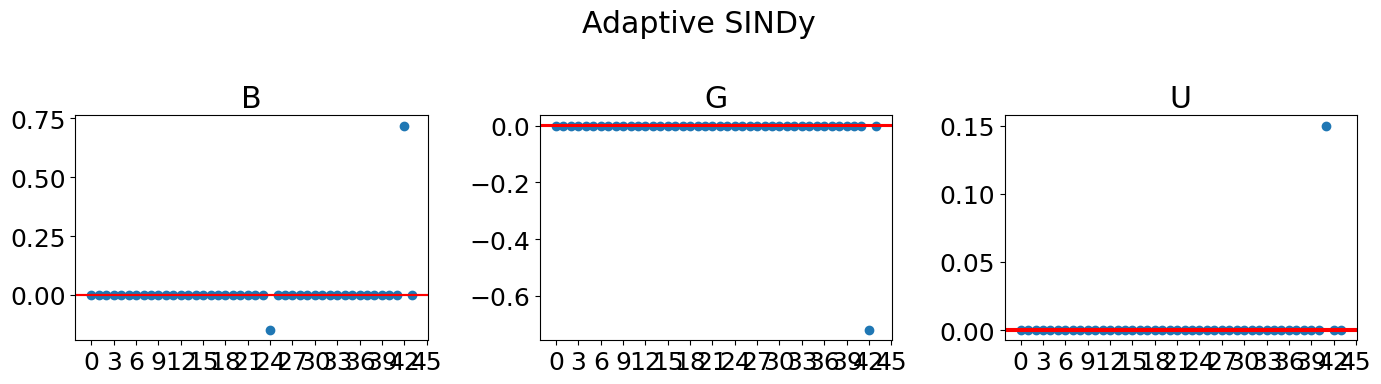

In [11]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('B')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('G')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

ax[2].plot(COEFF_ADT [:, 2].detach().cpu().numpy(), 'o')
ax[2].set_title('U')
ax[2].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[2].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[2].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [12]:
print('COEFFICIENT MATRIX',  COEFF_ADT)
print('SINE COEFFICIENT',    SINE_ADT )
print('XSINE COEFFICIENT',   XSINE_ADT)
print('COSINE COEFFICIENT',  COSINE_ADT)
print('XCOSINE COEFFICIENT', XCOSINE_ADT)
print('EXP COEFFICIENT',     EXP_ADT)
print('XEXP COEFFICIENT',    XEXP_ADT)
print('POWER COEFFICIENT',   TPOWER_ADT)

COEFFICIENT MATRIX tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1500,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  

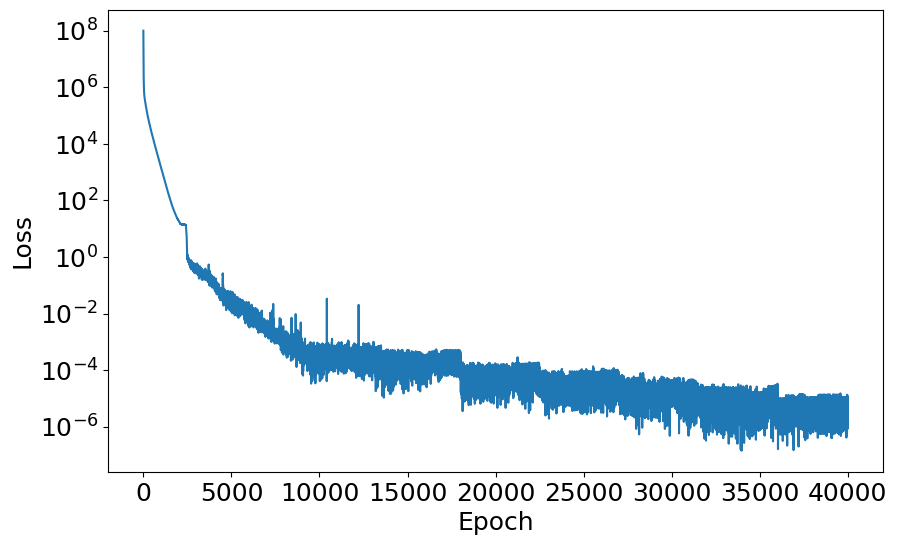

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(False)
plt.savefig('Loss_plot.jpeg', dpi = 1200)
plt.show()

In [14]:
# --- Export Loss Data to Tecplot Format ---
loss_np = Loss_data.numpy()
epochs = np.arange(len(loss_np))
loss_data = np.column_stack((epochs, loss_np))

# Header for Tecplot
header = 'VARIABLES = "Epoch", "Loss"\nZONE T="Loss Plot", I={}, F=POINT\n'.format(len(epochs))

# Write to .dat with scientific notation
with open('loss_plot_joint_min.dat', 'w') as f:
    f.write(header)
    np.savetxt(f, loss_data, fmt='%.6e', delimiter='\t')

In [15]:
# Convert tensors to numpy arrays
gamma_correct_np = torch.abs(Gamma_correct).numpy()
gamma_incorrect_np = torch.abs(Gamma_incorrect).numpy()

# Stack data as columns: Epoch, Gamma_correct, Gamma_incorrect
epochs = np.arange(len(gamma_correct_np))
data = np.column_stack((epochs, gamma_correct_np, gamma_incorrect_np))

# Define header for Tecplot
header = 'VARIABLES = "Epoch", "Gamma_Correct", "Gamma_Incorrect"\nZONE T="Gamma Plot", I={}, F=POINT\n'.format(len(epochs))

# Write to .dat file
with open('gamma_plot_joint_min.dat', 'w') as f:
    f.write(header)
    np.savetxt(f, data, fmt='%.4e', delimiter='\t')

In [16]:
print(WEIGHTS.shape)

torch.Size([44, 3])
